In [1]:
import imp
import os
import cv2
import pdb
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
import torch
from torch import optim
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
# from torch.nn.functional import InterpolationMode
import torchvision.models as models
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import logging 
import datetime
import sys
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
gloss_df_path = "data_validation/processed_gloss.csv"
gloss_df = pd.read_csv(gloss_df_path)
gloss_df.dropna(inplace=True)
gloss_df.replace(to_replace="ASHAG", value="AŞAĞI", inplace=True)
gloss_df['glossRange'] = gloss_df['glossEnd'] - gloss_df['glossStart']
# gloss_df.head()

In [3]:
classes = sorted(gloss_df.gloss.unique())
num_classes = len(classes)

In [4]:
class_to_idx = {classes[i]: i for i in range(len(classes))}
idx_to_class = {i: classes[i] for i in range(len(classes))}

In [5]:
import torchviz
from pytorchvideo.data import LabeledVideoDataset, make_clip_sampler
from torchvision.models import squeezenet1_1, SqueezeNet1_1_Weights
from torchvision import transforms

In [6]:
from pytorchvideo.data import labeled_video_dataset

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    UniformTemporalSubsample,
    Permute,   
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomAdjustSharpness,
    Resize,
    RandomHorizontalFlip
)

from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo
)

/home/toghrul/anaconda3/envs/sign-lang/lib/python3.9/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in 0.14. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/toghrul/anaconda3/envs/sign-lang/lib/python3.9/site-packages/torchvision/transforms/_transforms_video.py:25: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in 0.14. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [7]:
video_transform = Compose([
    ApplyTransformToKey(key="video",
    transform=Compose([
        UniformTemporalSubsample(50),
        Lambda(lambda x: x/255),
        Normalize((0.45, 0.45, 0.45), (0.225, 0.225, 0.225)),
        # RandomShortSideScale(min_size=256, max_size=512),
        CenterCropVideo(256),
        RandomHorizontalFlip(p=0.5),
    ]),
    ),
])

In [8]:
train_path = "/home/toghrul/SLR/data/binary-data/train"
val_path = "/home/toghrul/SLR/data/binary-data/val"
test_path = "/home/toghrul/SLR/data/binary-data/test"

In [9]:
bin_classes = []

for gloss in os.listdir(test_path):
    bin_classes.append(gloss)

In [10]:
bin_classes = sorted(bin_classes)
bin_class_to_idx = {bin_classes[i]: i for i in range(len(bin_classes))}
bin_idx_to_class = {i: bin_classes[i] for i in range(len(bin_classes))}
bin_idx_to_class

{0: 'MƏN', 1: 'VAR'}

In [11]:
from pytorch_lightning import LightningModule, seed_everything, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts
from sklearn.metrics import classification_report
import torchmetrics

In [12]:
# video_model = torch.hub.load('facebookresearch/pytorchvideo', 'efficient_x3d_xs', pretrained=True)

In [13]:
dataset = labeled_video_dataset(train_path, transform=video_transform, clip_sampler=make_clip_sampler('random', 2), decode_audio=False)

loader = DataLoader(dataset, batch_size=8, num_workers=0, pin_memory=True)

In [14]:
batch = next(iter(loader))

In [15]:
batch.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [16]:
batch['video'].shape

torch.Size([8, 3, 50, 256, 256])

In [17]:
class VideoModel(LightningModule):
    def __init__(self, ):
        super(VideoModel, self).__init__()

        self.video_model = torch.hub.load('facebookresearch/pytorchvideo', 'efficient_x3d_xs', pretrained=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(400, 1)
        # self.softmax = nn.Softmax(dim=0)
        # self.log_softmax = nn.LogSoftmax ()
        # self.sigmoid = nn.Sigmoid()
        
        self.clip_duraiton = 2
        self.lr = 1e-3
        self.batch_size = 8
        self.num_worker = 4
        self.num_steps_train = 0
        self.num_steps_val = 0

        # self.metric = torchmetrics.classification.MultilabelAccuracy(num_labels=num_classes)
        self.metric = torchmetrics.Accuracy()
        
        #loss
        self.criterion = nn.BCEWithLogitsLoss()
        # self.criterion = nn.BCELoss()

    def forward(self, x):
        x = self.video_model(x)
        x = self.relu(x)
        x = self.fc(x)
        # x = self.softmax(x)
        # x = self.log_softmax(x)
        # x = self.sigmoid(x)
        return x

    def configure_optimizers(self):
        opt = torch.optim.AdamW(params=self.parameters(), lr = self.lr)
        # scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.05, patience=2, min_lr=1e-6)
        scheduler = CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=2, eta_min=1e-6, last_epoch=-1, verbose=True)
        return {'optimizer': opt,
                'lr_scheduler': scheduler, 
                "monitor": "train_loss"}

    def train_dataloader(self):
        dataset = labeled_video_dataset(train_path, clip_sampler=make_clip_sampler('random', self.clip_duraiton),
                                         transform=video_transform, decode_audio=False)

        loader = DataLoader(dataset, batch_size=self.batch_size, num_workers=self.num_worker, pin_memory=True)

        return loader

    def training_step(self, batch, batch_idx):
        video, label = batch['video'], batch['label']
        # label = F.one_hot(label, num_classes=num_classes).float()
        out = self(video)
        print(f">>> Training step No.{self.num_steps_train}:")
        print(f"Label: {label}\nPred: {out}")
        # print("Pred:", out)
        # print("GT:", label)
        # print(f"Pred:\n{out}")
        # print(f"Pred shape:\n{out.shape}")
        # print(f"Label:\n{label}")
        # print(f"Label shape:\n{label.shape}")
        # print(">>> INFO: Computing Training Loss")
        
        loss = self.criterion(out, label.float().unsqueeze(1))
        
        print(f"Loss: {loss}")
        self.num_steps_train += 1
        # print(">>> INFO: Training Loss Computed")
        # print(">>> INFO: Computing Training Metric")
        # metric = self.metric(out, label)
        
        # Below is for Accuracy
        metric = self.metric(out, label.to(torch.int64).unsqueeze(1))
        
        print(f"Accuracy: {metric}")

        values = {"loss": loss,
                "metric": metric.detach()}
        
        self.log_dict({"step_loss": loss,
                        "step_metric": metric.detach()})
        
        return values
        
        # return {"loss": loss}

    def training_epoch_end(self, outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean().cpu().numpy().round(2)
        metric = torch.stack([x['metric'] for x in outputs]).mean().cpu().numpy().round(2)
        
        self.log('training_loss', loss)
        print(f">>> Epoch end loss: {loss}")
        self.log('training_metric', metric)
        

    def val_dataloader(self):
        dataset = labeled_video_dataset(val_path, clip_sampler=make_clip_sampler('random', self.clip_duraiton),
                                         transform=video_transform, decode_audio=False)

        loader = DataLoader(dataset, batch_size=self.batch_size, num_workers=self.num_worker, pin_memory=True)

        return loader

    def validation_step(self, batch, batch_idx):
        video, label = batch['video'], batch['label']
        # label = F.one_hot(label, num_classes=num_classes).float()
        out = self(video)
        print(f">>> Validation step No.{self.num_steps_val}:")
        print(f"Label: {label}\nPred: {out}")
        # print(">>> INFO: Computing Val Loss")

        loss = self.criterion(out, label.float().unsqueeze(1))
        print()
        print(f"Loss: {loss}")
        self.num_steps_val += 1
        # print(">>> INFO: Val Loss Computed")
        # print(">>> INFO: Computing Val Metric")
        # metric = self.metric(out, label)
        # Below is for Accuracy
        
        metric = self.metric(out, label.to(torch.int64).unsqueeze(1))
                
        print(f"Accuracy: {metric}")
        

        return {"loss": loss,
                "metric": metric.detach()}
        
        # return {"loss": loss}

    def validation_epoch_end(self, outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean().cpu().numpy().round(2)
        metric = torch.stack([x['metric'] for x in outputs]).mean().cpu().numpy().round(2)
        self.log('val_loss', loss)
        self.log('val_metric', metric)

    def test_dataloader(self):
        dataset = labeled_video_dataset(test_path, clip_sampler=make_clip_sampler('random', self.clip_duraiton),
                                         transform=video_transform, decode_audio=False)

        loader = DataLoader(dataset, batch_size=self.batch_size, num_workers=self.num_worker, pin_memory=True)

        return loader

    def test_step(self, batch, batch_idx):
        video, label = batch['video'], batch['label']
        # label = F.one_hot(label, num_classes=num_classes).float()
        out = self.forward(video)
        # metric = self.metric(out, label)

        return {"label": label,
                "pred": out.detach(),}

    def test_epoch_end(self, outputs):
        label=torch.cat([x['label'] for x in outputs]).cpu().numpy()
        pred = torch.cat([x['pred'] for x in outputs]).cpu().numpy()
        # self.log('test_loss', loss)
        # self.log('test_metric', metric)
        
        # Below is for MultiLabelClassification
        # class_labels = label.argmax(axis=1)
        # class_pred = pred.argmax(axis=1)
        
        
        # Below is for BinaryClassification
        class_labels = label
        class_pred = np.where(pred > 0, 1, 0)
        
        print(f">> Label: {class_labels}")
        print(f">> Pred: {class_pred.squeeze()}")
              
        print(classification_report(class_labels, class_pred))
        cm = confusion_matrix(class_labels, class_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        
        return {"prediction": class_pred,
                "labels": class_labels}




In [18]:
checkpoint_callback = ModelCheckpoint(monitor='val_loss',mode="min", dirpath="checkpoints", auto_insert_metric_name=True,
                                    verbose=True, save_last=True, save_top_k=2)
lr_monitor = LearningRateMonitor(logging_interval="epoch")


# Training

In [19]:
model = VideoModel()
seed_everything(0)

Using cache found in /home/toghrul/.cache/torch/hub/facebookresearch_pytorchvideo_main
Global seed set to 0


0

In [32]:
trainer = Trainer(max_epochs=100,
                accelerator="gpu", devices=-1,
                precision=16,
                # accumulate_grad_batches=2,
                enable_progress_bar=True,
                # num_sanity_val_steps=0,
                callbacks=[lr_monitor, checkpoint_callback],
                log_every_n_steps=5,
                limit_train_batches=25,
                limit_val_batches=10,
                limit_test_batches=20,)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
# trainer.fit(model, ckpt_path="/home/toghrul/SLR/sign-lang/checkpoints/last-v10.ckpt")
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params
--------------------------------------------------
0 | video_model | EfficientX3d      | 3.8 M 
1 | relu        | ReLU              | 0     
2 | fc          | Linear            | 401   
3 | metric      | Accuracy          | 0     
4 | criterion   | BCEWithLogitsLoss | 0     
--------------------------------------------------
3.8 M     Trainable params
0         Non-trainable params
3.8 M     Total params
7.589     Total estimated model params size (MB)


Epoch 00000: adjusting learning rate of group 0 to 1.0000e-03.


Sanity Checking: 0it [00:00, ?it/s]

>>> Validation step No.0:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[0.4119],
        [0.3506],
        [0.3630],
        [0.8242],
        [0.2489],
        [0.6128],
        [0.3569],
        [0.5464]], device='cuda:0', dtype=torch.float16)

Loss: 0.9555665254592896
Accuracy: 0.625
>>> Validation step No.1:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[0.5649],
        [0.5850],
        [0.9131],
        [0.5171],
        [0.5049],
        [0.5415],
        [0.6416],
        [0.4663]], device='cuda:0', dtype=torch.float16)

Loss: 0.9610096216201782
Accuracy: 0.25


Training: 0it [00:00, ?it/s]

>>> Training step No.0:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 0.0907],
        [ 0.4399],
        [ 0.2383],
        [-0.1699],
        [ 0.5186],
        [ 0.0947],
        [ 0.2489],
        [ 0.3777]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.8200134038925171
Accuracy: 0.875
>>> Training step No.1:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 0.5405],
        [-0.0359],
        [ 0.4275],
        [ 0.3945],
        [ 0.1974],
        [ 0.4539],
        [ 0.4888],
        [ 0.1736]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.8759063482284546
Accuracy: 0.875
>>> Training step No.2:
Label: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Pred: tensor([[-2.7383],
        [-1.2988],
        [-1.6035],
        [-1.7080],
        [-1.0332],
        [-1.3008],
        [-1.2305],
        [-1.0293]], device='cuda:0', dtype=torch.float16,
       grad_fn=<Ad

Validation: 0it [00:00, ?it/s]

>>> Validation step No.2:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -5.8711],
        [-13.1172],
        [-16.6875],
        [-11.2578],
        [-24.7031],
        [-18.5312],
        [-22.8125],
        [-20.8125]], device='cuda:0', dtype=torch.float16)

Loss: 0.7342405319213867
Accuracy: 0.875
>>> Validation step No.3:
Label: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -7.1797],
        [-19.5156],
        [-15.5312],
        [ -6.4805],
        [-14.1016],
        [-21.8125],
        [-20.5469],
        [ -5.6953]], device='cuda:0', dtype=torch.float16)

Loss: 1.7082258462905884
Accuracy: 0.75
>>> Validation step No.4:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-21.6875],
        [-19.4844],
        [ -6.6523],
        [-13.2969],
        [-23.3906],
        [-17.6562],
        [-19.1875],
        [-12.4141]], device='cuda:0', dtype=torch.float16)

Loss: 0.0001619907416170463
Accuracy: 1.0
>>> Valida

Epoch 0, global step 25: 'val_loss' reached 0.68000 (best 0.68000), saving model to '/home/toghrul/SLR/sign-lang/checkpoints/epoch=0-step=25-v3.ckpt' as top 2


Label: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-19.9219],
        [-20.4375],
        [-20.2031],
        [ -7.6367],
        [-21.9219],
        [-20.9531],
        [ -1.1543],
        [ -6.0508]], device='cuda:0', dtype=torch.float16)

Loss: 1.133487582206726
Accuracy: 0.75
>>> Epoch end loss: 0.44999998807907104
>>> Training step No.25:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-2.6289],
        [-7.3477],
        [-9.1016],
        [ 0.2578],
        [-5.4883],
        [-9.8906],
        [-4.0820],
        [-7.9062]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.11525561660528183
Accuracy: 1.0
>>> Training step No.26:
Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-6.7617],
        [-9.9531],
        [-6.4375],
        [-6.7461],
        [-8.4922],
        [-6.2578],
        [ 0.5728],
        [-1.0977]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackwa

Validation: 0it [00:00, ?it/s]

>>> Validation step No.12:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-13.8359],
        [-22.7812],
        [-23.7812],
        [ -7.8945],
        [-23.5156],
        [-20.1719],
        [-21.7812],
        [-26.2500]], device='cuda:0', dtype=torch.float16)

Loss: 0.9868631362915039
Accuracy: 0.875
>>> Validation step No.13:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-20.2500],
        [-20.2969],
        [-20.2188],
        [-17.5781],
        [  3.1035],
        [-21.7969],
        [-16.1250],
        [-19.7344]], device='cuda:0', dtype=torch.float16)

Loss: 0.005489100702106953
Accuracy: 1.0
>>> Validation step No.14:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-18.9062],
        [-26.3594],
        [-20.6719],
        [-16.2344],
        [-22.0469],
        [-20.0625],
        [-18.0312],
        [-27.2812]], device='cuda:0', dtype=torch.float16)

Loss: 1.4901160305669237e-08
Accuracy: 1.0
>>> V

Epoch 1, global step 50: 'val_loss' reached 0.57000 (best 0.57000), saving model to '/home/toghrul/SLR/sign-lang/checkpoints/epoch=1-step=50-v1.ckpt' as top 2


Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-18.0938],
        [ -9.1328],
        [-28.9844],
        [-22.2344],
        [-22.8125],
        [-18.7031],
        [-28.4062],
        [-22.8906]], device='cuda:0', dtype=torch.float16)

Loss: 1.3499722626875155e-05
Accuracy: 1.0
>>> Epoch end loss: 0.07000000029802322
>>> Training step No.50:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -6.2227],
        [-17.7188],
        [-10.5547],
        [-18.8438],
        [ -3.7031],
        [-15.7891],
        [-18.9375],
        [-10.6250]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0032975198701024055
Accuracy: 1.0
>>> Training step No.51:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-10.3984],
        [-16.6719],
        [-15.2344],
        [-16.4844],
        [-14.0469],
        [ -9.1250],
        [ -5.5742],
        [-10.7422]], device='cuda:0', dtype=torch.float16,
     

Validation: 0it [00:00, ?it/s]

>>> Validation step No.22:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -2.7285],
        [ -3.4375],
        [-10.8281],
        [ -4.8867],
        [-20.9688],
        [ -4.2930],
        [ -3.6113],
        [ -9.9375]], device='cuda:0', dtype=torch.float16)

Loss: 0.017840728163719177
Accuracy: 1.0
>>> Validation step No.23:
Label: tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Pred: tensor([[  0.9424],
        [ -4.1719],
        [-15.3359],
        [-12.3750],
        [  0.0726],
        [-10.2422],
        [ -4.7852],
        [ -1.6279]], device='cuda:0', dtype=torch.float16)

Loss: 0.35217922925949097
Accuracy: 0.75
>>> Validation step No.24:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-16.8594],
        [ -0.1857],
        [-21.8594],
        [ -5.1875],
        [ -4.5000],
        [ -9.0469],
        [ -4.6641],
        [-13.7500]], device='cuda:0', dtype=torch.float16)

Loss: 0.10205067694187164
Accuracy: 0.875
>>> Va

Epoch 2, global step 75: 'val_loss' reached 0.21000 (best 0.21000), saving model to '/home/toghrul/SLR/sign-lang/checkpoints/epoch=2-step=75-v4.ckpt' as top 2


>>> Validation step No.31:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[ -9.6484],
        [ -8.1172],
        [-16.4531],
        [-12.3125],
        [-15.1797],
        [ -0.6489],
        [-19.1406],
        [-18.3438]], device='cuda:0', dtype=torch.float16)

Loss: 0.1337146759033203
Accuracy: 0.875
>>> Epoch end loss: 0.27000001072883606
>>> Training step No.75:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-14.3828],
        [ -9.0078],
        [ -4.3672],
        [ -7.7500],
        [ -1.0449],
        [ -9.4375],
        [ -2.1406],
        [ -4.1055]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.05526655539870262
Accuracy: 1.0
>>> Training step No.76:
Label: tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Pred: tensor([[ -3.2852],
        [ -2.6484],
        [-12.7891],
        [  0.1250],
        [-14.6250],
        [ -1.4258],
        [ -1.2568],
        [-10.1094]], device='cuda:0', dty

Validation: 0it [00:00, ?it/s]

>>> Validation step No.32:
Label: tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 12.2578],
        [  5.2109],
        [ 12.1875],
        [-11.6328],
        [-10.0781],
        [ -5.4570],
        [-10.6875],
        [-16.2500]], device='cuda:0', dtype=torch.float16)

Loss: 0.0012228107079863548
Accuracy: 1.0
>>> Validation step No.33:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-11.7031],
        [-12.4375],
        [  9.7969],
        [ -9.6016],
        [ -2.9023],
        [-16.2031],
        [-23.4531],
        [-21.0312]], device='cuda:0', dtype=torch.float16)

Loss: 0.006697031203657389
Accuracy: 1.0
>>> Validation step No.34:
Label: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[  6.9258],
        [-16.2344],
        [-11.2188],
        [-11.4531],
        [ -5.8125],
        [ 10.3125],
        [-18.2344],
        [-15.5547]], device='cuda:0', dtype=torch.float16)

Loss: 0.000503086019307375
Accuracy: 1.0
>>> Va

Epoch 3, global step 100: 'val_loss' reached 0.05000 (best 0.05000), saving model to '/home/toghrul/SLR/sign-lang/checkpoints/epoch=3-step=100-v3.ckpt' as top 2


Label: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Pred: tensor([[-23.8594],
        [-18.7656],
        [-15.9922],
        [ -5.3203],
        [-10.2969],
        [  0.3848],
        [  3.5215],
        [-24.7969]], device='cuda:0', dtype=torch.float16)

Loss: 0.0691496729850769
Accuracy: 0.875
>>> Epoch end loss: 0.07000000029802322
>>> Training step No.100:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[ -7.7500],
        [ -8.8438],
        [-14.6016],
        [-11.9922],
        [-11.0078],
        [ -7.4609],
        [-10.8281],
        [  7.1484]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0002473169006407261
Accuracy: 1.0
>>> Training step No.101:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[ -9.1484],
        [-12.0469],
        [-17.2500],
        [  4.5820],
        [-13.6641],
        [-16.1875],
        [-10.8281],
        [  5.3828]], device='cuda:0', dtype=torch.float16,
     

Validation: 0it [00:00, ?it/s]

>>> Validation step No.42:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-20.3906],
        [-21.7656],
        [ -7.2812],
        [ -8.1016],
        [ -4.9258],
        [  4.7109],
        [-13.2109],
        [ -9.6875]], device='cuda:0', dtype=torch.float16)

Loss: 0.0021552492398768663
Accuracy: 1.0
>>> Validation step No.43:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[  0.5244],
        [ -9.8594],
        [-18.6250],
        [-17.6406],
        [ -7.8281],
        [-21.7344],
        [-23.9062],
        [-20.0312]], device='cuda:0', dtype=torch.float16)

Loss: 0.05817250534892082
Accuracy: 1.0
>>> Validation step No.44:
Label: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Pred: tensor([[-17.6406],
        [-16.3750],
        [ -5.0156],
        [-15.9531],
        [ -3.7227],
        [ -5.5820],
        [-14.7891],
        [-12.3203]], device='cuda:0', dtype=torch.float16)

Loss: 1.1673680543899536
Accuracy: 0.75
>>> Vali

Epoch 4, global step 125: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-26.6875],
        [-14.3516],
        [-19.7812],
        [-22.8750],
        [-13.9688],
        [-21.0312],
        [-18.5469],
        [-12.0547]], device='cuda:0', dtype=torch.float16)

Loss: 9.089686159313715e-07
Accuracy: 1.0
>>> Epoch end loss: 0.11999999731779099
>>> Training step No.125:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-10.0625],
        [ -7.6562],
        [-10.7891],
        [-17.6250],
        [-12.0781],
        [-21.7812],
        [-12.1406],
        [ -9.0625]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 8.290999539894983e-05
Accuracy: 1.0
>>> Training step No.126:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-20.8281],
        [-19.6562],
        [-18.7188],
        [  4.2461],
        [-18.0312],
        [-11.8359],
        [ -8.6953],
        [ -5.2500]], device='cuda:0', dtype=torch.float16,
    

Validation: 0it [00:00, ?it/s]

>>> Validation step No.52:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-24.7812],
        [-14.8594],
        [-12.1016],
        [-11.3828],
        [-16.4844],
        [-11.7500],
        [-12.8750],
        [-10.5938]], device='cuda:0', dtype=torch.float16)

Loss: 6.616061909880955e-06
Accuracy: 1.0
>>> Validation step No.53:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-11.0938],
        [-16.6719],
        [-16.1406],
        [-18.7812],
        [ -9.2812],
        [-20.9844],
        [-16.6250],
        [-15.6094]], device='cuda:0', dtype=torch.float16)

Loss: 1.3589302398031577e-05
Accuracy: 1.0
>>> Validation step No.54:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-14.3594],
        [-24.1406],
        [-13.9531],
        [-10.0000],
        [-11.4375],
        [-20.0781],
        [-18.0312],
        [-13.7344]], device='cuda:0', dtype=torch.float16)

Loss: 7.331234883167781e-06
Accuracy: 1.0
>>>

Epoch 5, global step 150: 'val_loss' reached 0.00000 (best 0.00000), saving model to '/home/toghrul/SLR/sign-lang/checkpoints/epoch=5-step=150-v2.ckpt' as top 2


>>> Validation step No.61:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-13.5781],
        [-14.3281],
        [-19.7188],
        [-16.7500],
        [-19.9531],
        [-14.0703],
        [ -8.3672],
        [-16.0625]], device='cuda:0', dtype=torch.float16)

Loss: 2.9396618629107252e-05
Accuracy: 1.0
>>> Epoch end loss: 0.019999999552965164
>>> Training step No.150:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[  0.6919],
        [-12.0000],
        [ -9.7500],
        [-12.0234],
        [-10.5391],
        [-16.5625],
        [ -8.4141],
        [-20.4531]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.1372620165348053
Accuracy: 0.875
>>> Training step No.151:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-13.0312],
        [-18.9844],
        [-12.6719],
        [-11.8594],
        [  5.3594],
        [-12.8516],
        [-14.3047],
        [-13.4141]], device='cuda:0

Validation: 0it [00:00, ?it/s]

>>> Validation step No.62:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-13.0078],
        [-16.1875],
        [-15.0234],
        [-12.3281],
        [-20.9688],
        [-15.5391],
        [-15.1172],
        [  8.9375]], device='cuda:0', dtype=torch.float16)

Loss: 1.7358772311126813e-05
Accuracy: 1.0
>>> Validation step No.63:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-19.8438],
        [  5.5703],
        [-26.1250],
        [ -9.5547],
        [-13.9922],
        [-16.1094],
        [-18.3594],
        [ -9.6719]], device='cuda:0', dtype=torch.float16)

Loss: 0.0004921146319247782
Accuracy: 1.0
>>> Validation step No.64:
Label: tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Pred: tensor([[ 13.3125],
        [-18.1406],
        [-22.7500],
        [-16.7031],
        [-11.1641],
        [  7.0078],
        [ 10.8359],
        [-15.0859]], device='cuda:0', dtype=torch.float16)

Loss: 0.00011751899000955746
Accuracy: 1.0
>>

Epoch 6, global step 175: 'val_loss' was not in top 2


>>> Validation step No.71:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-16.2969],
        [-12.8516],
        [ -9.2109],
        [ 18.3906],
        [-13.1172],
        [-14.4297],
        [-13.2266],
        [-12.8516]], device='cuda:0', dtype=torch.float16)

Loss: 1.3708443475479726e-05
Accuracy: 1.0
>>> Epoch end loss: 0.09000000357627869
>>> Training step No.175:
Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[ -6.0430],
        [-11.4688],
        [ -9.3438],
        [-19.2500],
        [-18.8750],
        [-10.3125],
        [  7.7734],
        [-16.0312]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0003654749598354101
Accuracy: 1.0
>>> Training step No.176:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-17.5781],
        [-13.6719],
        [-15.0703],
        [ -6.6328],
        [-10.1016],
        [ -8.0391],
        [-16.9844],
        [-10.0156]], device='cuda:0

Validation: 0it [00:00, ?it/s]

>>> Validation step No.72:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-25.7500],
        [-15.5312],
        [ -2.8008],
        [  2.2285],
        [-11.2578],
        [-11.9453],
        [-12.5234],
        [ -5.2266]], device='cuda:0', dtype=torch.float16)

Loss: 0.020830491557717323
Accuracy: 1.0
>>> Validation step No.73:
Label: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Pred: tensor([[ -9.7969],
        [-15.9531],
        [-18.5000],
        [ -5.5938],
        [ 10.3984],
        [-10.4688],
        [  9.3047],
        [ -4.3984]], device='cuda:0', dtype=torch.float16)

Loss: 0.002017661463469267
Accuracy: 1.0
>>> Validation step No.74:
Label: tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Pred: tensor([[-16.0469],
        [-13.6797],
        [  4.8008],
        [ -9.0781],
        [ -5.0391],
        [  9.9297],
        [  8.8984],
        [-16.0781]], device='cuda:0', dtype=torch.float16)

Loss: 0.0018686862895265222
Accuracy: 1.0
>>> Va

Epoch 7, global step 200: 'val_loss' was not in top 2


>>> Validation step No.81:
Label: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[ -2.9824],
        [-12.0938],
        [ -9.1250],
        [ -9.9453],
        [ -5.7148],
        [  8.1562],
        [ -5.4805],
        [ -2.6016]], device='cuda:0', dtype=torch.float16)

Loss: 0.388910710811615
Accuracy: 0.875
>>> Epoch end loss: 0.03999999910593033
>>> Training step No.200:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-15.1562],
        [-22.1875],
        [ -5.8516],
        [-11.1719],
        [  6.0469],
        [ -6.6172],
        [-13.5938],
        [-16.7812]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0008231917745433748
Accuracy: 1.0
>>> Training step No.201:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[ -5.8906],
        [-11.9844],
        [ -8.4766],
        [-17.7031],
        [ -6.0195],
        [-21.7656],
        [-16.0469],
        [  0.5913]], device='cuda:0', 

Validation: 0it [00:00, ?it/s]

>>> Validation step No.82:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Pred: tensor([[ -7.4688],
        [-10.8203],
        [ -3.5801],
        [ -7.7695],
        [  9.0547],
        [ -5.6172],
        [ -9.3438],
        [  7.9844]], device='cuda:0', dtype=torch.float16)

Loss: 0.0040847607888281345
Accuracy: 1.0
>>> Validation step No.83:
Label: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[ 12.0078],
        [-12.3594],
        [-11.3359],
        [ -5.3555],
        [ -7.6641],
        [ -1.1533],
        [ -1.5439],
        [-16.5156]], device='cuda:0', dtype=torch.float16)

Loss: 0.20329318940639496
Accuracy: 0.875
>>> Validation step No.84:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-10.9922],
        [ -9.4453],
        [-15.8047],
        [-15.5703],
        [-18.2344],
        [  5.4375],
        [-14.6172],
        [ -8.6719]], device='cuda:0', dtype=torch.float16)

Loss: 0.0005760893109254539
Accuracy: 1.0
>>> 

Epoch 8, global step 225: 'val_loss' reached 0.04000 (best 0.00000), saving model to '/home/toghrul/SLR/sign-lang/checkpoints/epoch=8-step=225.ckpt' as top 2


Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[ -1.1318],
        [-13.4922],
        [-12.4922],
        [ -7.6289],
        [-17.2500],
        [ 12.9062],
        [ -1.9609],
        [ -6.0117]], device='cuda:0', dtype=torch.float16)

Loss: 0.05176062881946564
Accuracy: 1.0
>>> Epoch end loss: 0.07999999821186066
>>> Training step No.225:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -3.0820],
        [ -8.2656],
        [ -9.2578],
        [-13.5391],
        [-15.6797],
        [ -8.0078],
        [-11.5078],
        [ -1.4629]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.03172856941819191
Accuracy: 1.0
>>> Training step No.226:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -1.5723],
        [-10.3906],
        [-10.7109],
        [ -8.9062],
        [-13.6953],
        [ -8.7812],
        [-10.4766],
        [-10.8828]], device='cuda:0', dtype=torch.float16,
       g

Validation: 0it [00:00, ?it/s]

>>> Validation step No.92:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -6.3047],
        [-10.2812],
        [ -7.6523],
        [-18.2031],
        [ 13.9062],
        [ -9.5156],
        [-13.2969],
        [ -9.5625]], device='cuda:0', dtype=torch.float16)

Loss: 0.00031021254835650325
Accuracy: 1.0
>>> Validation step No.93:
Label: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[  4.7305],
        [-15.3984],
        [ 10.6016],
        [-13.4375],
        [ -8.6641],
        [ -9.8281],
        [-14.9531],
        [-10.3047]], device='cuda:0', dtype=torch.float16)

Loss: 0.0011338340118527412
Accuracy: 1.0
>>> Validation step No.94:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-15.6797],
        [ -9.5625],
        [ -8.3672],
        [-11.3125],
        [ -1.1924],
        [  6.3477],
        [ -9.2109],
        [ -2.1875]], device='cuda:0', dtype=torch.float16)

Loss: 0.046694036573171616
Accuracy: 1.0
>>> 

Epoch 9, global step 250: 'val_loss' reached 0.01000 (best 0.00000), saving model to '/home/toghrul/SLR/sign-lang/checkpoints/epoch=9-step=250.ckpt' as top 2


Label: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[ 13.8906],
        [ -2.3848],
        [ -4.2266],
        [-14.8594],
        [-10.2500],
        [ -6.5820],
        [ 14.6016],
        [ -1.4424]], device='cuda:0', dtype=torch.float16)

Loss: 0.03952563554048538
Accuracy: 1.0
>>> Epoch end loss: 0.05000000074505806
>>> Training step No.250:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-10.8203],
        [-12.0156],
        [  4.6758],
        [ -3.0742],
        [ -9.3750],
        [ -5.3398],
        [-23.0312],
        [  6.8789]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.00754864327609539
Accuracy: 1.0
>>> Training step No.251:
Label: tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-18.2969],
        [  2.9180],
        [-20.2656],
        [  4.4258],
        [-12.6484],
        [ -5.5391],
        [ -8.4453],
        [  3.7871]], device='cuda:0', dtype=torch.float16,
       g

Validation: 0it [00:00, ?it/s]

>>> Validation step No.102:
Label: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-13.9609],
        [ -6.2539],
        [-14.1016],
        [-22.5469],
        [  4.7773],
        [-23.9688],
        [-15.6250],
        [-22.7344]], device='cuda:0', dtype=torch.float16)

Loss: 0.7830265164375305
Accuracy: 0.875
>>> Validation step No.103:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-28.5000],
        [-30.7500],
        [-17.7031],
        [-23.0625],
        [-26.4688],
        [ -7.4844],
        [-25.0938],
        [-27.4844]], device='cuda:0', dtype=torch.float16)

Loss: 7.020945486146957e-05
Accuracy: 1.0
>>> Validation step No.104:
Label: tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-20.2031],
        [-29.5000],
        [  4.4648],
        [ -1.4053],
        [-23.6562],
        [-33.0312],
        [  4.3203],
        [-24.3594]], device='cuda:0', dtype=torch.float16)

Loss: 0.20616234838962555
Accuracy: 0.875
>>

Epoch 10, global step 275: 'val_loss' was not in top 2


>>> Validation step No.111:
Label: tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Pred: tensor([[-23.1250],
        [  6.2734],
        [-23.3438],
        [-28.9844],
        [  2.1074],
        [-14.6328],
        [  2.8398],
        [ -8.9531]], device='cuda:0', dtype=torch.float16)

Loss: 0.02168969251215458
Accuracy: 1.0
>>> Epoch end loss: 0.03999999910593033
>>> Training step No.275:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -7.3008],
        [-23.4375],
        [  6.3086],
        [-18.9531],
        [-20.1094],
        [-15.2891],
        [-14.9531],
        [-12.3359]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.00031233139452524483
Accuracy: 1.0
>>> Training step No.276:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -6.6523],
        [-25.3750],
        [-16.2344],
        [-13.0312],
        [ -7.7852],
        [-20.8750],
        [-16.2500],
        [ -4.3086]], device='cuda:0'

Validation: 0it [00:00, ?it/s]

>>> Validation step No.112:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-13.9062],
        [ -3.0879],
        [ -6.1250],
        [ -5.8867],
        [-15.2266],
        [  8.3594],
        [ -7.4844],
        [ -5.9570]], device='cuda:0', dtype=torch.float16)

Loss: 0.006615947466343641
Accuracy: 1.0
>>> Validation step No.113:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-13.1406],
        [ -8.2422],
        [ -8.4141],
        [-12.8828],
        [  9.1875],
        [-14.3984],
        [-17.6562],
        [-12.1562]], device='cuda:0', dtype=torch.float16)

Loss: 7.469145930372179e-05
Accuracy: 1.0
>>> Validation step No.114:
Label: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[  8.7812],
        [-19.0625],
        [ -9.4531],
        [-14.3125],
        [  3.6191],
        [ -2.3535],
        [  7.7969],
        [-12.5156]], device='cuda:0', dtype=torch.float16)

Loss: 0.46712827682495117
Accuracy: 0.875
>>

Epoch 11, global step 300: 'val_loss' was not in top 2


Label: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[  4.9961],
        [-10.9375],
        [-12.0234],
        [-20.0000],
        [  0.1207],
        [-14.4062],
        [-14.0078],
        [ -9.1641]], device='cuda:0', dtype=torch.float16)

Loss: 0.0801844596862793
Accuracy: 0.875
>>> Epoch end loss: 0.07000000029802322
>>> Training step No.300:
Label: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-16.7969],
        [ -5.0039],
        [  0.4946],
        [ -9.7188],
        [-15.5469],
        [ -0.6704],
        [ -9.9609],
        [-13.6797]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.19580227136611938
Accuracy: 0.75
>>> Training step No.301:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-11.6953],
        [ -3.7227],
        [ -4.4414],
        [-10.2109],
        [-22.6875],
        [ -5.8906],
        [ -9.0078],
        [  3.8691]], device='cuda:0', dtype=torch.float16,
      

Validation: 0it [00:00, ?it/s]

>>> Validation step No.122:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-31.4844],
        [-24.7031],
        [-17.3750],
        [-21.3594],
        [  0.1947],
        [-15.0156],
        [-33.8750],
        [-41.1250]], device='cuda:0', dtype=torch.float16)

Loss: 0.07506595551967621
Accuracy: 0.875
>>> Validation step No.123:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-22.7812],
        [ -8.1719],
        [-31.3594],
        [ -5.5820],
        [-29.8594],
        [-42.0625],
        [-23.7344],
        [-21.2500]], device='cuda:0', dtype=torch.float16)

Loss: 1.021989345550537
Accuracy: 0.875
>>> Validation step No.124:
Label: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-28.4688],
        [-29.7031],
        [-27.7656],
        [ -3.2969],
        [ -2.8848],
        [-30.9375],
        [-33.5000],
        [-21.1562]], device='cuda:0', dtype=torch.float16)

Loss: 0.7840417623519897
Accuracy: 0.75
>>> V

Epoch 12, global step 325: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Pred: tensor([[-33.0938],
        [-38.0000],
        [-18.6875],
        [-32.2500],
        [-22.5938],
        [-26.8906],
        [ -2.5820],
        [ -0.9077]], device='cuda:0', dtype=torch.float16)

Loss: 0.48769670724868774
Accuracy: 0.75
>>> Epoch end loss: 0.07000000029802322
>>> Training step No.325:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-25.4375],
        [ -5.7656],
        [-11.5938],
        [-15.7031],
        [ -8.5312],
        [ -8.5391],
        [-16.5938],
        [-11.0938]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0004432436835486442
Accuracy: 1.0
>>> Training step No.326:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -9.7500],
        [-12.0625],
        [-13.6250],
        [-14.8516],
        [-13.7266],
        [-11.2969],
        [-11.7812],
        [ -7.4336]], device='cuda:0', dtype=torch.float16,
     

Validation: 0it [00:00, ?it/s]

>>> Validation step No.132:
Label: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[  0.9487],
        [-10.8438],
        [-12.5469],
        [ -6.9727],
        [ -9.2656],
        [ -2.0898],
        [ -8.1484],
        [-12.0312]], device='cuda:0', dtype=torch.float16)

Loss: 0.3168920576572418
Accuracy: 0.875
>>> Validation step No.133:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-28.3281],
        [-13.2812],
        [-12.5469],
        [-17.6562],
        [-10.3125],
        [  1.5762],
        [-20.9844],
        [-11.7969]], device='cuda:0', dtype=torch.float16)

Loss: 0.023498661816120148
Accuracy: 1.0
>>> Validation step No.134:
Label: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-21.2344],
        [-13.2031],
        [-23.6875],
        [ -4.8516],
        [ -0.6426],
        [-11.1094],
        [-13.3359],
        [ -7.3984]], device='cuda:0', dtype=torch.float16)

Loss: 0.7406455278396606
Accuracy: 0.75
>>> V

Epoch 13, global step 350: 'val_loss' was not in top 2


>>> Validation step No.141:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[ -8.8047],
        [-13.5625],
        [-14.4375],
        [-20.7031],
        [-14.0312],
        [-10.2500],
        [-11.3672],
        [  1.3379]], device='cuda:0', dtype=torch.float16)

Loss: 1.1297376155853271
Accuracy: 0.875
>>> Epoch end loss: 0.12999999523162842
>>> Training step No.350:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-10.0391],
        [ -6.2812],
        [ -6.3477],
        [-10.2109],
        [-14.6719],
        [  1.4170],
        [-10.5000],
        [-14.7812]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.027600785717368126
Accuracy: 1.0
>>> Training step No.351:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -6.7695],
        [ -5.3984],
        [  2.6348],
        [-10.5781],
        [-22.9219],
        [ -9.9922],
        [ -9.5000],
        [-12.2734]], device='cuda:0',

Validation: 0it [00:00, ?it/s]

>>> Validation step No.142:
Label: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[  5.2461],
        [ -1.2217],
        [-11.2031],
        [ -3.6230],
        [-20.1562],
        [-10.3984],
        [-21.7969],
        [  9.9141]], device='cuda:0', dtype=torch.float16)

Loss: 0.18896053731441498
Accuracy: 0.875
>>> Validation step No.143:
Label: tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Pred: tensor([[ 11.3594],
        [-20.0469],
        [-17.7344],
        [ -5.7422],
        [  9.9922],
        [-13.1328],
        [ -7.5938],
        [ 10.2500]], device='cuda:0', dtype=torch.float16)

Loss: 0.0004751213709823787
Accuracy: 1.0
>>> Validation step No.144:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -9.4219],
        [-17.2656],
        [ -6.1758],
        [ -5.2148],
        [-12.4219],
        [-15.6953],
        [-14.5391],
        [-12.4766]], device='cuda:0', dtype=torch.float16)

Loss: 0.0009483606554567814
Accuracy: 1.0
>

Epoch 14, global step 375: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-19.2656],
        [ -4.3086],
        [-12.2969],
        [-11.6406],
        [ -5.2500],
        [-17.0000],
        [-24.8125],
        [ -3.4551]], device='cuda:0', dtype=torch.float16)

Loss: 0.00621326919645071
Accuracy: 1.0
>>> Epoch end loss: 0.07000000029802322
>>> Training step No.375:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-11.9453],
        [-25.7188],
        [-12.8906],
        [ -3.0918],
        [ -9.2656],
        [ -4.7695],
        [-10.8828],
        [  5.5195]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0071237096562981606
Accuracy: 1.0
>>> Training step No.376:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -4.8242],
        [  9.3984],
        [ -5.7070],
        [-15.8594],
        [-14.0312],
        [-12.4531],
        [-11.4609],
        [-22.0000]], device='cuda:0', dtype=torch.float16,
      

Validation: 0it [00:00, ?it/s]

>>> Validation step No.152:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -4.6719],
        [ -3.7520],
        [-18.6562],
        [-11.1406],
        [  9.5469],
        [ -0.2925],
        [ -8.4375],
        [ -3.7383]], device='cuda:0', dtype=torch.float16)

Loss: 0.07673660665750504
Accuracy: 1.0
>>> Validation step No.153:
Label: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[ -1.6631],
        [ -9.1172],
        [ -5.0156],
        [ 11.2500],
        [ -1.4004],
        [ 13.6797],
        [ -8.9609],
        [-34.2188]], device='cuda:0', dtype=torch.float16)

Loss: 0.05009771138429642
Accuracy: 1.0
>>> Validation step No.154:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Pred: tensor([[ -6.1680],
        [-19.3906],
        [ -3.9727],
        [-10.2422],
        [ -4.0273],
        [  7.6875],
        [ -4.8594],
        [  6.2930]], device='cuda:0', dtype=torch.float16)

Loss: 0.006059157662093639
Accuracy: 1.0
>>> Va

Epoch 15, global step 400: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[  2.3945],
        [-10.7656],
        [ -9.1172],
        [-13.5312],
        [  9.9922],
        [-22.3906],
        [ -0.8931],
        [-22.5000]], device='cuda:0', dtype=torch.float16)

Loss: 0.3531455397605896
Accuracy: 0.875
>>> Epoch end loss: 0.09000000357627869
>>> Training step No.400:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -2.4473],
        [ -2.4551],
        [ -8.8828],
        [ -5.8438],
        [-13.8672],
        [ -5.1953],
        [-15.2422],
        [ -6.0859]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.022023875266313553
Accuracy: 1.0
>>> Training step No.401:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -2.6387],
        [-11.5000],
        [ -3.7930],
        [ -8.8828],
        [  9.6250],
        [-14.6641],
        [ -6.3438],
        [ -2.4160]], device='cuda:0', dtype=torch.float16,
      

Validation: 0it [00:00, ?it/s]

>>> Validation step No.162:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-19.8750],
        [-15.3359],
        [-13.4688],
        [  6.1094],
        [ -9.9062],
        [-15.6094],
        [-25.6875],
        [-36.9688]], device='cuda:0', dtype=torch.float16)

Loss: 0.0002838866785168648
Accuracy: 1.0
>>> Validation step No.163:
Label: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Pred: tensor([[-18.0625],
        [-15.4297],
        [-21.3594],
        [-11.0156],
        [-11.8984],
        [  3.0723],
        [  0.3669],
        [ -9.5781]], device='cuda:0', dtype=torch.float16)

Loss: 0.0714726448059082
Accuracy: 0.875
>>> Validation step No.164:
Label: tensor([0, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Pred: tensor([[-25.1562],
        [-31.3438],
        [  7.3906],
        [  9.8125],
        [  3.4395],
        [  5.3203],
        [-13.0703],
        [-20.5781]], device='cuda:0', dtype=torch.float16)

Loss: 0.004641420673578978
Accuracy: 1.0
>>>

Epoch 16, global step 425: 'val_loss' was not in top 2


>>> Validation step No.171:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-21.0312],
        [-16.8906],
        [-13.1406],
        [-15.6172],
        [ -8.7031],
        [  4.3789],
        [-24.4062],
        [-23.9531]], device='cuda:0', dtype=torch.float16)

Loss: 0.0015786421718075871
Accuracy: 1.0
>>> Epoch end loss: 0.03999999910593033
>>> Training step No.425:
Label: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Pred: tensor([[-16.5938],
        [-26.1719],
        [ -7.9336],
        [ -4.6055],
        [  3.8809],
        [  2.6934],
        [-24.3906],
        [-19.8906]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.01202400866895914
Accuracy: 1.0
>>> Training step No.426:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-13.3047],
        [-14.7188],
        [  5.1719],
        [-14.2344],
        [ -7.7148],
        [ -8.4453],
        [-17.6094],
        [-15.8672]], device='cuda:0',

Validation: 0it [00:00, ?it/s]

>>> Validation step No.172:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-12.8281],
        [-10.7656],
        [-11.7188],
        [-18.4688],
        [-36.6875],
        [-23.6406],
        [-31.2344],
        [-11.7656]], device='cuda:0', dtype=torch.float16)

Loss: 4.9620507525105495e-06
Accuracy: 1.0
>>> Validation step No.173:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-16.9844],
        [-13.8750],
        [-11.5312],
        [-25.7188],
        [-25.0781],
        [-19.1406],
        [-16.3125],
        [ -7.3828]], device='cuda:0', dtype=torch.float16)

Loss: 7.905629900051281e-05
Accuracy: 1.0
>>> Validation step No.174:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-19.1094],
        [-24.2500],
        [-11.6641],
        [-33.1562],
        [ -5.3086],
        [ -9.3672],
        [ -8.7188],
        [-17.0156]], device='cuda:0', dtype=torch.float16)

Loss: 0.0006492654792964458
Accuracy: 1.0


Epoch 17, global step 450: 'val_loss' reached 0.00000 (best 0.00000), saving model to '/home/toghrul/SLR/sign-lang/checkpoints/epoch=17-step=450.ckpt' as top 2


>>> Validation step No.181:
Label: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Pred: tensor([[-24.5781],
        [-15.5312],
        [-31.3594],
        [  2.6348],
        [-37.4062],
        [ -8.4297],
        [  3.4785],
        [  3.9961]], device='cuda:0', dtype=torch.float16)

Loss: 0.014763135462999344
Accuracy: 1.0
>>> Epoch end loss: 0.019999999552965164
>>> Training step No.450:
Label: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-26.2031],
        [  4.0547],
        [-16.6406],
        [  3.0977],
        [-14.7812],
        [-39.8750],
        [  5.8281],
        [-17.5781]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.008037133142352104
Accuracy: 1.0
>>> Training step No.451:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-16.7656],
        [ -8.9062],
        [-17.2188],
        [ -3.5098],
        [-23.8750],
        [-19.3125],
        [-20.1250],
        [-13.4609]], device='cuda:0'

Validation: 0it [00:00, ?it/s]

>>> Validation step No.182:
Label: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[  7.5078],
        [-12.0078],
        [-16.5312],
        [-27.7344],
        [ 11.4453],
        [-11.1016],
        [-16.2188],
        [-12.0625]], device='cuda:0', dtype=torch.float16)

Loss: 7.332467066589743e-05
Accuracy: 1.0
>>> Validation step No.183:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-44.5938],
        [ -5.7578],
        [-19.8438],
        [ -8.4297],
        [-14.6484],
        [-18.0781],
        [-18.9062],
        [-26.1094]], device='cuda:0', dtype=torch.float16)

Loss: 0.00042146534542553127
Accuracy: 1.0
>>> Validation step No.184:
Label: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 10.2031],
        [-28.2656],
        [-25.3594],
        [ -8.6875],
        [  7.2695],
        [-29.2500],
        [-18.6875],
        [-28.5781]], device='cuda:0', dtype=torch.float16)

Loss: 0.00011273982818238437
Accuracy: 1.0

Epoch 18, global step 475: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-29.6406],
        [-26.2031],
        [-28.9375],
        [ 11.4375],
        [-11.7734],
        [ -6.4844],
        [-13.7109],
        [-11.4219]], device='cuda:0', dtype=torch.float16)

Loss: 0.00019455296569503844
Accuracy: 1.0
>>> Epoch end loss: 0.009999999776482582
>>> Training step No.475:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[  6.1680],
        [-11.3281],
        [-15.4297],
        [-26.5938],
        [-36.6562],
        [-18.5469],
        [-17.0312],
        [-14.2500]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.00026326789520680904
Accuracy: 1.0
>>> Training step No.476:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-15.3047],
        [-11.0000],
        [-26.4531],
        [-25.6562],
        [ -8.5547],
        [ -9.8281],
        [-10.8438],
        [-24.4531]], device='cuda:0', dtype=torch.float16,
 

Validation: 0it [00:00, ?it/s]

>>> Validation step No.192:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-32.8750],
        [-17.5781],
        [-29.2969],
        [  5.3008],
        [-13.1875],
        [-17.7188],
        [ -7.0430],
        [ -9.4141]], device='cuda:0', dtype=torch.float16)

Loss: 0.0007414933643303812
Accuracy: 1.0
>>> Validation step No.193:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[  3.9766],
        [-11.3203],
        [ -6.3359],
        [-23.2344],
        [-12.1016],
        [ -5.1680],
        [-23.6562],
        [ -5.6289]], device='cuda:0', dtype=torch.float16)

Loss: 0.0037037567235529423
Accuracy: 1.0
>>> Validation step No.194:
Label: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[  4.2344],
        [-20.0625],
        [  2.2031],
        [ -6.6719],
        [ -4.1367],
        [ -3.9883],
        [-19.8125],
        [-29.5625]], device='cuda:0', dtype=torch.float16)

Loss: 0.019329126924276352
Accuracy: 1.0
>>

Epoch 19, global step 500: 'val_loss' was not in top 2


>>> Validation step No.201:
Label: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[  4.4180],
        [-14.2656],
        [-20.6562],
        [ -9.2188],
        [-13.0391],
        [-17.6250],
        [  3.5234],
        [ -9.9375]], device='cuda:0', dtype=torch.float16)

Loss: 0.005150997079908848
Accuracy: 1.0
>>> Epoch end loss: 0.07999999821186066
>>> Training step No.500:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-39.7812],
        [-14.3984],
        [-16.9531],
        [ -3.4863],
        [ -5.1445],
        [ -3.3965],
        [-28.4062],
        [ -6.6953]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.00876835361123085
Accuracy: 1.0
>>> Training step No.501:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[  4.3711],
        [-11.9141],
        [-28.1875],
        [-33.3750],
        [-15.6953],
        [ -1.7373],
        [-18.5312],
        [-12.8281]], device='cuda:0', 

Validation: 0it [00:00, ?it/s]

>>> Validation step No.202:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 13.4844],
        [-18.0312],
        [-44.5938],
        [-11.7422],
        [ -0.7095],
        [ -9.3047],
        [-21.8594],
        [ -1.1660]], device='cuda:0', dtype=torch.float16)

Loss: 0.08392569422721863
Accuracy: 1.0
>>> Validation step No.203:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-49.0000],
        [-20.1719],
        [ -8.2109],
        [-17.5625],
        [-16.7500],
        [ -3.8809],
        [-18.9844],
        [ -4.9688]], device='cuda:0', dtype=torch.float16)

Loss: 0.003452814882621169
Accuracy: 1.0
>>> Validation step No.204:
Label: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-19.4219],
        [-19.1250],
        [-41.3438],
        [ 12.5312],
        [ 12.1328],
        [ -7.0156],
        [ -1.9902],
        [-19.0312]], device='cuda:0', dtype=torch.float16)

Loss: 0.016125433146953583
Accuracy: 1.0
>>> V

Epoch 20, global step 525: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-26.6406],
        [ -8.3828],
        [-40.3125],
        [-11.2656],
        [ 16.5781],
        [ -5.2578],
        [ -3.3008],
        [-21.9844]], device='cuda:0', dtype=torch.float16)

Loss: 0.00520328851416707
Accuracy: 1.0
>>> Epoch end loss: 0.05999999865889549
>>> Training step No.525:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-11.6797],
        [-18.1094],
        [ -7.6211],
        [-11.3047],
        [-15.7266],
        [-20.7812],
        [ -4.3164],
        [ -2.8379]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.008833660744130611
Accuracy: 1.0
>>> Training step No.526:
Label: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -3.3535],
        [ 12.9453],
        [  8.6719],
        [-27.3281],
        [-30.1250],
        [-20.3594],
        [ -4.9688],
        [ -5.9648]], device='cuda:0', dtype=torch.float16,
       

Validation: 0it [00:00, ?it/s]

>>> Validation step No.212:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 11.3516],
        [ -8.4375],
        [-40.9062],
        [ -1.5264],
        [ -2.4844],
        [ -7.1914],
        [ -9.5547],
        [-16.2812]], device='cuda:0', dtype=torch.float16)

Loss: 0.034723807126283646
Accuracy: 1.0
>>> Validation step No.213:
Label: tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-12.5781],
        [ 23.9219],
        [-27.7500],
        [ 16.0000],
        [-11.3203],
        [  3.1055],
        [-13.1562],
        [-25.2344]], device='cuda:0', dtype=torch.float16)

Loss: 0.005480809137225151
Accuracy: 1.0
>>> Validation step No.214:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[ -4.6719],
        [ -3.5801],
        [-28.7031],
        [-19.1562],
        [-10.6953],
        [ 13.6406],
        [-28.0156],
        [-17.0000]], device='cuda:0', dtype=torch.float16)

Loss: 0.004603398498147726
Accuracy: 1.0
>>> 

Epoch 21, global step 550: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-21.6719],
        [-13.0156],
        [ -6.6016],
        [  6.1445],
        [-18.3906],
        [-36.5000],
        [-11.6406],
        [-48.6562]], device='cuda:0', dtype=torch.float16)

Loss: 0.0004389136447571218
Accuracy: 1.0
>>> Epoch end loss: 0.07999999821186066
>>> Training step No.550:
Label: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-11.2031],
        [  8.1328],
        [-32.3125],
        [ -5.0898],
        [-11.7812],
        [ 10.1016],
        [-26.3594],
        [-28.7500]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0008119967533275485
Accuracy: 1.0
>>> Training step No.551:
Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-12.4141],
        [-50.2188],
        [ -7.1719],
        [-14.3594],
        [-11.9062],
        [-24.8125],
        [ 12.8281],
        [ -4.5234]], device='cuda:0', dtype=torch.float16,
    

Validation: 0it [00:00, ?it/s]

>>> Validation step No.222:
Label: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Pred: tensor([[-25.7969],
        [-21.9531],
        [-25.1719],
        [ -7.3789],
        [-21.8906],
        [-14.9375],
        [  6.1484],
        [ 10.2812]], device='cuda:0', dtype=torch.float16)

Loss: 0.00034915260039269924
Accuracy: 1.0
>>> Validation step No.223:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -1.5928],
        [ -1.7441],
        [-39.4062],
        [-12.1328],
        [-11.3516],
        [ -9.2422],
        [-18.7344],
        [-22.5000]], device='cuda:0', dtype=torch.float16)

Loss: 0.043290771543979645
Accuracy: 1.0
>>> Validation step No.224:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-18.3750],
        [-32.6875],
        [ -7.6875],
        [-31.9531],
        [ -2.6367],
        [-14.8516],
        [ -5.2031],
        [-27.2344]], device='cuda:0', dtype=torch.float16)

Loss: 0.009386494755744934
Accuracy: 1.0
>>

Epoch 22, global step 575: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[ -3.8828],
        [-14.7266],
        [-16.8750],
        [-27.1406],
        [-33.9375],
        [ 23.0156],
        [ -6.9336],
        [-18.5312]], device='cuda:0', dtype=torch.float16)

Loss: 0.0026697576977312565
Accuracy: 1.0
>>> Epoch end loss: 0.029999999329447746
>>> Training step No.575:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -9.0469],
        [ -5.3047],
        [-27.2031],
        [-14.6250],
        [-13.9141],
        [-28.6094],
        [ -6.6133],
        [ -7.7930]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.000853650039061904
Accuracy: 1.0
>>> Training step No.576:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-12.5391],
        [-12.6797],
        [ -6.9727],
        [-25.9531],
        [-12.6719],
        [-10.1094],
        [-11.5156],
        [-21.6719]], device='cuda:0', dtype=torch.float16,
    

Validation: 0it [00:00, ?it/s]

>>> Validation step No.232:
Label: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Pred: tensor([[-11.9453],
        [-17.9375],
        [-15.0156],
        [-13.3125],
        [ 14.2422],
        [-18.3750],
        [  8.2109],
        [-12.0391]], device='cuda:0', dtype=torch.float16)

Loss: 3.583267243811861e-05
Accuracy: 1.0
>>> Validation step No.233:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-15.8125],
        [ -8.0469],
        [ 10.7812],
        [ -5.6719],
        [-11.3359],
        [ -4.1797],
        [-19.3438],
        [ -5.5078]], device='cuda:0', dtype=torch.float16)

Loss: 0.002877814695239067
Accuracy: 1.0
>>> Validation step No.234:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -5.9492],
        [ -4.2070],
        [-20.1719],
        [-30.0156],
        [-32.8750],
        [-18.2188],
        [ -4.3164],
        [-20.2344]], device='cuda:0', dtype=torch.float16)

Loss: 0.0038305814377963543
Accuracy: 1.0
>>

Epoch 23, global step 600: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -4.2539],
        [-16.3750],
        [-10.8750],
        [-27.3594],
        [ -9.8984],
        [-10.5938],
        [ -1.3486],
        [ -3.8652]], device='cuda:0', dtype=torch.float16)

Loss: 0.033216845244169235
Accuracy: 1.0
>>> Epoch end loss: 0.05999999865889549
>>> Training step No.600:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -8.3203],
        [-11.9844],
        [ -9.7266],
        [ -9.9688],
        [ -1.2119],
        [-13.0000],
        [-13.6016],
        [-16.9062]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.03261213004589081
Accuracy: 1.0
>>> Training step No.601:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[ 11.6953],
        [-14.5703],
        [ -3.3945],
        [ -6.1875],
        [-15.7422],
        [-27.1406],
        [-34.3438],
        [  9.9062]], device='cuda:0', dtype=torch.float16,
       

Validation: 0it [00:00, ?it/s]

>>> Validation step No.242:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-13.6875],
        [-13.7344],
        [-13.5547],
        [ -6.7500],
        [ -8.7578],
        [ -5.9570],
        [ -6.5859],
        [-11.7500]], device='cuda:0', dtype=torch.float16)

Loss: 0.0006627163384109735
Accuracy: 1.0
>>> Validation step No.243:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -5.3906],
        [ -9.9141],
        [-10.1953],
        [  1.4199],
        [-22.2031],
        [-24.4062],
        [-15.1328],
        [-35.0938]], device='cuda:0', dtype=torch.float16)

Loss: 0.027642972767353058
Accuracy: 1.0
>>> Validation step No.244:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-20.8281],
        [-14.7578],
        [-14.3984],
        [  6.2891],
        [-13.6797],
        [-28.9844],
        [-16.8594],
        [-18.4219]], device='cuda:0', dtype=torch.float16)

Loss: 0.00023210886865854263
Accuracy: 1.0
>

Epoch 24, global step 625: 'val_loss' was not in top 2


>>> Validation step No.251:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -8.2812],
        [-42.2500],
        [-18.3125],
        [ -7.8555],
        [  8.5938],
        [ -8.0703],
        [-14.6406],
        [ -7.2695]], device='cuda:0', dtype=torch.float16)

Loss: 0.0002294110308866948
Accuracy: 1.0
>>> Epoch end loss: 0.009999999776482582
>>> Training step No.625:
Label: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[ 11.3984],
        [-11.7578],
        [-15.0234],
        [-33.9688],
        [-28.4062],
        [  9.0625],
        [ -4.7188],
        [-19.5469]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0011277605080977082
Accuracy: 1.0
>>> Training step No.626:
Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-19.1719],
        [-25.2500],
        [ -6.2148],
        [ -8.2969],
        [-23.6875],
        [-16.0938],
        [ 10.0234],
        [ -9.5781]], device='cuda:

Validation: 0it [00:00, ?it/s]

>>> Validation step No.252:
Label: tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[  8.3047],
        [ -0.3901],
        [-13.1875],
        [  8.2266],
        [-16.8281],
        [ -4.2344],
        [ -4.6875],
        [-22.8438]], device='cuda:0', dtype=torch.float16)

Loss: 0.11639886349439621
Accuracy: 0.875
>>> Validation step No.253:
Label: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-14.8672],
        [-14.9766],
        [ 11.0234],
        [-13.9922],
        [ -4.1602],
        [  4.4414],
        [-20.0156],
        [-10.5312]], device='cuda:0', dtype=torch.float16)

Loss: 0.0034049551468342543
Accuracy: 1.0
>>> Validation step No.254:
Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-19.6562],
        [-19.9219],
        [-30.5625],
        [ -7.2461],
        [-15.5469],
        [-20.5781],
        [ 10.5547],
        [-11.4219]], device='cuda:0', dtype=torch.float16)

Loss: 9.374119690619409e-05
Accuracy: 1.0
>

Epoch 25, global step 650: 'val_loss' was not in top 2


>>> Validation step No.261:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -7.2344],
        [-29.2969],
        [ -4.0430],
        [-43.1250],
        [ -7.8516],
        [-20.4844],
        [-12.8516],
        [ -9.1250]], device='cuda:0', dtype=torch.float16)

Loss: 0.0023268589284271
Accuracy: 1.0
>>> Epoch end loss: 0.05000000074505806
>>> Training step No.650:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -8.9922],
        [-15.7188],
        [  3.4980],
        [-17.4375],
        [ -2.0332],
        [ -5.4492],
        [-35.5938],
        [-24.0781]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.019656257703900337
Accuracy: 1.0
>>> Training step No.651:
Label: tensor([0, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Pred: tensor([[-12.3203],
        [  4.4570],
        [  5.3828],
        [-37.5938],
        [  5.8906],
        [-16.0469],
        [-14.6719],
        [  4.4961]], device='cuda:0', d

Validation: 0it [00:00, ?it/s]

>>> Validation step No.262:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[ -2.9531],
        [-27.9844],
        [ -1.5859],
        [  7.6016],
        [ -5.0547],
        [-27.8438],
        [ -7.6094],
        [ 16.2188]], device='cuda:0', dtype=torch.float16)

Loss: 0.03056151419878006
Accuracy: 1.0
>>> Validation step No.263:
Label: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-17.9062],
        [-16.8906],
        [-10.8750],
        [ 10.2578],
        [ -3.8164],
        [-17.6406],
        [-19.0469],
        [ -8.6719]], device='cuda:0', dtype=torch.float16)

Loss: 0.47979992628097534
Accuracy: 0.875
>>> Validation step No.264:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[  6.5195],
        [ -6.1484],
        [-16.9531],
        [-13.8594],
        [-16.7969],
        [ -8.3750],
        [-18.6406],
        [-14.1328]], device='cuda:0', dtype=torch.float16)

Loss: 0.0004800042952410877
Accuracy: 1.0
>>>

Epoch 26, global step 675: 'val_loss' was not in top 2


>>> Validation step No.271:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -8.3203],
        [ -6.4062],
        [-20.7344],
        [ 11.6328],
        [-13.7891],
        [ -4.3477],
        [-17.7500],
        [-21.0781]], device='cuda:0', dtype=torch.float16)

Loss: 0.0018446644535288215
Accuracy: 1.0
>>> Epoch end loss: 0.009999999776482582
>>> Training step No.675:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-10.3125],
        [ -6.3750],
        [-10.8984],
        [-16.2812],
        [-18.2812],
        [ -6.1445],
        [-14.6172],
        [-10.4062]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0004909568815492094
Accuracy: 1.0
>>> Training step No.676:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[  6.9727],
        [ -1.7402],
        [-21.9844],
        [-32.1250],
        [-21.1562],
        [ -5.2578],
        [ -4.7656],
        [-14.6641]], device='cuda:

Validation: 0it [00:00, ?it/s]

>>> Validation step No.272:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-25.5156],
        [-19.3750],
        [ -7.6172],
        [ -8.4844],
        [-13.2578],
        [ -3.4434],
        [ -3.3750],
        [ 11.4531]], device='cuda:0', dtype=torch.float16)

Loss: 0.008226717822253704
Accuracy: 1.0
>>> Validation step No.273:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[  3.3398],
        [-14.7109],
        [-46.4062],
        [-11.3281],
        [-27.2656],
        [-24.0156],
        [-19.7656],
        [  7.1914]], device='cuda:0', dtype=torch.float16)

Loss: 0.004449250642210245
Accuracy: 1.0
>>> Validation step No.274:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -6.0039],
        [-27.4219],
        [-17.3125],
        [ -9.5859],
        [-18.6094],
        [-13.2031],
        [-23.1719],
        [ -6.3008]], device='cuda:0', dtype=torch.float16)

Loss: 0.000546207302249968
Accuracy: 1.0
>>> 

Epoch 27, global step 700: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -4.8477],
        [-21.7344],
        [-20.8125],
        [ -6.9062],
        [-16.7031],
        [ -5.9375],
        [-12.9609],
        [-27.7344]], device='cuda:0', dtype=torch.float16)

Loss: 0.0014318189350888133
Accuracy: 1.0
>>> Epoch end loss: 0.009999999776482582
>>> Training step No.700:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-14.9766],
        [-13.6484],
        [-11.7031],
        [-13.2266],
        [-10.4531],
        [-12.8906],
        [ -5.8320],
        [-10.3672]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0003752709017135203
Accuracy: 1.0
>>> Training step No.701:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -3.8945],
        [ -2.9023],
        [ -8.2500],
        [-16.8750],
        [-27.8438],
        [ -8.6406],
        [-24.0156],
        [-11.3594]], device='cuda:0', dtype=torch.float16,
   

Validation: 0it [00:00, ?it/s]

>>> Validation step No.282:
Label: tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Pred: tensor([[-19.0000],
        [-33.7188],
        [-13.0234],
        [-27.1250],
        [  9.1641],
        [  7.1719],
        [  5.4922],
        [-18.6094]], device='cuda:0', dtype=torch.float16)

Loss: 0.000623114756308496
Accuracy: 1.0
>>> Validation step No.283:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[  9.8047],
        [ -8.0547],
        [-11.2344],
        [-29.0938],
        [-12.5391],
        [-10.6562],
        [ -7.0859],
        [-19.4531]], device='cuda:0', dtype=torch.float16)

Loss: 0.00015620329941157252
Accuracy: 1.0
>>> Validation step No.284:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-24.5156],
        [-26.3594],
        [  7.8359],
        [-50.2500],
        [-24.1875],
        [ -8.2344],
        [ -9.5000],
        [-24.2812]], device='cuda:0', dtype=torch.float16)

Loss: 9.192564903059974e-05
Accuracy: 1.0
>

Epoch 28, global step 725: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -8.4062],
        [-26.8750],
        [-19.0938],
        [ -7.4414],
        [-27.1250],
        [-20.1250],
        [ -7.2969],
        [-19.6094]], device='cuda:0', dtype=torch.float16)

Loss: 0.00018591318803373724
Accuracy: 1.0
>>> Epoch end loss: 0.019999999552965164
>>> Training step No.725:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-10.4062],
        [-16.6562],
        [ -9.4141],
        [ -4.7031],
        [-15.0312],
        [-17.6875],
        [ -9.8047],
        [ -8.0391]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.001189481932669878
Accuracy: 1.0
>>> Training step No.726:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[ -4.6953],
        [ -4.3945],
        [-15.2734],
        [-11.6641],
        [-29.3906],
        [  1.2598],
        [ -9.0156],
        [-11.7656]], device='cuda:0', dtype=torch.float16,
   

Validation: 0it [00:00, ?it/s]

>>> Validation step No.292:
Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[ -8.0781],
        [ -5.6953],
        [-27.8750],
        [ -6.4492],
        [-11.9688],
        [ -6.7227],
        [  6.5625],
        [ -4.8398]], device='cuda:0', dtype=torch.float16)

Loss: 0.001968047581613064
Accuracy: 1.0
>>> Validation step No.293:
Label: tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-21.7031],
        [  4.4805],
        [  6.4414],
        [-19.3281],
        [-17.1094],
        [ -7.4805],
        [-12.3359],
        [  9.6641]], device='cuda:0', dtype=torch.float16)

Loss: 0.0016861377516761422
Accuracy: 1.0
>>> Validation step No.294:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-16.2812],
        [-10.7578],
        [-14.7656],
        [ -4.0820],
        [ -8.3672],
        [-13.7656],
        [ -2.3828],
        [-32.7812]], device='cuda:0', dtype=torch.float16)

Loss: 0.013158053159713745
Accuracy: 1.0
>>>

Epoch 29, global step 750: 'val_loss' was not in top 2


Label: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-33.1250],
        [-13.6328],
        [  6.6641],
        [-18.9375],
        [  3.8066],
        [-22.2188],
        [ -5.3008],
        [-28.4844]], device='cuda:0', dtype=torch.float16)

Loss: 0.003528878092765808
Accuracy: 1.0
>>> Epoch end loss: 0.019999999552965164
>>> Training step No.750:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 14.3594],
        [ -9.5859],
        [-18.8594],
        [-20.7500],
        [-11.4688],
        [-19.5938],
        [-14.1406],
        [-13.5938]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 1.0206993465544656e-05
Accuracy: 1.0
>>> Training step No.751:
Label: tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-16.9375],
        [  7.5859],
        [  4.7227],
        [-37.2812],
        [-19.2812],
        [-21.0156],
        [-17.7969],
        [  4.1836]], device='cuda:0', dtype=torch.float16,
   

Validation: 0it [00:00, ?it/s]

>>> Validation step No.302:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-10.2500],
        [ -4.3164],
        [ -1.7510],
        [ -4.0742],
        [-11.1250],
        [ -7.0938],
        [ -8.3047],
        [  1.3242]], device='cuda:0', dtype=torch.float16)

Loss: 0.2189273238182068
Accuracy: 0.875
>>> Validation step No.303:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-8.3516],
        [-8.0703],
        [-4.0820],
        [-6.3594],
        [15.2422],
        [-2.6426],
        [-3.4238],
        [-6.3789]], device='cuda:0', dtype=torch.float16)

Loss: 0.015191485174000263
Accuracy: 1.0
>>> Validation step No.304:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[  2.1855],
        [-13.3359],
        [-10.6641],
        [ -1.5850],
        [ -8.7109],
        [ -6.2812],
        [-15.2266],
        [ -4.7773]], device='cuda:0', dtype=torch.float16)

Loss: 0.3111208379268646
Accuracy: 0.875
>>> Validati

Epoch 30, global step 775: 'val_loss' was not in top 2


Label: tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Pred: tensor([[ -1.2070],
        [-10.8047],
        [ 17.0938],
        [  1.9697],
        [ -1.9023],
        [ -1.6455],
        [ 11.0000],
        [ -3.1172]], device='cuda:0', dtype=torch.float16)

Loss: 0.5457907915115356
Accuracy: 0.75
>>> Epoch end loss: 0.05999999865889549
>>> Training step No.775:
Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[ -5.2500],
        [ -3.1211],
        [ -4.0703],
        [-11.1406],
        [-11.2891],
        [ -9.5781],
        [ 10.4062],
        [ -2.9160]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.014773242175579071
Accuracy: 1.0
>>> Training step No.776:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[ -6.4102],
        [ -6.7070],
        [ -5.1797],
        [-16.4531],
        [ -2.7832],
        [ 14.8984],
        [-12.0938],
        [  0.9731]], device='cuda:0', dtype=torch.float16,
       

Validation: 0it [00:00, ?it/s]

>>> Validation step No.312:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -4.4609],
        [-17.9219],
        [ 10.2812],
        [ -2.9434],
        [ -3.9180],
        [-11.0625],
        [-19.7500],
        [ -7.2930]], device='cuda:0', dtype=torch.float16)

Loss: 0.010406139306724072
Accuracy: 1.0
>>> Validation step No.313:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -5.5547],
        [-13.4062],
        [-14.0781],
        [-17.4219],
        [ -1.4707],
        [ -6.7734],
        [ -3.3906],
        [-14.9531]], device='cuda:0', dtype=torch.float16)

Loss: 0.2144581824541092
Accuracy: 0.875
>>> Validation step No.314:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-21.3281],
        [ -8.8984],
        [-10.5000],
        [ -3.2734],
        [-13.6953],
        [-12.6250],
        [ -9.7578],
        [-13.3906]], device='cuda:0', dtype=torch.float16)

Loss: 0.0046755303628742695
Accuracy: 1.0
>>>

Epoch 31, global step 800: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-17.7188],
        [ -1.4150],
        [-20.0469],
        [ -5.8594],
        [-16.2969],
        [ -7.5898],
        [-14.2812],
        [ -5.7188]], device='cuda:0', dtype=torch.float16)

Loss: 0.028011739253997803
Accuracy: 1.0
>>> Epoch end loss: 0.07999999821186066
>>> Training step No.800:
Label: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -8.4609],
        [  2.3340],
        [  4.3711],
        [-16.4844],
        [-11.5703],
        [ -7.2656],
        [ -6.6172],
        [-16.8750]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.013413818553090096
Accuracy: 1.0
>>> Training step No.801:
Label: tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Pred: tensor([[-28.3750],
        [-17.0000],
        [ -1.0586],
        [ -9.2656],
        [ -1.9902],
        [  5.8750],
        [ -0.1681],
        [ -6.0234]], device='cuda:0', dtype=torch.float16,
      

Validation: 0it [00:00, ?it/s]

>>> Validation step No.322:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-11.8750],
        [-11.0625],
        [ -2.5742],
        [ -9.1406],
        [ -6.0781],
        [ -8.6484],
        [ -8.0312],
        [  1.6865]], device='cuda:0', dtype=torch.float16)

Loss: 0.030781041830778122
Accuracy: 1.0
>>> Validation step No.323:
Label: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[  1.7646],
        [ -7.8633],
        [ -3.8789],
        [ -9.5625],
        [  1.9590],
        [-12.0156],
        [-10.8906],
        [ -6.7383]], device='cuda:0', dtype=torch.float16)

Loss: 0.03901269659399986
Accuracy: 1.0
>>> Validation step No.324:
Label: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[ 2.7012],
        [-8.2422],
        [-5.6367],
        [-8.1797],
        [-1.4346],
        [-7.4531],
        [ 1.8525],
        [-6.0703]], device='cuda:0', dtype=torch.float16)

Loss: 0.05391531437635422
Accuracy: 1.0
>>> Validation

Epoch 32, global step 825: 'val_loss' was not in top 2


Label: tensor([0, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Pred: tensor([[ -9.7734],
        [ -1.9150],
        [  3.4395],
        [  3.5898],
        [  2.1641],
        [  2.6562],
        [-12.4844],
        [ -6.1680]], device='cuda:0', dtype=torch.float16)

Loss: 0.046873290091753006
Accuracy: 1.0
>>> Epoch end loss: 0.10999999940395355
>>> Training step No.825:
Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-11.2109],
        [ -3.4883],
        [ -6.6562],
        [ -8.0078],
        [ -9.9922],
        [-15.1562],
        [  2.0723],
        [-26.9375]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.018794523552060127
Accuracy: 1.0
>>> Training step No.826:
Label: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Pred: tensor([[-15.4922],
        [-13.5938],
        [-13.7266],
        [  1.6436],
        [-19.9844],
        [-10.1797],
        [ -1.4014],
        [  3.7305]], device='cuda:0', dtype=torch.float16,
      

Validation: 0it [00:00, ?it/s]

>>> Validation step No.332:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-10.5859],
        [-12.7734],
        [ -9.9766],
        [ -8.8125],
        [  9.2031],
        [-14.6875],
        [ -7.5312],
        [-10.3125]], device='cuda:0', dtype=torch.float16)

Loss: 0.00011173848179168999
Accuracy: 1.0
>>> Validation step No.333:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 12.3125],
        [-13.4766],
        [-26.5469],
        [-13.9531],
        [-19.5000],
        [-19.8594],
        [-23.1562],
        [-17.4219]], device='cuda:0', dtype=torch.float16)

Loss: 8.49364710120426e-07
Accuracy: 1.0
>>> Validation step No.334:
Label: tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-13.1797],
        [ 13.1016],
        [-15.7031],
        [  7.5000],
        [  5.6445],
        [-15.1562],
        [-21.7656],
        [-22.4531]], device='cuda:0', dtype=torch.float16)

Loss: 0.0005109813064336777
Accuracy: 1.0
>

Epoch 33, global step 850: 'val_loss' was not in top 2


>>> Validation step No.341:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-18.2656],
        [-22.8750],
        [-15.2266],
        [-19.6250],
        [-14.3203],
        [-11.5000],
        [ -5.5195],
        [  7.0391]], device='cuda:0', dtype=torch.float16)

Loss: 0.0006108967936597764
Accuracy: 1.0
>>> Epoch end loss: 0.019999999552965164
>>> Training step No.850:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-28.1406],
        [ -9.3672],
        [ -9.7344],
        [ -6.6406],
        [-19.1250],
        [-21.0156],
        [-13.9062],
        [ -5.7461]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0005801480147056282
Accuracy: 1.0
>>> Training step No.851:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-12.2891],
        [-16.2031],
        [-10.7422],
        [-20.0312],
        [-29.7031],
        [-19.8125],
        [ -4.2305],
        [  7.1250]], device='cuda:

Validation: 0it [00:00, ?it/s]

>>> Validation step No.342:
Label: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-14.6094],
        [-14.5078],
        [ -5.1328],
        [  7.9883],
        [ -9.8438],
        [ -2.2930],
        [ 17.2188],
        [ -4.8750]], device='cuda:0', dtype=torch.float16)

Loss: 0.013758773915469646
Accuracy: 1.0
>>> Validation step No.343:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-13.3203],
        [-11.0938],
        [-27.7188],
        [ -2.5312],
        [ -5.5977],
        [-19.2500],
        [-28.0312],
        [ 28.5781]], device='cuda:0', dtype=torch.float16)

Loss: 0.010033723898231983
Accuracy: 1.0
>>> Validation step No.344:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -4.0078],
        [-10.2734],
        [ 13.5625],
        [-22.6719],
        [ -8.2578],
        [-23.6562],
        [ -2.0312],
        [ -5.7695]], device='cuda:0', dtype=torch.float16)

Loss: 0.018084408715367317
Accuracy: 1.0
>>> 

Epoch 34, global step 875: 'val_loss' was not in top 2


>>> Validation step No.351:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -9.9141],
        [ -5.7812],
        [-19.3125],
        [ -2.5039],
        [ 15.6250],
        [ -7.2695],
        [-23.0625],
        [-23.6875]], device='cuda:0', dtype=torch.float16)

Loss: 0.010302477516233921
Accuracy: 1.0
>>> Epoch end loss: 0.07000000029802322
>>> Training step No.875:
Label: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-11.5000],
        [ 14.8047],
        [-13.2109],
        [-18.3750],
        [ -1.9805],
        [ 10.1406],
        [ -6.3594],
        [-18.8438]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.01638212613761425
Accuracy: 1.0
>>> Training step No.876:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 16.2812],
        [-12.2578],
        [ -9.3203],
        [  0.4355],
        [ -2.2207],
        [ -1.8086],
        [-22.0156],
        [-11.2188]], device='cuda:0', 

Validation: 0it [00:00, ?it/s]

>>> Validation step No.352:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -6.8711],
        [-10.3594],
        [-25.6719],
        [-21.6719],
        [  6.8320],
        [-23.3594],
        [-23.8906],
        [-24.7500]], device='cuda:0', dtype=torch.float16)

Loss: 0.0002683193888515234
Accuracy: 1.0
>>> Validation step No.353:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-24.9219],
        [ -6.5977],
        [-20.0781],
        [  9.8047],
        [ -5.4727],
        [-20.4531],
        [-22.0469],
        [  5.3711]], device='cuda:0', dtype=torch.float16)

Loss: 0.0012809192994609475
Accuracy: 1.0
>>> Validation step No.354:
Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-33.0938],
        [ -3.7734],
        [-25.6406],
        [-19.4375],
        [-13.7812],
        [-29.6094],
        [  3.0293],
        [ -4.9180]], device='cuda:0', dtype=torch.float16)

Loss: 0.00965232402086258
Accuracy: 1.0
>>>

Epoch 35, global step 900: 'val_loss' was not in top 2


>>> Validation step No.361:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[ -7.7500],
        [ -9.9844],
        [-31.5000],
        [  8.6641],
        [ -5.9219],
        [-19.7969],
        [-27.6719],
        [  7.6641]], device='cuda:0', dtype=torch.float16)

Loss: 0.00047442447976209223
Accuracy: 1.0
>>> Epoch end loss: 0.03999999910593033
>>> Training step No.900:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-22.7344],
        [ -4.0273],
        [-10.9531],
        [ 11.1094],
        [-12.0391],
        [-20.5781],
        [-15.7109],
        [-21.9844]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.002212903928011656
Accuracy: 1.0
>>> Training step No.901:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-15.4609],
        [-12.3828],
        [-14.0859],
        [  2.4824],
        [-14.6562],
        [-25.8125],
        [-21.3906],
        [-17.1719]], device='cuda:0

Validation: 0it [00:00, ?it/s]

>>> Validation step No.362:
Label: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 33.0000],
        [ -4.8984],
        [-20.3125],
        [ -2.4355],
        [  0.2251],
        [-19.4531],
        [-10.7734],
        [-16.3438]], device='cuda:0', dtype=torch.float16)

Loss: 0.08478720486164093
Accuracy: 0.875
>>> Validation step No.363:
Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-23.5312],
        [-22.8438],
        [-17.0625],
        [ -6.2930],
        [-13.9844],
        [-10.7578],
        [ 29.0156],
        [ -6.1484]], device='cuda:0', dtype=torch.float16)

Loss: 0.0005005232524126768
Accuracy: 1.0
>>> Validation step No.364:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -2.6797],
        [-14.3281],
        [-21.5938],
        [ 30.5781],
        [-14.8672],
        [-13.7344],
        [ -3.1992],
        [-10.0781]], device='cuda:0', dtype=torch.float16)

Loss: 0.013295352458953857
Accuracy: 1.0
>>

Epoch 36, global step 925: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-14.4297],
        [-10.5547],
        [-13.3828],
        [ -4.0352],
        [ -0.8433],
        [-16.9844],
        [-11.1562],
        [-26.7188]], device='cuda:0', dtype=torch.float16)

Loss: 0.04693230986595154
Accuracy: 1.0
>>> Epoch end loss: 0.05000000074505806
>>> Training step No.925:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[ -6.7070],
        [-14.5938],
        [ -6.6133],
        [  9.9219],
        [-18.8906],
        [-15.8438],
        [ -2.0957],
        [ 10.5234]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.014828603714704514
Accuracy: 1.0
>>> Training step No.926:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 16.5000],
        [ -5.1484],
        [-22.2656],
        [ -5.6875],
        [ -2.3105],
        [-13.5469],
        [-13.0781],
        [-12.5469]], device='cuda:0', dtype=torch.float16,
       

Validation: 0it [00:00, ?it/s]

>>> Validation step No.372:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-11.9375],
        [-18.3906],
        [-28.7344],
        [-11.0547],
        [-16.0312],
        [-14.2109],
        [ -4.0430],
        [ -4.5625]], device='cuda:0', dtype=torch.float16)

Loss: 0.003474788274616003
Accuracy: 1.0
>>> Validation step No.373:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -5.2500],
        [ -7.0625],
        [ -7.9414],
        [-12.0234],
        [-19.3438],
        [ -3.6504],
        [ -9.0859],
        [ -6.1875]], device='cuda:0', dtype=torch.float16)

Loss: 0.004283360205590725
Accuracy: 1.0
>>> Validation step No.374:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-13.7500],
        [-19.7344],
        [-28.7031],
        [ -6.7188],
        [ -5.0078],
        [-33.0000],
        [-20.2812],
        [ -5.1289]], device='cuda:0', dtype=torch.float16)

Loss: 0.0017221522284671664
Accuracy: 1.0
>>>

Epoch 37, global step 950: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-10.7656],
        [-10.0703],
        [ -5.3594],
        [ -5.5664],
        [-18.6875],
        [ -3.8340],
        [  3.8398],
        [-12.7500]], device='cuda:0', dtype=torch.float16)

Loss: 0.0064047579653561115
Accuracy: 1.0
>>> Epoch end loss: 0.07000000029802322
>>> Training step No.950:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-14.5625],
        [-22.8281],
        [  2.3711],
        [-21.1562],
        [ -2.4785],
        [ -9.2891],
        [ -6.8633],
        [ -5.4023]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.02193024381995201
Accuracy: 1.0
>>> Training step No.951:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -6.4766],
        [-14.9453],
        [-24.0625],
        [-12.2266],
        [ -3.3066],
        [ -5.5781],
        [-13.3984],
        [ -6.8828]], device='cuda:0', dtype=torch.float16,
      

Validation: 0it [00:00, ?it/s]

>>> Validation step No.382:
Label: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-11.7500],
        [-11.1797],
        [  9.5312],
        [-23.6250],
        [ -0.8164],
        [-18.2500],
        [ -4.5664],
        [ -2.8379]], device='cuda:0', dtype=torch.float16)

Loss: 0.15622305870056152
Accuracy: 0.875
>>> Validation step No.383:
Label: tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Pred: tensor([[  7.3008],
        [-11.6328],
        [ -8.1328],
        [-20.8594],
        [  8.6641],
        [ -7.5625],
        [ 10.0938],
        [-17.2188]], device='cuda:0', dtype=torch.float16)

Loss: 0.00021385346190072596
Accuracy: 1.0
>>> Validation step No.384:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-19.5312],
        [-24.4062],
        [ -1.3691],
        [-33.8750],
        [-15.8750],
        [-14.7188],
        [ -7.6445],
        [-18.4688]], device='cuda:0', dtype=torch.float16)

Loss: 0.028384609147906303
Accuracy: 1.0
>

Epoch 38, global step 975: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-13.0781],
        [-16.1562],
        [ -8.6016],
        [  6.5273],
        [ -6.0664],
        [-12.1328],
        [ -6.8711],
        [-11.9453]], device='cuda:0', dtype=torch.float16)

Loss: 0.0006266661221161485
Accuracy: 1.0
>>> Epoch end loss: 0.05000000074505806
>>> Training step No.975:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -5.3242],
        [-19.4375],
        [-19.3438],
        [ -4.5586],
        [-27.5938],
        [-12.7422],
        [ -8.3750],
        [ -9.0078]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0019548279233276844
Accuracy: 1.0
>>> Training step No.976:
Label: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Pred: tensor([[ -6.6094],
        [-19.0625],
        [-17.2812],
        [-16.0938],
        [-19.0938],
        [  2.9766],
        [ -2.3828],
        [-25.9688]], device='cuda:0', dtype=torch.float16,
    

Validation: 0it [00:00, ?it/s]

>>> Validation step No.392:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Pred: tensor([[-10.3594],
        [-24.8281],
        [ -6.1836],
        [ -6.5352],
        [ 13.1953],
        [-10.4609],
        [ -6.7656],
        [ 13.8438]], device='cuda:0', dtype=torch.float16)

Loss: 0.0005908276070840657
Accuracy: 1.0
>>> Validation step No.393:
Label: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[ 12.2344],
        [-15.5312],
        [-32.7500],
        [-10.8203],
        [ -7.8789],
        [-28.0781],
        [  8.2812],
        [-16.6094]], device='cuda:0', dtype=torch.float16)

Loss: 8.212220564018935e-05
Accuracy: 1.0
>>> Validation step No.394:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-20.7969],
        [-20.1406],
        [-26.0312],
        [-34.2812],
        [-19.0469],
        [-24.2188],
        [-21.1719],
        [ 10.2109]], device='cuda:0', dtype=torch.float16)

Loss: 4.589473519445164e-06
Accuracy: 1.0
>

Epoch 39, global step 1000: 'val_loss' was not in top 2


>>> Validation step No.401:
Label: tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Pred: tensor([[ 11.9922],
        [ -9.4531],
        [-19.9062],
        [ -2.0352],
        [  7.1367],
        [-25.0625],
        [ 14.3516],
        [-25.7031]], device='cuda:0', dtype=torch.float16)

Loss: 0.015460234135389328
Accuracy: 1.0
>>> Epoch end loss: 0.019999999552965164
>>> Training step No.1000:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-25.0625],
        [-13.7656],
        [-31.2500],
        [-14.5625],
        [-35.4688],
        [ -2.9219],
        [ -4.4883],
        [ 15.3906]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.007951594889163971
Accuracy: 1.0
>>> Training step No.1001:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-26.1562],
        [ -3.6328],
        [-10.1719],
        [-24.7969],
        [-16.7969],
        [-40.2812],
        [ -4.6367],
        [ 16.6875]], device='cuda:

Validation: 0it [00:00, ?it/s]

>>> Validation step No.402:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-25.0156],
        [ -6.6328],
        [-10.7891],
        [-15.4531],
        [-39.0000],
        [-32.5938],
        [-36.4062],
        [-18.5156]], device='cuda:0', dtype=torch.float16)

Loss: 0.0001670529745751992
Accuracy: 1.0
>>> Validation step No.403:
Label: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 11.4141],
        [-10.8516],
        [-30.4219],
        [ -8.7188],
        [  9.7188],
        [-34.7812],
        [-15.8516],
        [ -6.1445]], device='cuda:0', dtype=torch.float16)

Loss: 0.00029964145505800843
Accuracy: 1.0
>>> Validation step No.404:
Label: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[ 15.9219],
        [-13.3828],
        [-27.2188],
        [-22.3906],
        [-17.5000],
        [  9.4297],
        [-23.3750],
        [ -3.7363]], device='cuda:0', dtype=torch.float16)

Loss: 0.0029554676730185747
Accuracy: 1.0


Epoch 40, global step 1025: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-23.7500],
        [ -9.2188],
        [-17.9531],
        [-10.8828],
        [-12.2734],
        [ -1.6299],
        [-25.3594],
        [-33.2188]], device='cuda:0', dtype=torch.float16)

Loss: 0.2261185497045517
Accuracy: 0.875
>>> Epoch end loss: 0.0
>>> Training step No.1025:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -1.9990],
        [  5.8320],
        [-24.5312],
        [-45.1250],
        [-36.6250],
        [ -6.5117],
        [-10.9844],
        [-22.2500]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.016434254124760628
Accuracy: 1.0
>>> Training step No.1026:
Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-17.2344],
        [-26.0469],
        [ -3.7148],
        [-19.4844],
        [-36.6875],
        [-27.0469],
        [ 17.4219],
        [-20.1406]], device='cuda:0', dtype=torch.float16,
       grad_fn=<Addm

Validation: 0it [00:00, ?it/s]

>>> Validation step No.412:
Label: tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-20.0625],
        [  3.9395],
        [-11.2500],
        [ 15.0156],
        [-11.2031],
        [ 15.6016],
        [-17.2031],
        [-28.2031]], device='cuda:0', dtype=torch.float16)

Loss: 0.0024123808834701777
Accuracy: 1.0
>>> Validation step No.413:
Label: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -9.8203],
        [ 17.5469],
        [-25.0156],
        [ -0.7861],
        [ -1.4688],
        [-28.8125],
        [ -2.8770],
        [ -7.3516]], device='cuda:0', dtype=torch.float16)

Loss: 0.17802679538726807
Accuracy: 0.875
>>> Validation step No.414:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-21.3906],
        [-19.3906],
        [-24.3438],
        [-11.3125],
        [-11.9766],
        [ -7.3750],
        [-15.1641],
        [-18.5469]], device='cuda:0', dtype=torch.float16)

Loss: 8.066524605965242e-05
Accuracy: 1.0
>

Epoch 41, global step 1050: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-13.7500],
        [ -4.3086],
        [-16.7188],
        [ -8.4844],
        [-22.4844],
        [ -9.3203],
        [-20.7969],
        [-19.7812]], device='cuda:0', dtype=torch.float16)

Loss: 0.001707516610622406
Accuracy: 1.0
>>> Epoch end loss: 0.03999999910593033
>>> Training step No.1050:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-34.1250],
        [-10.0156],
        [-17.3906],
        [-12.9922],
        [-16.2031],
        [ -8.8125],
        [ -7.0469],
        [  1.6445]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.22776931524276733
Accuracy: 0.875
>>> Training step No.1051:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-15.4688],
        [  5.5156],
        [-11.8828],
        [-20.5781],
        [ -3.3203],
        [ -6.1641],
        [-31.9375],
        [ -7.8945]], device='cuda:0', dtype=torch.float16,
   

Validation: 0it [00:00, ?it/s]

>>> Validation step No.422:
Label: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -4.7500],
        [ -1.3711],
        [  4.9375],
        [  9.2969],
        [-15.3125],
        [ -9.2578],
        [-13.1953],
        [-17.5781]], device='cuda:0', dtype=torch.float16)

Loss: 0.030269093811511993
Accuracy: 1.0
>>> Validation step No.423:
Label: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -1.0000],
        [ -2.4512],
        [ -9.2109],
        [  5.2539],
        [  4.3555],
        [ -4.0586],
        [-12.5703],
        [ -8.7422]], device='cuda:0', dtype=torch.float16)

Loss: 0.05391216650605202
Accuracy: 1.0
>>> Validation step No.424:
Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[ -7.4102],
        [ -2.2852],
        [-19.7656],
        [ -8.2969],
        [ -8.0625],
        [ -5.5312],
        [ 11.1875],
        [-12.4531]], device='cuda:0', dtype=torch.float16)

Loss: 0.012755939736962318
Accuracy: 1.0
>>> V

Epoch 42, global step 1075: 'val_loss' was not in top 2


>>> Validation step No.431:
Label: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[ 6.1367],
        [ 4.7148],
        [-9.2344],
        [-5.0781],
        [-0.5122],
        [-2.4395],
        [-1.2363],
        [ 3.1680]], device='cuda:0', dtype=torch.float16)

Loss: 0.10833843052387238
Accuracy: 1.0
>>> Epoch end loss: 0.10999999940395355
>>> Training step No.1075:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[ -3.5762],
        [ -9.9297],
        [-11.7969],
        [  5.6719],
        [ -4.4609],
        [-15.2656],
        [ -8.8516],
        [  5.1797]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.006041590124368668
Accuracy: 1.0
>>> Training step No.1076:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-19.4375],
        [ -0.0556],
        [ -2.5547],
        [-13.6719],
        [ -5.9766],
        [ -5.8828],
        [-14.8125],
        [ -2.9551]], device='cuda:0', dtype=

Validation: 0it [00:00, ?it/s]

>>> Validation step No.432:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-16.5625],
        [-15.5781],
        [-29.6250],
        [ -7.4688],
        [-14.5547],
        [ -9.3438],
        [-19.6406],
        [ -4.4414]], device='cuda:0', dtype=torch.float16)

Loss: 0.0015461469301953912
Accuracy: 1.0
>>> Validation step No.433:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-20.7188],
        [ -7.9062],
        [-23.7656],
        [-14.3906],
        [-17.8125],
        [-15.5000],
        [-16.1250],
        [-10.0391]], device='cuda:0', dtype=torch.float16)

Loss: 5.162391971680336e-05
Accuracy: 1.0
>>> Validation step No.434:
Label: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-17.4531],
        [ -6.0273],
        [-10.6484],
        [ 13.3359],
        [ -8.1016],
        [ 15.5156],
        [-11.2031],
        [ -7.0742]], device='cuda:0', dtype=torch.float16)

Loss: 0.00044967603753320873
Accuracy: 1.0


Epoch 43, global step 1100: 'val_loss' was not in top 2


>>> Validation step No.441:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-16.2031],
        [-24.8125],
        [  9.0703],
        [-13.6719],
        [ -9.7656],
        [-19.7188],
        [-11.5625],
        [-24.1562]], device='cuda:0', dtype=torch.float16)

Loss: 2.2902047930983827e-05
Accuracy: 1.0
>>> Epoch end loss: 0.019999999552965164
>>> Training step No.1100:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -8.2969],
        [-13.7422],
        [ -6.2578],
        [  7.5977],
        [-18.7656],
        [ -6.6406],
        [ -9.9609],
        [-24.0469]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0005022459663450718
Accuracy: 1.0
>>> Training step No.1101:
Label: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Pred: tensor([[ -4.9883],
        [-19.0938],
        [-18.6406],
        [-16.1875],
        [ -0.0486],
        [-20.6094],
        [  8.6016],
        [-10.7891]], device='cu

Validation: 0it [00:00, ?it/s]

>>> Validation step No.442:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -9.9922],
        [  9.9922],
        [-20.0781],
        [ -1.9502],
        [ -3.6055],
        [ -3.0723],
        [-19.1719],
        [-19.0000]], device='cuda:0', dtype=torch.float16)

Loss: 0.025646984577178955
Accuracy: 1.0
>>> Validation step No.443:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-23.6094],
        [-15.5938],
        [ -7.7461],
        [-20.7812],
        [-10.8594],
        [ -5.7266],
        [ -5.4102],
        [-13.2266]], device='cuda:0', dtype=torch.float16)

Loss: 0.0010209112660959363
Accuracy: 1.0
>>> Validation step No.444:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-11.2734],
        [ -4.0586],
        [-28.8125],
        [-19.7031],
        [-10.8438],
        [-10.0625],
        [-15.6797],
        [  9.4141]], device='cuda:0', dtype=torch.float16)

Loss: 0.0021603070199489594
Accuracy: 1.0
>>

Epoch 44, global step 1125: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-25.6875],
        [-23.1250],
        [ -5.6016],
        [ -3.0547],
        [-28.5781],
        [-18.2656],
        [ -3.7988],
        [-15.6484]], device='cuda:0', dtype=torch.float16)

Loss: 0.008986938744783401
Accuracy: 1.0
>>> Epoch end loss: 0.029999999329447746
>>> Training step No.1125:
Label: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[  3.5664],
        [ -6.8633],
        [-23.5156],
        [ 12.7344],
        [-11.3906],
        [ -0.8662],
        [-25.2656],
        [-32.0312]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.047495387494564056
Accuracy: 1.0
>>> Training step No.1126:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -2.4199],
        [ -5.1562],
        [-23.4062],
        [-15.7578],
        [ -8.7500],
        [ -6.1406],
        [-14.7500],
        [-16.6562]], device='cuda:0', dtype=torch.float16,
   

Validation: 0it [00:00, ?it/s]

>>> Validation step No.452:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -5.9844],
        [ -4.3438],
        [-16.7812],
        [-31.8906],
        [-22.8750],
        [-21.5625],
        [-25.5625],
        [-19.1250]], device='cuda:0', dtype=torch.float16)

Loss: 0.001927346340380609
Accuracy: 1.0
>>> Validation step No.453:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-17.7344],
        [-17.7188],
        [-31.9219],
        [-12.6484],
        [ 22.9531],
        [-31.3750],
        [-23.8281],
        [-29.0938]], device='cuda:0', dtype=torch.float16)

Loss: 4.023306985345698e-07
Accuracy: 1.0
>>> Validation step No.454:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-29.0156],
        [-12.0000],
        [-29.0625],
        [-27.2812],
        [-12.0781],
        [-29.7188],
        [-24.3438],
        [ -8.3594]], device='cuda:0', dtype=torch.float16)

Loss: 3.0767463613301516e-05
Accuracy: 1.0
>

Epoch 45, global step 1150: 'val_loss' was not in top 2


Label: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-34.7188],
        [ 17.4062],
        [-38.7812],
        [-28.9844],
        [-16.7344],
        [ 13.1719],
        [-11.4141],
        [-17.9531]], device='cuda:0', dtype=torch.float16)

Loss: 1.624218612050754e-06
Accuracy: 1.0
>>> Epoch end loss: 0.009999999776482582
>>> Training step No.1150:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-24.4375],
        [ -7.9961],
        [-17.1719],
        [ 13.6719],
        [-23.4062],
        [ -7.9648],
        [-20.5938],
        [-20.4688]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 8.56670449138619e-05
Accuracy: 1.0
>>> Training step No.1151:
Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[ -0.1837],
        [-21.9844],
        [-31.8438],
        [-10.7656],
        [-24.5156],
        [-19.3281],
        [ 21.3125],
        [-13.8125]], device='cuda:0', dtype=torch.float16,
  

Validation: 0it [00:00, ?it/s]

>>> Validation step No.462:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-21.3125],
        [-21.0312],
        [-32.0000],
        [-10.4844],
        [-24.5000],
        [-30.5469],
        [-23.1250],
        [ 16.2656]], device='cuda:0', dtype=torch.float16)

Loss: 3.516624929034151e-06
Accuracy: 1.0
>>> Validation step No.463:
Label: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-12.7500],
        [-24.9219],
        [ 21.2656],
        [ 13.1016],
        [-29.4531],
        [-23.9688],
        [-19.0000],
        [-20.5781]], device='cuda:0', dtype=torch.float16)

Loss: 6.109468131398899e-07
Accuracy: 1.0
>>> Validation step No.464:
Label: tensor([0, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Pred: tensor([[ -7.0234],
        [-30.9375],
        [-25.8750],
        [ 18.8281],
        [  7.3906],
        [  4.8906],
        [-29.7031],
        [ 12.1328]], device='cuda:0', dtype=torch.float16)

Loss: 0.001125146052800119
Accuracy: 1.0
>>

Epoch 46, global step 1175: 'val_loss' was not in top 2


>>> Validation step No.471:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-43.4688],
        [ -6.1094],
        [-23.8594],
        [  9.4141],
        [-21.5156],
        [-27.0938],
        [ -9.0547],
        [-33.1875]], device='cuda:0', dtype=torch.float16)

Loss: 0.0003022289020009339
Accuracy: 1.0
>>> Epoch end loss: 0.0
>>> Training step No.1175:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-26.2344],
        [-20.4219],
        [-20.1406],
        [-20.5156],
        [ -8.2188],
        [-22.0938],
        [-13.7891],
        [ 15.5781]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 3.383599687367678e-05
Accuracy: 1.0
>>> Training step No.1176:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-13.6797],
        [-13.6016],
        [-20.4062],
        [ -8.2188],
        [-49.6875],
        [-18.7969],
        [-10.4141],
        [ -9.5781]], device='cuda:0', dtype=torch

Validation: 0it [00:00, ?it/s]

>>> Validation step No.472:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 15.2031],
        [-15.6719],
        [-24.9219],
        [ -9.4844],
        [-10.2109],
        [ -8.7891],
        [-29.7344],
        [-30.6562]], device='cuda:0', dtype=torch.float16)

Loss: 3.3182990591740236e-05
Accuracy: 1.0
>>> Validation step No.473:
Label: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Pred: tensor([[ -9.4844],
        [ -7.2578],
        [-13.5938],
        [ -7.8203],
        [ 17.0469],
        [  5.0430],
        [ -9.8594],
        [-15.7578]], device='cuda:0', dtype=torch.float16)

Loss: 0.0009586545056663454
Accuracy: 1.0
>>> Validation step No.474:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -3.2168],
        [ -7.5547],
        [-22.6094],
        [-18.2500],
        [  8.0391],
        [-19.3281],
        [-15.3594],
        [-30.8125]], device='cuda:0', dtype=torch.float16)

Loss: 0.005018388852477074
Accuracy: 1.0
>

Epoch 47, global step 1200: 'val_loss' was not in top 2


>>> Validation step No.481:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-24.1719],
        [-26.0156],
        [-17.4844],
        [-13.1719],
        [ -3.7715],
        [-26.4688],
        [-13.0234],
        [-16.8750]], device='cuda:0', dtype=torch.float16)

Loss: 0.4742806851863861
Accuracy: 0.875
>>> Epoch end loss: 0.029999999329447746
>>> Training step No.1200:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-13.1797],
        [ -8.8281],
        [-16.4688],
        [ 15.2031],
        [-15.1719],
        [-23.7188],
        [-22.0781],
        [-20.3594]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 1.8625110897119157e-05
Accuracy: 1.0
>>> Training step No.1201:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-21.2344],
        [ 10.8125],
        [-13.2422],
        [-25.2969],
        [-14.6484],
        [-23.7031],
        [ -7.1758],
        [  7.0664]], device='cud

Validation: 0it [00:00, ?it/s]

>>> Validation step No.482:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[  8.3672],
        [-35.0000],
        [-21.3281],
        [ -5.3359],
        [-22.1719],
        [-15.3750],
        [-27.4688],
        [-20.4688]], device='cuda:0', dtype=torch.float16)

Loss: 0.0006295416969805956
Accuracy: 1.0
>>> Validation step No.483:
Label: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-38.7812],
        [-30.9531],
        [ 10.2578],
        [-12.3594],
        [-21.3281],
        [  8.3750],
        [-10.7812],
        [-18.8281]], device='cuda:0', dtype=torch.float16)

Loss: 3.6325604014564306e-05
Accuracy: 1.0
>>> Validation step No.484:
Label: tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Pred: tensor([[ -9.1250],
        [  9.8984],
        [-16.0469],
        [  9.7812],
        [-23.2031],
        [-16.4219],
        [ 10.4922],
        [  7.7461]], device='cuda:0', dtype=torch.float16)

Loss: 8.45065587782301e-05
Accuracy: 1.0
>

Epoch 48, global step 1225: 'val_loss' was not in top 2


>>> Validation step No.491:
Label: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[  7.6641],
        [-14.4844],
        [-29.7188],
        [ 10.8516],
        [-25.7500],
        [-27.7969],
        [-23.2188],
        [-18.3594]], device='cuda:0', dtype=torch.float16)

Loss: 6.115547148510814e-05
Accuracy: 1.0
>>> Epoch end loss: 0.0
>>> Training step No.1225:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-14.8516],
        [-18.3438],
        [-15.6328],
        [ 10.4766],
        [-10.6875],
        [-17.7656],
        [-29.6250],
        [-24.3594]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 6.42231862002518e-06
Accuracy: 1.0
>>> Training step No.1226:
Label: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-16.1406],
        [-22.3438],
        [  9.5625],
        [-19.6250],
        [  2.5625],
        [-27.2344],
        [-19.7969],
        [-22.3750]], device='cuda:0', dtype=torch.

Validation: 0it [00:00, ?it/s]

>>> Validation step No.492:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-26.2969],
        [-24.6094],
        [ 13.8750],
        [-28.2344],
        [-30.4688],
        [-18.2031],
        [-28.6562],
        [ 11.3906]], device='cuda:0', dtype=torch.float16)

Loss: 1.5348114175139926e-06
Accuracy: 1.0
>>> Validation step No.493:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -7.7422],
        [-13.1016],
        [-19.9219],
        [-15.3984],
        [-17.2031],
        [-24.6562],
        [-21.1562],
        [-13.6016]], device='cuda:0', dtype=torch.float16)

Loss: 5.469038660521619e-05
Accuracy: 1.0
>>> Validation step No.494:
Label: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-36.0625],
        [ 16.9062],
        [ 16.9219],
        [-18.9531],
        [-14.0234],
        [-38.4688],
        [-34.5625],
        [ -6.8164]], device='cuda:0', dtype=torch.float16)

Loss: 0.0001369859091937542
Accuracy: 1.0


Epoch 49, global step 1250: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Pred: tensor([[-16.0625],
        [-11.6172],
        [-22.6406],
        [ 18.4062],
        [ 11.2031],
        [-10.7812],
        [ 10.9688],
        [-17.2500]], device='cuda:0', dtype=torch.float16)

Loss: 7.599530363222584e-06
Accuracy: 1.0
>>> Epoch end loss: 0.0
>>> Training step No.1250:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-24.1094],
        [-14.9844],
        [-16.8281],
        [-25.6875],
        [-14.4062],
        [ -3.6035],
        [-26.6094],
        [-13.1016]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.003358346875756979
Accuracy: 1.0
>>> Training step No.1251:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-30.0156],
        [-14.8047],
        [-16.3594],
        [-12.1250],
        [-16.1094],
        [ -4.2891],
        [-10.9766],
        [-30.9062]], device='cuda:0', dtype=torch.float16,
       grad_fn=<Add

Validation: 0it [00:00, ?it/s]

>>> Validation step No.502:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-45.5625],
        [-28.5312],
        [-29.5156],
        [-17.5156],
        [ 11.6172],
        [-21.1562],
        [ -5.3438],
        [ -8.3516]], device='cuda:0', dtype=torch.float16)

Loss: 0.0006264495896175504
Accuracy: 1.0
>>> Validation step No.503:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-10.2031],
        [-19.0469],
        [-41.3438],
        [-41.3438],
        [-30.1250],
        [-13.3203],
        [-19.4688],
        [-10.4688]], device='cuda:0', dtype=torch.float16)

Loss: 8.389217327930965e-06
Accuracy: 1.0
>>> Validation step No.504:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Pred: tensor([[-33.1250],
        [-33.6250],
        [-21.4062],
        [-13.2031],
        [-18.1719],
        [  5.0273],
        [-18.1094],
        [ 15.9922]], device='cuda:0', dtype=torch.float16)

Loss: 0.0008170828223228455
Accuracy: 1.0
>

Epoch 50, global step 1275: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-19.8906],
        [-40.1875],
        [-14.3125],
        [-26.3438],
        [-30.0781],
        [ -6.6016],
        [-12.6250],
        [-28.6094]], device='cuda:0', dtype=torch.float16)

Loss: 0.0001701603614492342
Accuracy: 1.0
>>> Epoch end loss: 0.009999999776482582
>>> Training step No.1275:
Label: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-16.0469],
        [-14.6016],
        [  7.5156],
        [-22.6250],
        [-34.2188],
        [  7.4727],
        [-16.9688],
        [-24.9688]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0001391530386172235
Accuracy: 1.0
>>> Training step No.1276:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-18.1406],
        [-18.5000],
        [-44.9688],
        [-12.9141],
        [ -9.0078],
        [-18.9219],
        [ -8.2891],
        [ -7.9258]], device='cuda:0', dtype=torch.float16,
 

Validation: 0it [00:00, ?it/s]

>>> Validation step No.512:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[  9.9844],
        [-18.4844],
        [-10.4062],
        [-10.4531],
        [-40.4375],
        [-23.9531],
        [-44.1250],
        [ 17.8281]], device='cuda:0', dtype=torch.float16)

Loss: 1.3157483408576809e-05
Accuracy: 1.0
>>> Validation step No.513:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-19.7812],
        [ 14.2891],
        [-16.0000],
        [-12.2109],
        [-21.7344],
        [-22.2344],
        [-19.2656],
        [-10.5938]], device='cuda:0', dtype=torch.float16)

Loss: 3.8444586607511155e-06
Accuracy: 1.0
>>> Validation step No.514:
Label: tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 16.2188],
        [ -5.3789],
        [ 10.6953],
        [-40.9375],
        [-22.8906],
        [-43.0625],
        [ -7.1445],
        [-25.5156]], device='cuda:0', dtype=torch.float16)

Loss: 0.673039972782135
Accuracy: 0.875
>

Epoch 51, global step 1300: 'val_loss' was not in top 2


>>> Validation step No.521:
Label: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Pred: tensor([[-13.5312],
        [-23.5781],
        [-22.8438],
        [-24.4531],
        [ 20.1719],
        [-20.2969],
        [ 14.0703],
        [-19.6250]], device='cuda:0', dtype=torch.float16)

Loss: 2.6822073095900123e-07
Accuracy: 1.0
>>> Epoch end loss: 0.0
>>> Training step No.1300:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-52.5625],
        [ 14.1641],
        [-14.9219],
        [-19.6719],
        [ -5.3906],
        [-12.3750],
        [ -7.5312],
        [-24.1250]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.000636247918009758
Accuracy: 1.0
>>> Training step No.1301:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-24.9844],
        [ 21.3125],
        [-24.1719],
        [-19.8281],
        [-28.5781],
        [-16.3438],
        [ -6.7148],
        [-18.1875]], device='cuda:0', dtype=torch

Validation: 0it [00:00, ?it/s]

>>> Validation step No.522:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-23.7500],
        [-19.9062],
        [-13.4219],
        [-24.5625],
        [-23.2656],
        [ 21.0781],
        [-18.4844],
        [-31.5781]], device='cuda:0', dtype=torch.float16)

Loss: 1.7881380642847944e-07
Accuracy: 1.0
>>> Validation step No.523:
Label: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-27.0000],
        [-48.5000],
        [ 20.4062],
        [  6.3086],
        [-10.1562],
        [ -7.6641],
        [-28.8906],
        [-53.7188]], device='cuda:0', dtype=torch.float16)

Loss: 0.00029088830342516303
Accuracy: 1.0
>>> Validation step No.524:
Label: tensor([1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[ 22.3125],
        [  5.6484],
        [ 11.0156],
        [-23.9219],
        [ -6.2812],
        [ 11.6875],
        [-12.1719],
        [-35.0000]], device='cuda:0', dtype=torch.float16)

Loss: 0.0006770103937014937
Accuracy: 1.0

Epoch 52, global step 1325: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-40.8125],
        [-15.5938],
        [-18.9062],
        [-17.4844],
        [-28.6719],
        [ -4.0195],
        [ -5.5000],
        [-30.7656]], device='cuda:0', dtype=torch.float16)

Loss: 0.6902350187301636
Accuracy: 0.875
>>> Epoch end loss: 0.009999999776482582
>>> Training step No.1325:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-17.0625],
        [-18.8125],
        [  3.7637],
        [-14.1797],
        [-15.3594],
        [-31.9688],
        [-21.3906],
        [-16.5781]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.002866805996745825
Accuracy: 1.0
>>> Training step No.1326:
Label: tensor([0, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-34.5625],
        [ 17.7500],
        [  4.2305],
        [ 10.3516],
        [-13.9141],
        [  7.7539],
        [-41.1562],
        [-39.5312]], device='cuda:0', dtype=torch.float16,
   

Validation: 0it [00:00, ?it/s]

>>> Validation step No.532:
Label: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-13.9219],
        [ 15.9453],
        [ -5.4062],
        [-13.3750],
        [-23.6406],
        [-28.5938],
        [-14.6719],
        [-36.7188]], device='cuda:0', dtype=torch.float16)

Loss: 0.6763414144515991
Accuracy: 0.875
>>> Validation step No.533:
Label: tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[  7.2852],
        [-14.9141],
        [ 14.8984],
        [ 20.6094],
        [-22.0938],
        [-40.9375],
        [-17.0469],
        [-18.0312]], device='cuda:0', dtype=torch.float16)

Loss: 8.577151311328635e-05
Accuracy: 1.0
>>> Validation step No.534:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-21.6562],
        [-12.2344],
        [-14.0234],
        [-37.7188],
        [-19.5625],
        [-24.5781],
        [-17.5625],
        [ -9.8359]], device='cuda:0', dtype=torch.float16)

Loss: 7.405696578643983e-06
Accuracy: 1.0
>>

Epoch 53, global step 1350: 'val_loss' was not in top 2


>>> Validation step No.541:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Pred: tensor([[-24.8906],
        [-41.4688],
        [-36.5938],
        [-41.2500],
        [  6.9688],
        [-29.6875],
        [-41.0312],
        [ 18.9219]], device='cuda:0', dtype=torch.float16)

Loss: 0.00011754468141589314
Accuracy: 1.0
>>> Epoch end loss: 0.0
>>> Training step No.1350:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-29.6562],
        [-18.8750],
        [-16.5625],
        [-11.9531],
        [-11.1172],
        [-20.1875],
        [-11.2266],
        [-25.2344]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 4.3511113290151116e-06
Accuracy: 1.0
>>> Training step No.1351:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-11.3750],
        [-18.5312],
        [-17.0156],
        [-17.4844],
        [-27.7656],
        [-11.4688],
        [-14.4609],
        [-32.8438]], device='cuda:0', dtype=tor

Validation: 0it [00:00, ?it/s]

>>> Validation step No.542:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-27.4688],
        [ -7.5000],
        [-32.6875],
        [ -3.9844],
        [ -5.5352],
        [ 19.4688],
        [-44.0000],
        [-31.7656]], device='cuda:0', dtype=torch.float16)

Loss: 0.002865488175302744
Accuracy: 1.0
>>> Validation step No.543:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-34.9062],
        [-22.0156],
        [ -6.9922],
        [-24.5312],
        [ -3.0195],
        [-13.9766],
        [-12.4844],
        [-26.3750]], device='cuda:0', dtype=torch.float16)

Loss: 0.38351550698280334
Accuracy: 0.875
>>> Validation step No.544:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-24.2969],
        [-19.3438],
        [ 23.5000],
        [-12.6719],
        [-16.3906],
        [-27.6719],
        [-32.2812],
        [-13.5703]], device='cuda:0', dtype=torch.float16)

Loss: 5.662434432451846e-07
Accuracy: 1.0
>>

Epoch 54, global step 1375: 'val_loss' was not in top 2


>>> Validation step No.551:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-19.5312],
        [-24.4219],
        [-41.9375],
        [-29.0156],
        [-26.5000],
        [ -9.5781],
        [-42.0938],
        [ 14.4844]], device='cuda:0', dtype=torch.float16)

Loss: 8.716879165149294e-06
Accuracy: 1.0
>>> Epoch end loss: 0.009999999776482582
>>> Training step No.1375:
Label: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Pred: tensor([[-29.9219],
        [-33.8438],
        [-27.2656],
        [-16.4688],
        [ -8.9297],
        [ 11.1562],
        [ 18.3906],
        [-22.3750]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 1.835712100728415e-05
Accuracy: 1.0
>>> Training step No.1376:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-15.9219],
        [-20.0781],
        [-35.5000],
        [-19.4375],
        [-27.1406],
        [-15.7344],
        [-17.0625],
        [ 17.9844]], device='cud

Validation: 0it [00:00, ?it/s]

>>> Validation step No.552:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-27.7344],
        [-33.7188],
        [-15.2422],
        [-28.1406],
        [-20.6250],
        [-27.9688],
        [-33.6875],
        [-20.7188]], device='cuda:0', dtype=torch.float16)

Loss: 2.9802318834981634e-08
Accuracy: 1.0
>>> Validation step No.553:
Label: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Pred: tensor([[-25.3750],
        [-11.6797],
        [ -9.9531],
        [-46.9688],
        [ 19.4531],
        [-14.4688],
        [ 15.0703],
        [-29.4219]], device='cuda:0', dtype=torch.float16)

Loss: 7.09280675437185e-06
Accuracy: 1.0
>>> Validation step No.554:
Label: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-3.6312e+01],
        [-3.4656e+01],
        [-2.6469e+01],
        [ 1.3695e+01],
        [ 1.4852e+01],
        [-3.2375e+01],
        [-4.3125e+01],
        [-6.1989e-03]], device='cuda:0', dtype=torch.float16)

Loss: 0.08625674992

Epoch 55, global step 1400: 'val_loss' was not in top 2


>>> Validation step No.561:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-35.3125],
        [-54.0000],
        [-10.0781],
        [ -9.6094],
        [ 14.6250],
        [-11.7109],
        [-36.2188],
        [-17.8125]], device='cuda:0', dtype=torch.float16)

Loss: 1.4721950719831511e-05
Accuracy: 1.0
>>> Epoch end loss: 0.0
>>> Training step No.1400:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-22.8750],
        [-15.6094],
        [ 17.1094],
        [-18.9062],
        [ -9.9531],
        [-30.1406],
        [ -7.9688],
        [-27.4531]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 4.9210910219699144e-05
Accuracy: 1.0
>>> Training step No.1401:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-20.1719],
        [-20.3750],
        [ -6.8320],
        [-14.1016],
        [-12.1328],
        [-24.6250],
        [-37.5625],
        [-13.8359]], device='cuda:0', dtype=tor

Validation: 0it [00:00, ?it/s]

>>> Validation step No.562:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-18.4219],
        [-32.2188],
        [-19.4844],
        [ -9.3594],
        [ -5.4141],
        [-13.0703],
        [-26.6875],
        [-25.4844]], device='cuda:0', dtype=torch.float16)

Loss: 0.0005664977943524718
Accuracy: 1.0
>>> Validation step No.563:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-15.4688],
        [ -8.2031],
        [-19.5156],
        [-24.6250],
        [ 15.2266],
        [-17.9844],
        [-25.8594],
        [-22.1250]], device='cuda:0', dtype=torch.float16)

Loss: 3.428288619033992e-05
Accuracy: 1.0
>>> Validation step No.564:
Label: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 20.3906],
        [ 16.8125],
        [-12.4062],
        [-16.1562],
        [-15.5312],
        [-12.6328],
        [ -8.5234],
        [-16.1250]], device='cuda:0', dtype=torch.float16)

Loss: 2.5806341000134125e-05
Accuracy: 1.0


Epoch 56, global step 1425: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-30.9219],
        [-10.9844],
        [-29.2344],
        [ -5.1211],
        [-30.9219],
        [-19.7656],
        [-31.7344],
        [ 24.4688]], device='cuda:0', dtype=torch.float16)

Loss: 0.0007460881606675684
Accuracy: 1.0
>>> Epoch end loss: 0.0
>>> Training step No.1425:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-36.8750],
        [-34.1875],
        [-13.9609],
        [-17.7969],
        [-20.9219],
        [ -8.1953],
        [-10.5547],
        [-18.8594]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 3.7859048461541533e-05
Accuracy: 1.0
>>> Training step No.1426:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-17.2812],
        [ 19.2656],
        [ -7.9727],
        [ -4.5195],
        [-37.5938],
        [-26.9688],
        [-33.7812],
        [-27.7812]], device='cuda:0', dtype=torch.float16,
       grad_fn=<A

Validation: 0it [00:00, ?it/s]

>>> Validation step No.572:
Label: tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Pred: tensor([[-28.7031],
        [-26.5781],
        [-18.4375],
        [ 21.0625],
        [ 13.6484],
        [ 17.9219],
        [-11.4062],
        [-32.9062]], device='cuda:0', dtype=torch.float16)

Loss: 1.5348117585745058e-06
Accuracy: 1.0
>>> Validation step No.573:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Pred: tensor([[-45.9688],
        [-21.2500],
        [-20.3438],
        [-30.4844],
        [-14.3750],
        [ 14.3203],
        [-16.0781],
        [ -4.8672]], device='cuda:0', dtype=torch.float16)

Loss: 0.6093567609786987
Accuracy: 0.875
>>> Validation step No.574:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[ 17.8438],
        [-26.0156],
        [ -4.3984],
        [-31.0625],
        [-10.1641],
        [-30.5938],
        [-30.3594],
        [ -1.3770]], device='cuda:0', dtype=torch.float16)

Loss: 0.20177900791168213
Accuracy: 0.875
>

Epoch 57, global step 1450: 'val_loss' was not in top 2


>>> Validation step No.581:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-28.4531],
        [-22.7344],
        [-38.3438],
        [-24.5469],
        [-25.0938],
        [-34.2188],
        [-24.6875],
        [ 17.0938]], device='cuda:0', dtype=torch.float16)

Loss: 0.0
Accuracy: 1.0
>>> Epoch end loss: 0.0
>>> Training step No.1450:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-13.0703],
        [-25.9219],
        [-15.7266],
        [-25.7188],
        [-13.4688],
        [ 13.5938],
        [-31.3906],
        [-24.1250]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 6.109470973569842e-07
Accuracy: 1.0
>>> Training step No.1451:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-22.5156],
        [-19.5625],
        [ 18.0938],
        [-16.2656],
        [-30.3281],
        [-19.5156],
        [-27.8281],
        [-24.4531]], device='cuda:0', dtype=torch.float16,
       g

Validation: 0it [00:00, ?it/s]

>>> Validation step No.582:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-30.0781],
        [-40.3750],
        [-14.1172],
        [-20.5938],
        [-18.4688],
        [-32.5000],
        [-54.0625],
        [-18.0312]], device='cuda:0', dtype=torch.float16)

Loss: 8.940693874137651e-08
Accuracy: 1.0
>>> Validation step No.583:
Label: tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Pred: tensor([[ -1.4258],
        [-19.8906],
        [ -8.4297],
        [-20.5312],
        [ 25.4219],
        [ 17.0156],
        [-23.2031],
        [-41.4688]], device='cuda:0', dtype=torch.float16)

Loss: 0.20517118275165558
Accuracy: 0.875
>>> Validation step No.584:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-46.2812],
        [ -7.7539],
        [-15.4297],
        [-45.5312],
        [ 14.3125],
        [-11.4453],
        [-12.4922],
        [-41.6562]], device='cuda:0', dtype=torch.float16)

Loss: 5.554002200369723e-05
Accuracy: 1.0
>

Epoch 58, global step 1475: 'val_loss' was not in top 2


>>> Validation step No.591:
Label: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-33.3750],
        [-28.3438],
        [-19.1719],
        [ 22.6094],
        [ 21.1250],
        [-27.8125],
        [-15.3672],
        [-12.5938]], device='cuda:0', dtype=torch.float16)

Loss: 4.4703415369440336e-07
Accuracy: 1.0
>>> Epoch end loss: 0.0
>>> Training step No.1475:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-18.4844],
        [-24.0938],
        [-12.5312],
        [-27.3594],
        [-21.0938],
        [ 17.7969],
        [-25.6719],
        [-22.7188]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 4.4703404000756564e-07
Accuracy: 1.0
>>> Training step No.1476:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-26.5469],
        [-16.7969],
        [ -9.2344],
        [ 16.9844],
        [-27.6719],
        [-20.2188],
        [-28.7656],
        [-26.7188]], device='cuda:0', dtype=tor

Validation: 0it [00:00, ?it/s]

>>> Validation step No.592:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-34.4062],
        [-43.9062],
        [-51.0938],
        [-24.3906],
        [-17.5312],
        [-29.8906],
        [-10.6250],
        [-25.1719]], device='cuda:0', dtype=torch.float16)

Loss: 3.0397998216358246e-06
Accuracy: 1.0
>>> Validation step No.593:
Label: tensor([0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Pred: tensor([[-41.6562],
        [-20.2969],
        [ 19.7031],
        [-18.3594],
        [ 14.5781],
        [-40.0625],
        [-38.6875],
        [ 12.0625]], device='cuda:0', dtype=torch.float16)

Loss: 7.748583357169991e-07
Accuracy: 1.0
>>> Validation step No.594:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-22.0938],
        [-32.9688],
        [-20.5469],
        [-22.8281],
        [-35.2500],
        [-15.3594],
        [-26.7031],
        [-24.4844]], device='cuda:0', dtype=torch.float16)

Loss: 2.9802318834981634e-08
Accuracy: 1.0

Epoch 59, global step 1500: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-17.4219],
        [-11.3516],
        [-18.2031],
        [-28.5000],
        [-17.1875],
        [ 16.7344],
        [-36.3750],
        [-18.8281]], device='cuda:0', dtype=torch.float16)

Loss: 1.4752062043044134e-06
Accuracy: 1.0
>>> Epoch end loss: 0.0
>>> Training step No.1500:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-17.6719],
        [-30.6250],
        [-28.6094],
        [-16.9531],
        [-18.1719],
        [-33.6562],
        [-12.2891],
        [ -4.5156]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0013602515682578087
Accuracy: 1.0
>>> Training step No.1501:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-51.5625],
        [-26.3281],
        [-10.8828],
        [-27.7969],
        [ -7.2266],
        [-26.5156],
        [ -3.5215],
        [ -6.2656]], device='cuda:0', dtype=torch.float16,
       grad_fn=<A

Validation: 0it [00:00, ?it/s]

>>> Validation step No.602:
Label: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 16.3906],
        [-52.2188],
        [-25.2500],
        [ 15.0938],
        [-28.8125],
        [-14.7031],
        [-41.7812],
        [-31.7969]], device='cuda:0', dtype=torch.float16)

Loss: 8.940695295223122e-08
Accuracy: 1.0
>>> Validation step No.603:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-42.3438],
        [-24.6094],
        [-18.7344],
        [-23.6250],
        [  9.9766],
        [-14.1406],
        [-26.6406],
        [-22.5938]], device='cuda:0', dtype=torch.float16)

Loss: 5.900724772800459e-06
Accuracy: 1.0
>>> Validation step No.604:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-10.8125],
        [-15.5312],
        [-12.1719],
        [-32.5625],
        [-20.1719],
        [-10.2656],
        [ -9.1875],
        [-44.5312]], device='cuda:0', dtype=torch.float16)

Loss: 2.0324427168816328e-05
Accuracy: 1.0


Epoch 60, global step 1525: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Pred: tensor([[-25.5156],
        [-30.1250],
        [ -0.9648],
        [-41.1875],
        [ 19.4375],
        [ 20.6562],
        [-27.8281],
        [-12.1641]], device='cuda:0', dtype=torch.float16)

Loss: 0.04035550728440285
Accuracy: 1.0
>>> Epoch end loss: 0.009999999776482582
>>> Training step No.1525:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-19.2500],
        [ -7.9922],
        [-16.3750],
        [-42.0625],
        [ 16.8125],
        [-26.7812],
        [-24.5625],
        [-16.2812]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 4.228235411574133e-05
Accuracy: 1.0
>>> Training step No.1526:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-23.5938],
        [-11.0703],
        [-16.0938],
        [-23.8906],
        [-49.6562],
        [ 14.3828],
        [-15.5859],
        [-11.8281]], device='cuda:0', dtype=torch.float16,
   

Validation: 0it [00:00, ?it/s]

>>> Validation step No.612:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-16.1562],
        [-13.2891],
        [-16.5938],
        [-18.1562],
        [-20.3125],
        [ -8.5781],
        [-17.6719],
        [-32.3438]], device='cuda:0', dtype=torch.float16)

Loss: 2.3765138394082896e-05
Accuracy: 1.0
>>> Validation step No.613:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-36.4375],
        [-15.8047],
        [ 21.1875],
        [-12.4766],
        [ -6.5938],
        [-29.5781],
        [-15.0781],
        [-17.0000]], device='cuda:0', dtype=torch.float16)

Loss: 0.000171514562680386
Accuracy: 1.0
>>> Validation step No.614:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-26.1406],
        [-18.4688],
        [-25.0781],
        [ -5.5195],
        [-37.8750],
        [-35.3750],
        [-21.8438],
        [ 19.4219]], device='cuda:0', dtype=torch.float16)

Loss: 0.0004999609664082527
Accuracy: 1.0
>

Epoch 61, global step 1550: 'val_loss' was not in top 2


Label: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[ 20.2031],
        [-26.4531],
        [-32.3750],
        [-29.1719],
        [-23.7812],
        [-45.9375],
        [  8.5703],
        [-40.2500]], device='cuda:0', dtype=torch.float16)

Loss: 2.370549918850884e-05
Accuracy: 1.0
>>> Epoch end loss: 0.0
>>> Training step No.1550:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-15.0312],
        [-24.7188],
        [ -8.9844],
        [-28.2812],
        [-22.6094],
        [-24.3594],
        [-18.5781],
        [-13.3906]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 1.5898556739557534e-05
Accuracy: 1.0
>>> Training step No.1551:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-30.9375],
        [-21.1406],
        [-23.3750],
        [-15.1875],
        [-10.4375],
        [-36.1875],
        [-14.0234],
        [-22.3750]], device='cuda:0', dtype=torch.float16,
       grad_fn=<A

Validation: 0it [00:00, ?it/s]

>>> Validation step No.622:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 14.8906],
        [-27.5938],
        [-47.0938],
        [-46.7500],
        [-41.4688],
        [-16.8281],
        [-25.7188],
        [-11.9375]], device='cuda:0', dtype=torch.float16)

Loss: 8.642646776024776e-07
Accuracy: 1.0
>>> Validation step No.623:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-25.6406],
        [  8.2031],
        [-16.0000],
        [-32.6562],
        [-14.5859],
        [-35.0312],
        [-16.0156],
        [-16.9219]], device='cuda:0', dtype=torch.float16)

Loss: 3.431268851272762e-05
Accuracy: 1.0
>>> Validation step No.624:
Label: tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Pred: tensor([[-24.4688],
        [-27.9219],
        [-29.2812],
        [ 14.1172],
        [-21.0938],
        [ 20.9844],
        [ 16.8281],
        [-46.4062]], device='cuda:0', dtype=torch.float16)

Loss: 8.940693874137651e-08
Accuracy: 1.0
>

Epoch 62, global step 1575: 'val_loss' was not in top 2


>>> Validation step No.631:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-18.0156],
        [-24.0312],
        [-26.1719],
        [ -3.6660],
        [-23.6875],
        [ 15.1641],
        [-18.6406],
        [-34.0312]], device='cuda:0', dtype=torch.float16)

Loss: 0.003157091559842229
Accuracy: 1.0
>>> Epoch end loss: 0.0
>>> Training step No.1575:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[ -8.7578],
        [-29.3125],
        [-32.1250],
        [-17.8281],
        [-14.8672],
        [ 16.8281],
        [-32.5312],
        [-17.6875]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 1.969779077626299e-05
Accuracy: 1.0
>>> Training step No.1576:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -9.6953],
        [-20.8438],
        [-50.0938],
        [-13.1719],
        [-25.3125],
        [-12.3672],
        [-12.7891],
        [-16.3906]], device='cuda:0', dtype=torch.

Validation: 0it [00:00, ?it/s]

>>> Validation step No.632:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-26.0312],
        [-50.1875],
        [ -4.4844],
        [-27.2969],
        [-35.3125],
        [-43.5312],
        [-11.5781],
        [ -4.7305]], device='cuda:0', dtype=torch.float16)

Loss: 0.5938103795051575
Accuracy: 0.875
>>> Validation step No.633:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-26.4375],
        [-16.3438],
        [-30.3281],
        [-29.6719],
        [-12.5312],
        [-10.0391],
        [-17.6875],
        [ 14.0312]], device='cuda:0', dtype=torch.float16)

Loss: 6.019949069013819e-06
Accuracy: 1.0
>>> Validation step No.634:
Label: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-10.6406],
        [-20.1250],
        [-30.0156],
        [ 12.2344],
        [-46.1250],
        [-13.9062],
        [ 12.5469],
        [-18.6094]], device='cuda:0', dtype=torch.float16)

Loss: 4.172286935499869e-06
Accuracy: 1.0
>>

Epoch 63, global step 1600: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Pred: tensor([[-13.3203],
        [-20.2188],
        [  0.5142],
        [-29.1406],
        [-37.6562],
        [ 13.9531],
        [ 12.8125],
        [-13.1641]], device='cuda:0', dtype=torch.float16)

Loss: 0.122865229845047
Accuracy: 0.875
>>> Epoch end loss: 0.009999999776482582
>>> Training step No.1600:
Label: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Pred: tensor([[-17.5625],
        [-34.0312],
        [-29.3125],
        [-17.7969],
        [ 12.7266],
        [-12.6719],
        [ 17.7188],
        [-50.5000]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 7.599580840178533e-07
Accuracy: 1.0
>>> Training step No.1601:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-27.7812],
        [-12.5391],
        [ -2.8047],
        [-24.9219],
        [-29.3125],
        [-16.9531],
        [-42.6875],
        [-22.9375]], device='cuda:0', dtype=torch.float16,
   

Validation: 0it [00:00, ?it/s]

>>> Validation step No.642:
Label: tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[ 14.1641],
        [ -8.3906],
        [ 14.2266],
        [-16.2656],
        [-46.0312],
        [-13.5938],
        [-29.5156],
        [ 12.7031]], device='cuda:0', dtype=torch.float16)

Loss: 2.9098748200340196e-05
Accuracy: 1.0
>>> Validation step No.643:
Label: tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Pred: tensor([[-19.6875],
        [-13.0703],
        [ -1.2861],
        [ -6.0430],
        [ 14.1328],
        [ 14.8516],
        [-20.7656],
        [  0.7656]], device='cuda:0', dtype=torch.float16)

Loss: 0.33500149846076965
Accuracy: 0.75
>>> Validation step No.644:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-17.5312],
        [-16.4844],
        [-34.5000],
        [-15.4609],
        [-18.2031],
        [-32.9688],
        [-31.8281],
        [-28.3281]], device='cuda:0', dtype=torch.float16)

Loss: 4.470348002882929e-08
Accuracy: 1.0
>

Epoch 64, global step 1625: 'val_loss' was not in top 2


Label: tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Pred: tensor([[-22.8125],
        [ -8.2344],
        [ 10.9297],
        [-16.4531],
        [  7.6055],
        [-29.4375],
        [ 15.1172],
        [-19.4531]], device='cuda:0', dtype=torch.float16)

Loss: 9.764231072040275e-05
Accuracy: 1.0
>>> Epoch end loss: 0.009999999776482582
>>> Training step No.1625:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-15.6016],
        [-32.6250],
        [-40.1875],
        [ -2.8555],
        [-25.0312],
        [-26.5312],
        [ -6.7695],
        [ 17.8594]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.007135325111448765
Accuracy: 1.0
>>> Training step No.1626:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-14.0859],
        [-33.1250],
        [ -9.9062],
        [-17.4375],
        [-29.5938],
        [-29.9531],
        [-18.8125],
        [-16.0938]], device='cuda:0', dtype=torch.float16,
  

Validation: 0it [00:00, ?it/s]

>>> Validation step No.652:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-27.5781],
        [-27.5156],
        [-27.7188],
        [-24.5469],
        [-30.8594],
        [-46.7500],
        [-28.7500],
        [-29.3594]], device='cuda:0', dtype=torch.float16)

Loss: 0.0
Accuracy: 1.0
>>> Validation step No.653:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-28.3906],
        [-32.0625],
        [-25.0000],
        [-32.2500],
        [-13.4062],
        [-15.5938],
        [-30.0625],
        [-42.7812]], device='cuda:0', dtype=torch.float16)

Loss: 2.0861610039446532e-07
Accuracy: 1.0
>>> Validation step No.654:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-14.1562],
        [-16.5000],
        [ 11.3906],
        [-26.1406],
        [-23.0781],
        [-19.1250],
        [-20.9688],
        [-29.2500]], device='cuda:0', dtype=torch.float16)

Loss: 1.5199103700069827e-06
Accuracy: 1.0
>>> Validation st

Epoch 65, global step 1650: 'val_loss' was not in top 2


>>> Validation step No.661:
Label: tensor([1, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
Pred: tensor([[ 16.8281],
        [ 18.7500],
        [-32.5938],
        [ 17.0781],
        [  7.7969],
        [-37.0625],
        [ 16.2812],
        [-43.0938]], device='cuda:0', dtype=torch.float16)

Loss: 5.1383547543082386e-05
Accuracy: 1.0
>>> Epoch end loss: 0.009999999776482582
>>> Training step No.1650:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -5.3438],
        [-12.7656],
        [-18.7656],
        [-22.0000],
        [-20.2031],
        [-16.7500],
        [-46.5000],
        [ -8.1797]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0006312016630545259
Accuracy: 1.0
>>> Training step No.1651:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-16.1094],
        [-35.0000],
        [ -7.8281],
        [-21.9531],
        [-12.3359],
        [-35.9062],
        [-10.8359],
        [-12.2734]], device='cu

Validation: 0it [00:00, ?it/s]

>>> Validation step No.662:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-16.0312],
        [-11.4297],
        [-12.0078],
        [ 14.5156],
        [-27.3594],
        [-35.5625],
        [-21.8438],
        [-30.4844]], device='cuda:0', dtype=torch.float16)

Loss: 2.1904609184275614e-06
Accuracy: 1.0
>>> Validation step No.663:
Label: tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Pred: tensor([[ 16.0469],
        [-13.6719],
        [-10.2812],
        [-23.7188],
        [-11.0234],
        [-20.8281],
        [  7.8945],
        [ 18.2344]], device='cuda:0', dtype=torch.float16)

Loss: 5.3069161367602646e-05
Accuracy: 1.0
>>> Validation step No.664:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-14.8359],
        [-18.1094],
        [-30.3594],
        [-50.1562],
        [-16.3594],
        [-12.9766],
        [-31.7656],
        [-29.7656]], device='cuda:0', dtype=torch.float16)

Loss: 3.4272639481969236e-07
Accuracy: 1.

Epoch 66, global step 1675: 'val_loss' was not in top 2


>>> Validation step No.671:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-46.1562],
        [-20.7969],
        [-20.7656],
        [  8.3281],
        [ -9.5156],
        [-43.0312],
        [-36.7188],
        [-30.2500]], device='cuda:0', dtype=torch.float16)

Loss: 3.940958413295448e-05
Accuracy: 1.0
>>> Epoch end loss: 0.0
>>> Training step No.1675:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-13.2422],
        [-23.4062],
        [-19.9062],
        [ 12.7891],
        [-19.7500],
        [-35.0938],
        [-13.7578],
        [-33.0000]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 7.003538371463947e-07
Accuracy: 1.0
>>> Training step No.1676:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-21.5156],
        [-17.0000],
        [-15.0469],
        [-11.8125],
        [-16.4375],
        [-17.6094],
        [-23.2344],
        [-15.7812]], device='cuda:0', dtype=torch

Validation: 0it [00:00, ?it/s]

>>> Validation step No.672:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-22.4531],
        [ -9.4375],
        [-31.4531],
        [-13.3516],
        [-28.7344],
        [-21.7031],
        [-13.6719],
        [-30.0312]], device='cuda:0', dtype=torch.float16)

Loss: 1.0296305845258757e-05
Accuracy: 1.0
>>> Validation step No.673:
Label: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Pred: tensor([[ -4.8320],
        [-24.0312],
        [-27.1875],
        [-33.6250],
        [ 10.3125],
        [ 11.1953],
        [-14.1016],
        [-43.7812]], device='cuda:0', dtype=torch.float16)

Loss: 0.0009983025956898928
Accuracy: 1.0
>>> Validation step No.674:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 15.4844],
        [-21.2344],
        [ -9.0859],
        [-25.4531],
        [-40.7188],
        [-32.3438],
        [-39.0625],
        [-38.9062]], device='cuda:0', dtype=torch.float16)

Loss: 1.4185104191710707e-05
Accuracy: 1.0

Epoch 67, global step 1700: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Pred: tensor([[-10.4688],
        [-26.5781],
        [-39.8125],
        [ 19.8594],
        [-21.5000],
        [ -4.9492],
        [ -5.7695],
        [  7.8945]], device='cuda:0', dtype=torch.float16)

Loss: 0.6199749708175659
Accuracy: 0.875
>>> Epoch end loss: 0.0
>>> Training step No.1700:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-24.5625],
        [ -5.9883],
        [ -7.0977],
        [-22.9375],
        [-20.8125],
        [-15.1562],
        [-18.2500],
        [-26.6250]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.00041646952740848064
Accuracy: 1.0
>>> Training step No.1701:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-17.5000],
        [-15.3438],
        [-21.8594],
        [ 21.0938],
        [-44.3750],
        [-12.1094],
        [-10.8984],
        [-24.3281]], device='cuda:0', dtype=torch.float16,
       grad_fn=<Ad

Validation: 0it [00:00, ?it/s]

>>> Validation step No.682:
Label: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-44.4688],
        [  8.2734],
        [ 18.2969],
        [-17.8594],
        [-32.5000],
        [-28.8750],
        [-16.0000],
        [-12.7578]], device='cuda:0', dtype=torch.float16)

Loss: 3.227184424758889e-05
Accuracy: 1.0
>>> Validation step No.683:
Label: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 16.5781],
        [ 11.3516],
        [-26.8125],
        [-27.7188],
        [-25.5312],
        [-25.4688],
        [-16.6719],
        [-39.2812]], device='cuda:0', dtype=torch.float16)

Loss: 1.490107365498261e-06
Accuracy: 1.0
>>> Validation step No.684:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-22.4219],
        [-40.4375],
        [-15.1094],
        [-29.7812],
        [-31.7812],
        [-15.5234],
        [-20.4219],
        [-38.5625]], device='cuda:0', dtype=torch.float16)

Loss: 5.960463766996327e-08
Accuracy: 1.0
>

Epoch 68, global step 1725: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-17.5000],
        [-19.6875],
        [-12.2969],
        [-18.9531],
        [-26.1562],
        [-26.6094],
        [ 22.2188],
        [-33.2500]], device='cuda:0', dtype=torch.float16)

Loss: 5.662428179675771e-07
Accuracy: 1.0
>>> Epoch end loss: 0.0
>>> Training step No.1725:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-27.9688],
        [ -3.5977],
        [-17.3906],
        [-11.4297],
        [-13.5781],
        [ -5.9727],
        [-33.8125],
        [-29.4375]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0036969927605241537
Accuracy: 1.0
>>> Training step No.1726:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-17.2344],
        [ -5.2891],
        [-21.4062],
        [-15.8047],
        [-12.4844],
        [-18.9062],
        [-29.5469],
        [-27.7500]], device='cuda:0', dtype=torch.float16,
       grad_fn=<Ad

Validation: 0it [00:00, ?it/s]

>>> Validation step No.692:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -5.9727],
        [ -9.3906],
        [ 11.9375],
        [-40.5312],
        [-27.6875],
        [ -9.2344],
        [-38.7188],
        [-21.8906]], device='cuda:0', dtype=torch.float16)

Loss: 0.0003414863022044301
Accuracy: 1.0
>>> Validation step No.693:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-19.0781],
        [ -8.0000],
        [ -6.1836],
        [-33.3125],
        [-27.2031],
        [-14.0156],
        [-15.2422],
        [ -7.0469]], device='cuda:0', dtype=torch.float16)

Loss: 0.0004083890817128122
Accuracy: 1.0
>>> Validation step No.694:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-22.7812],
        [-45.5625],
        [-47.0625],
        [-14.5938],
        [-28.0000],
        [-27.7656],
        [-25.4531],
        [ -6.2109]], device='cuda:0', dtype=torch.float16)

Loss: 0.000250728742685169
Accuracy: 1.0
>>

Epoch 69, global step 1750: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-13.7188],
        [-28.2031],
        [-37.6562],
        [ -9.3828],
        [-32.2188],
        [-58.5000],
        [ 12.3281],
        [ -6.8867]], device='cuda:0', dtype=torch.float16)

Loss: 0.00013879833568353206
Accuracy: 1.0
>>> Epoch end loss: 0.009999999776482582
>>> Training step No.1750:
Label: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 10.5078],
        [-44.1875],
        [ 12.8125],
        [-17.0469],
        [-20.9844],
        [-18.3125],
        [-31.8594],
        [-15.5859]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 3.7699467156926403e-06
Accuracy: 1.0
>>> Training step No.1751:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-25.0625],
        [-21.1562],
        [-25.3750],
        [-16.3750],
        [-18.9688],
        [ 10.2109],
        [-17.6094],
        [-17.1875]], device='cuda:0', dtype=torch.float16,

Validation: 0it [00:00, ?it/s]

>>> Validation step No.702:
Label: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Pred: tensor([[-47.0000],
        [-23.3438],
        [-24.8281],
        [-26.5000],
        [ 16.9375],
        [-21.0938],
        [ 19.0625],
        [-19.2969]], device='cuda:0', dtype=torch.float16)

Loss: 0.0
Accuracy: 1.0
>>> Validation step No.703:
Label: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-53.7500],
        [ 13.6250],
        [-45.3125],
        [  9.3594],
        [-17.7344],
        [-15.8828],
        [-23.0938],
        [ -9.4766]], device='cuda:0', dtype=torch.float16)

Loss: 2.0518067685770802e-05
Accuracy: 1.0
>>> Validation step No.704:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-20.2344],
        [-23.8594],
        [-63.5938],
        [-25.0938],
        [-44.3438],
        [-31.4844],
        [-41.1875],
        [-18.4062]], device='cuda:0', dtype=torch.float16)

Loss: 0.0
Accuracy: 1.0
>>> Validation step No.705:
Label: t

Epoch 70, global step 1775: 'val_loss' was not in top 2


>>> Validation step No.711:
Label: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-15.6953],
        [ 27.2656],
        [ -5.5977],
        [-29.0938],
        [ 20.2344],
        [-22.6094],
        [-33.7500],
        [-23.2500]], device='cuda:0', dtype=torch.float16)

Loss: 0.0004624801513273269
Accuracy: 1.0
>>> Epoch end loss: 0.0
>>> Training step No.1775:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-20.0781],
        [-20.0938],
        [-24.1719],
        [ -7.9805],
        [-16.1562],
        [-23.0938],
        [-32.9688],
        [-11.2109]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 4.4457738113123924e-05
Accuracy: 1.0
>>> Training step No.1776:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-24.8594],
        [ -9.9922],
        [-14.0312],
        [-24.7656],
        [-12.9141],
        [-17.6719],
        [-24.5469],
        [-30.2969]], device='cuda:0', dtype=torc

Validation: 0it [00:00, ?it/s]

>>> Validation step No.712:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-27.9062],
        [-22.5000],
        [-33.4688],
        [-52.0938],
        [-38.9688],
        [-16.7812],
        [-30.9844],
        [-26.5000]], device='cuda:0', dtype=torch.float16)

Loss: 0.0
Accuracy: 1.0
>>> Validation step No.713:
Label: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[  4.2812],
        [-23.5156],
        [-12.7500],
        [-47.0312],
        [-35.4688],
        [-39.1250],
        [  4.1055],
        [ -1.8975]], device='cuda:0', dtype=torch.float16)

Loss: 0.021224861964583397
Accuracy: 1.0
>>> Validation step No.714:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-38.5000],
        [-33.6250],
        [-46.8125],
        [-57.9375],
        [  2.1641],
        [-10.4766],
        [-27.4219],
        [-41.5625]], device='cuda:0', dtype=torch.float16)

Loss: 0.013594347052276134
Accuracy: 1.0
>>> Validation step N

Epoch 71, global step 1800: 'val_loss' was not in top 2


>>> Validation step No.721:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-27.0625],
        [ -5.3125],
        [-18.5781],
        [-44.9688],
        [-47.3438],
        [-45.1250],
        [-28.7188],
        [-12.0781]], device='cuda:0', dtype=torch.float16)

Loss: 0.6646779179573059
Accuracy: 0.875
>>> Epoch end loss: 0.0
>>> Training step No.1800:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Pred: tensor([[-27.7031],
        [-34.6875],
        [-24.2656],
        [-23.0625],
        [  4.6484],
        [-55.3750],
        [-28.0156],
        [ -0.7861]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.1463855504989624
Accuracy: 0.875
>>> Training step No.1801:
Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-42.8750],
        [-27.7188],
        [-47.8438],
        [-17.8906],
        [ -9.8438],
        [-27.5156],
        [  7.8438],
        [-19.5781]], device='cuda:0', dtype=torch.f

Validation: 0it [00:00, ?it/s]

>>> Validation step No.722:
Label: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[ 24.0469],
        [-34.0625],
        [-19.7969],
        [-37.0000],
        [-44.0312],
        [-27.9688],
        [  8.1875],
        [-22.7500]], device='cuda:0', dtype=torch.float16)

Loss: 3.475957419141196e-05
Accuracy: 1.0
>>> Validation step No.723:
Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-26.1562],
        [-38.2812],
        [-15.3984],
        [-39.4375],
        [-19.2500],
        [-10.6719],
        [ 17.8281],
        [-21.1094]], device='cuda:0', dtype=torch.float16)

Loss: 2.9354948765103472e-06
Accuracy: 1.0
>>> Validation step No.724:
Label: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[ -5.1562],
        [ -9.9688],
        [-15.0938],
        [  8.0156],
        [-40.9688],
        [-22.2344],
        [ 37.0625],
        [ -4.1445]], device='cuda:0', dtype=torch.float16)

Loss: 0.0027313223108649254
Accuracy: 1.0


Epoch 72, global step 1825: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-24.9219],
        [ -5.9453],
        [-41.2812],
        [ 20.0469],
        [ 20.5781],
        [-45.5312],
        [-24.7812],
        [-26.8125]], device='cuda:0', dtype=torch.float16)

Loss: 0.000326831650454551
Accuracy: 1.0
>>> Epoch end loss: 0.029999999329447746
>>> Training step No.1825:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-34.9688],
        [ -6.6328],
        [-14.7344],
        [ 20.3906],
        [ -7.5000],
        [-28.2969],
        [-36.7188],
        [-15.9922]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.00023362718638963997
Accuracy: 1.0
>>> Training step No.1826:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[ -4.3750],
        [-34.6875],
        [-24.3906],
        [-30.3750],
        [-15.6484],
        [-33.3438],
        [ -4.5078],
        [ 10.4141]], device='cuda:0', dtype=torch.float16,
 

Validation: 0it [00:00, ?it/s]

>>> Validation step No.732:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-13.4844],
        [-32.3125],
        [-30.6719],
        [-52.0625],
        [-28.7812],
        [-15.0547],
        [-19.7812],
        [-31.4688]], device='cuda:0', dtype=torch.float16)

Loss: 2.0861612881617475e-07
Accuracy: 1.0
>>> Validation step No.733:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-50.2812],
        [-62.2188],
        [-19.1406],
        [ 10.0547],
        [-38.6875],
        [-39.9062],
        [-37.7500],
        [-10.5781]], device='cuda:0', dtype=torch.float16)

Loss: 8.568011253373697e-06
Accuracy: 1.0
>>> Validation step No.734:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-31.7344],
        [-25.9688],
        [ 17.1719],
        [-21.4688],
        [-12.4375],
        [-43.4375],
        [-18.3594],
        [ 18.8906]], device='cuda:0', dtype=torch.float16)

Loss: 4.91737353058852e-07
Accuracy: 1.0
>

Epoch 73, global step 1850: 'val_loss' was not in top 2


Label: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[ 22.5781],
        [-11.5469],
        [-23.3594],
        [-42.0938],
        [-58.1875],
        [ -0.5151],
        [-22.6875],
        [ 30.3281]], device='cuda:0', dtype=torch.float16)

Loss: 0.058549851179122925
Accuracy: 1.0
>>> Epoch end loss: 0.009999999776482582
>>> Training step No.1850:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-10.0312],
        [-40.1562],
        [-19.3594],
        [-45.3750],
        [-10.6641],
        [-14.5781],
        [-12.7109],
        [-31.9375]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 8.851134225551505e-06
Accuracy: 1.0
>>> Training step No.1851:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-11.1641],
        [-29.6094],
        [ -9.3125],
        [-25.5469],
        [ -5.0859],
        [-39.5625],
        [-28.5156],
        [-36.7812]], device='cuda:0', dtype=torch.float16,
  

Validation: 0it [00:00, ?it/s]

>>> Validation step No.742:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-70.0000],
        [-14.8906],
        [-27.6250],
        [-58.7812],
        [-11.8438],
        [-31.7188],
        [ -6.2031],
        [  1.8838]], device='cuda:0', dtype=torch.float16)

Loss: 0.2534160614013672
Accuracy: 0.875
>>> Validation step No.743:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -27.6562],
        [-168.6250],
        [ -27.7656],
        [ -19.1094],
        [  11.3359],
        [ -12.0078],
        [ -72.9375],
        [   0.3560]], device='cuda:0', dtype=torch.float16)

Loss: 0.1108623594045639
Accuracy: 1.0
>>> Validation step No.744:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[  1.4395],
        [ -7.9492],
        [-43.9062],
        [-33.3125],
        [-13.7500],
        [ -1.1504],
        [-25.8438],
        [-81.0000]], device='cuda:0', dtype=torch.float16)

Loss: 0.2409411370754242
Accuracy: 0.87

Epoch 74, global step 1875: 'val_loss' was not in top 2


>>> Validation step No.751:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-25.4375],
        [-12.6094],
        [ 12.6094],
        [ -2.9590],
        [-44.5000],
        [-18.0938],
        [-13.8047],
        [-39.0625]], device='cuda:0', dtype=torch.float16)

Loss: 0.0063223280012607574
Accuracy: 1.0
>>> Epoch end loss: 0.05000000074505806
>>> Training step No.1875:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-39.0000],
        [-16.1406],
        [-53.8438],
        [  3.4805],
        [ -2.8398],
        [ -8.1953],
        [-15.4688],
        [  0.1711]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.10872138291597366
Accuracy: 1.0
>>> Training step No.1876:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-66.3125],
        [ -8.3438],
        [-40.5000],
        [  0.7695],
        [ -2.2266],
        [-15.0312],
        [ -5.7148],
        [-26.7812]], device='cuda:0

Validation: 0it [00:00, ?it/s]

>>> Validation step No.752:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-78.3125],
        [-30.0938],
        [ 27.2812],
        [-46.2188],
        [-21.8906],
        [-69.3750],
        [-72.0000],
        [-39.2812]], device='cuda:0', dtype=torch.float16)

Loss: 0.0
Accuracy: 1.0
>>> Validation step No.753:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[   6.2266],
        [ -21.9844],
        [ -24.9688],
        [-114.2500],
        [  -1.0352],
        [ -68.0625],
        [ -56.1250],
        [ -52.5938]], device='cuda:0', dtype=torch.float16)

Loss: 0.03823774307966232
Accuracy: 1.0
>>> Validation step No.754:
Label: tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-18.1094],
        [-41.7812],
        [ 33.7812],
        [-49.1250],
        [-27.0938],
        [-70.0000],
        [ 27.6250],
        [-30.0625]], device='cuda:0', dtype=torch.float16)

Loss: 0.0
Accuracy: 1.0
>>> Validation step No.755:
Lab

Epoch 75, global step 1900: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Pred: tensor([[-23.1406],
        [-33.4688],
        [-57.8750],
        [-33.2812],
        [ 26.0781],
        [  5.9648],
        [-61.5938],
        [-45.8438]], device='cuda:0', dtype=torch.float16)

Loss: 0.00032051504240371287
Accuracy: 1.0
>>> Epoch end loss: 0.05999999865889549
>>> Training step No.1900:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-11.8203],
        [-16.9531],
        [ -8.6328],
        [-35.1562],
        [-10.1094],
        [-22.8594],
        [-26.3125],
        [-18.8906]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 2.8280312108108774e-05
Accuracy: 1.0
>>> Training step No.1901:
Label: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-16.8438],
        [ 18.4219],
        [-30.9062],
        [ 15.6953],
        [-12.2578],
        [-18.1875],
        [-26.2969],
        [-53.8125]], device='cuda:0', dtype=torch.float16,


Validation: 0it [00:00, ?it/s]

>>> Validation step No.762:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Pred: tensor([[ -8.5469],
        [ -7.3086],
        [ -9.2812],
        [-25.7500],
        [-12.4453],
        [ 13.3672],
        [-12.5234],
        [ -1.0547]], device='cuda:0', dtype=torch.float16)

Loss: 0.16931235790252686
Accuracy: 0.875
>>> Validation step No.763:
Label: tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Pred: tensor([[ 30.7188],
        [-11.8438],
        [ -3.7617],
        [-19.7812],
        [-18.9844],
        [ 16.5156],
        [ 38.9062],
        [-26.9531]], device='cuda:0', dtype=torch.float16)

Loss: 0.0028731292113661766
Accuracy: 1.0
>>> Validation step No.764:
Label: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[ 28.2031],
        [-25.7344],
        [ -3.1211],
        [ -4.7305],
        [-22.4062],
        [ 11.9219],
        [-28.4062],
        [-33.3750]], device='cuda:0', dtype=torch.float16)

Loss: 0.006494258530437946
Accuracy: 1.0
>>

Epoch 76, global step 1925: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -8.4531],
        [-22.5469],
        [ -5.6172],
        [ -9.5625],
        [-17.4062],
        [-19.0938],
        [ -8.0938],
        [-66.8125]], device='cuda:0', dtype=torch.float16)

Loss: 0.0005271452246233821
Accuracy: 1.0
>>> Epoch end loss: 0.05000000074505806
>>> Training step No.1925:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-10.0156],
        [-28.2969],
        [ -9.4609],
        [-17.5938],
        [-22.8125],
        [ -7.6758],
        [-13.1797],
        [-11.4375]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 7.48792735976167e-05
Accuracy: 1.0
>>> Training step No.1926:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Pred: tensor([[-18.4062],
        [ -1.8447],
        [-27.3906],
        [-14.3047],
        [ 13.4375],
        [-11.8672],
        [-18.4531],
        [ 18.1250]], device='cuda:0', dtype=torch.float16,
   

Validation: 0it [00:00, ?it/s]

>>> Validation step No.772:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-68.6875],
        [-37.9375],
        [-35.4062],
        [-53.8750],
        [-70.1250],
        [-20.9219],
        [-19.0781],
        [-20.8594]], device='cuda:0', dtype=torch.float16)

Loss: 0.0
Accuracy: 1.0
>>> Validation step No.773:
Label: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-17.6875],
        [-27.5625],
        [ -3.3984],
        [ 50.6875],
        [-33.5625],
        [-28.3906],
        [-44.3438],
        [-10.7109]], device='cuda:0', dtype=torch.float16)

Loss: 0.4289173185825348
Accuracy: 0.875
>>> Validation step No.774:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-27.3750],
        [-61.7500],
        [ 78.0000],
        [ -7.3125],
        [-38.5938],
        [-49.7812],
        [-29.2188],
        [-17.4844]], device='cuda:0', dtype=torch.float16)

Loss: 8.335909660672769e-05
Accuracy: 1.0
>>> Validation step 

Epoch 77, global step 1950: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Pred: tensor([[ -9.8438],
        [-18.0781],
        [-44.5000],
        [ 56.8125],
        [ 51.5938],
        [-50.1875],
        [-18.1094],
        [ 54.0000]], device='cuda:0', dtype=torch.float16)

Loss: 6.630840744037414e-06
Accuracy: 1.0
>>> Epoch end loss: 0.009999999776482582
>>> Training step No.1950:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-14.0391],
        [ -4.7930],
        [ -8.9844],
        [-20.7188],
        [-15.8438],
        [-17.9219],
        [-23.3125],
        [-22.8750]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0010474983137100935
Accuracy: 1.0
>>> Training step No.1951:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-21.9375],
        [-30.6250],
        [  2.3848],
        [-17.7344],
        [-13.2734],
        [-21.1406],
        [-52.4688],
        [-19.8281]], device='cuda:0', dtype=torch.float16,
 

Validation: 0it [00:00, ?it/s]

>>> Validation step No.782:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -5.2305],
        [ 37.1250],
        [-12.7266],
        [-26.6875],
        [-14.6484],
        [-12.0625],
        [-28.2031],
        [ -4.6641]], device='cuda:0', dtype=torch.float16)

Loss: 0.0018412297358736396
Accuracy: 1.0
>>> Validation step No.783:
Label: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-27.1094],
        [-37.0938],
        [ -1.1855],
        [-25.1406],
        [ -6.8516],
        [ -6.9805],
        [-21.1719],
        [-13.4375]], device='cuda:0', dtype=torch.float16)

Loss: 1.0543313026428223
Accuracy: 0.75
>>> Validation step No.784:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-25.5469],
        [-18.0156],
        [-43.2812],
        [-11.8906],
        [-34.8125],
        [ 54.6562],
        [-13.4531],
        [-10.7812]], device='cuda:0', dtype=torch.float16)

Loss: 3.620952156779822e-06
Accuracy: 1.0
>>>

Epoch 78, global step 1975: 'val_loss' was not in top 2


Label: tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Pred: tensor([[-29.3125],
        [ 57.5938],
        [-12.7188],
        [ -5.1953],
        [ -5.6133],
        [ 62.0000],
        [ 39.3750],
        [ 44.0312]], device='cuda:0', dtype=torch.float16)

Loss: 0.0011465834686532617
Accuracy: 1.0
>>> Epoch end loss: 0.019999999552965164
>>> Training step No.1975:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 18.5625],
        [ -4.5703],
        [-10.2188],
        [-19.1562],
        [-17.0156],
        [-35.1250],
        [-43.9062],
        [-42.3750]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0012922488385811448
Accuracy: 1.0
>>> Training step No.1976:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-22.2969],
        [-21.3125],
        [-36.6875],
        [-34.5000],
        [ -7.4336],
        [ -7.9141],
        [-13.0234],
        [-21.0469]], device='cuda:0', dtype=torch.float16,
 

Validation: 0it [00:00, ?it/s]

>>> Validation step No.792:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -5.2500],
        [ -2.7305],
        [ -0.3010],
        [ -1.4502],
        [-24.5625],
        [ -3.3262],
        [ -8.3438],
        [ -5.8516]], device='cuda:0', dtype=torch.float16)

Loss: 0.10892495512962341
Accuracy: 1.0
>>> Validation step No.793:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-14.4219],
        [-40.7500],
        [ -4.8203],
        [ 12.0000],
        [-14.1016],
        [-15.9688],
        [ -4.2930],
        [ -3.2949]], device='cuda:0', dtype=torch.float16)

Loss: 0.007251459173858166
Accuracy: 1.0
>>> Validation step No.794:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -7.0859],
        [ -9.4688],
        [-12.4375],
        [ -0.0941],
        [ -7.2266],
        [ -4.4531],
        [ -0.5215],
        [ -1.2852]], device='cuda:0', dtype=torch.float16)

Loss: 0.17133376002311707
Accuracy: 1.0
>>> Va

Epoch 79, global step 2000: 'val_loss' was not in top 2


>>> Validation step No.801:
Label: tensor([1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[  1.7441],
        [  4.3789],
        [ 17.3438],
        [-12.6172],
        [ -0.5039],
        [  6.9883],
        [-12.5234],
        [ -1.5713]], device='cuda:0', dtype=torch.float16)

Loss: 0.1044837236404419
Accuracy: 1.0
>>> Epoch end loss: 0.11999999731779099
>>> Training step No.2000:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -7.2969],
        [ -2.1680],
        [ 18.1719],
        [-34.5625],
        [ -4.6289],
        [-13.0938],
        [ -2.4473],
        [ -1.9795]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.04138828068971634
Accuracy: 1.0
>>> Training step No.2001:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -7.8672],
        [-20.3906],
        [ -3.7773],
        [  0.0875],
        [-10.1406],
        [ -9.3359],
        [ -1.2139],
        [ -7.2070]], device='cuda:0', 

Validation: 0it [00:00, ?it/s]

>>> Validation step No.802:
Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-40.4375],
        [-11.9375],
        [ -4.2539],
        [ -0.9839],
        [-24.1406],
        [ -2.8457],
        [ 16.8281],
        [ -4.6758]], device='cuda:0', dtype=torch.float16)

Loss: 0.04968497157096863
Accuracy: 1.0
>>> Validation step No.803:
Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-18.3281],
        [-69.5000],
        [ -4.9609],
        [-28.6250],
        [-14.0000],
        [-18.6562],
        [  9.3672],
        [ -3.4453]], device='cuda:0', dtype=torch.float16)

Loss: 0.004808126017451286
Accuracy: 1.0
>>> Validation step No.804:
Label: tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -0.5068],
        [-42.7812],
        [ 10.6797],
        [-29.1094],
        [ 13.2500],
        [-30.3750],
        [-17.6094],
        [-19.1250]], device='cuda:0', dtype=torch.float16)

Loss: 0.12229529768228531
Accuracy: 0.875
>>> 

Epoch 80, global step 2025: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-37.6250],
        [-11.9531],
        [-66.8750],
        [-19.1719],
        [-17.0938],
        [-18.0938],
        [-20.2188],
        [-38.4062]], device='cuda:0', dtype=torch.float16)

Loss: 8.046600896705058e-07
Accuracy: 1.0
>>> Epoch end loss: 0.05999999865889549
>>> Training step No.2025:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -3.4219],
        [ -9.9297],
        [-28.1094],
        [ -5.6016],
        [-16.0469],
        [ -2.0293],
        [-36.3125],
        [-14.1641]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.019918091595172882
Accuracy: 1.0
>>> Training step No.2026:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-45.2500],
        [ -8.2578],
        [ -4.7305],
        [ 11.3672],
        [ -3.9863],
        [-20.6719],
        [ -6.7539],
        [-23.6562]], device='cuda:0', dtype=torch.float16,
   

Validation: 0it [00:00, ?it/s]

>>> Validation step No.812:
Label: tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-20.9219],
        [ -3.9688],
        [-54.9375],
        [-58.5000],
        [-61.5625],
        [-20.7500],
        [  1.6016],
        [-40.0312]], device='cuda:0', dtype=torch.float16)

Loss: 0.5213886499404907
Accuracy: 0.875
>>> Validation step No.813:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-14.2422],
        [ -2.9355],
        [-59.5000],
        [-12.3750],
        [-10.2734],
        [-71.0000],
        [-59.7500],
        [ -2.9434]], device='cuda:0', dtype=torch.float16)

Loss: 0.01289080735296011
Accuracy: 1.0
>>> Validation step No.814:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-90.9375],
        [-50.8438],
        [-87.1875],
        [-21.0625],
        [-64.3125],
        [  3.1230],
        [-44.4375],
        [-49.1875]], device='cuda:0', dtype=torch.float16)

Loss: 0.00538516603410244
Accuracy: 1.0
>>> Va

Epoch 81, global step 2050: 'val_loss' was not in top 2


Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[  1.1455],
        [ -6.2344],
        [ -2.8320],
        [-12.8906],
        [-31.8594],
        [ -5.4805],
        [ -4.9336],
        [ -4.2500]], device='cuda:0', dtype=torch.float16)

Loss: 0.045105647295713425
Accuracy: 1.0
>>> Epoch end loss: 0.10999999940395355
>>> Training step No.2050:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -1.2783],
        [ -2.9414],
        [-19.3281],
        [ -6.2812],
        [ -5.0742],
        [-13.6172],
        [-11.6797],
        [-36.5625]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.03815648704767227
Accuracy: 1.0
>>> Training step No.2051:
Label: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Pred: tensor([[-27.5312],
        [ -8.5234],
        [-13.5312],
        [-10.6172],
        [  2.4199],
        [ -0.7954],
        [-25.7656],
        [ -2.2930]], device='cuda:0', dtype=torch.float16,
     

Validation: 0it [00:00, ?it/s]

>>> Validation step No.822:
Label: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[ -7.4414],
        [  3.8027],
        [-15.0469],
        [ -9.0938],
        [ -9.5469],
        [  6.0586],
        [ -8.6953],
        [-12.9531]], device='cuda:0', dtype=torch.float16)

Loss: 0.0031674420461058617
Accuracy: 1.0
>>> Validation step No.823:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-10.9297],
        [ 11.6484],
        [-11.0469],
        [ -6.8555],
        [-16.8125],
        [ -8.8203],
        [ -3.5859],
        [-11.9844]], device='cuda:0', dtype=torch.float16)

Loss: 0.003572908230125904
Accuracy: 1.0
>>> Validation step No.824:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -5.8320],
        [-10.5859],
        [ -9.7188],
        [-11.2812],
        [-17.0469],
        [ -7.2734],
        [ -6.2500],
        [ -6.6250]], device='cuda:0', dtype=torch.float16)

Loss: 0.0008717327145859599
Accuracy: 1.0
>>

Epoch 82, global step 2075: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Pred: tensor([[ -5.3398],
        [-14.8047],
        [ -8.7734],
        [ -7.3125],
        [-16.3125],
        [  4.7734],
        [ -6.9453],
        [  3.6074]], device='cuda:0', dtype=torch.float16)

Loss: 0.00521824462339282
Accuracy: 1.0
>>> Epoch end loss: 0.10000000149011612
>>> Training step No.2075:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-22.6406],
        [ -6.6289],
        [-13.4766],
        [-27.5938],
        [-13.9766],
        [-16.8125],
        [ -8.5156],
        [-10.5469]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0001936779881361872
Accuracy: 1.0
>>> Training step No.2076:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[  3.4980],
        [-14.9375],
        [-23.7656],
        [-20.3750],
        [ -7.0312],
        [-11.8281],
        [-12.0156],
        [-19.6875]], device='cuda:0', dtype=torch.float16,
    

Validation: 0it [00:00, ?it/s]

>>> Validation step No.832:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-19.0625],
        [-16.1406],
        [ 12.0625],
        [ -9.0234],
        [-23.4375],
        [ -9.7812],
        [ -2.6113],
        [ -8.5781]], device='cuda:0', dtype=torch.float16)

Loss: 0.008904587477445602
Accuracy: 1.0
>>> Validation step No.833:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-32.6562],
        [ -6.2539],
        [ -3.8594],
        [ -4.1445],
        [-14.5234],
        [ -7.5430],
        [-14.7969],
        [-17.3594]], device='cuda:0', dtype=torch.float16)

Loss: 0.004880029708147049
Accuracy: 1.0
>>> Validation step No.834:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-17.2500],
        [ -9.9609],
        [ -6.6758],
        [-13.5000],
        [ -7.3320],
        [ -5.7812],
        [ -1.9883],
        [-12.2266]], device='cuda:0', dtype=torch.float16)

Loss: 0.016672521829605103
Accuracy: 1.0
>>> 

Epoch 83, global step 2100: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-14.1562],
        [ -6.2539],
        [-14.7109],
        [ -9.1797],
        [-23.9531],
        [-22.4531],
        [-26.9688],
        [ -8.5703]], device='cuda:0', dtype=torch.float16)

Loss: 0.000276868260698393
Accuracy: 1.0
>>> Epoch end loss: 0.05000000074505806
>>> Training step No.2100:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -8.8281],
        [-11.0938],
        [ -1.3438],
        [ -6.9961],
        [-12.2578],
        [ -3.6484],
        [-40.8750],
        [ -1.3105]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0621672049164772
Accuracy: 1.0
>>> Training step No.2101:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-10.1328],
        [ -9.9297],
        [  7.5430],
        [-16.5781],
        [-16.8438],
        [-35.0000],
        [ -6.1875],
        [  4.5742]], device='cuda:0', dtype=torch.float16,
      

Validation: 0it [00:00, ?it/s]

>>> Validation step No.842:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[ 12.2969],
        [ -8.5703],
        [-15.0938],
        [-21.2969],
        [-40.1875],
        [-19.1250],
        [-18.5000],
        [ 15.4766]], device='cuda:0', dtype=torch.float16)

Loss: 2.4331346139661036e-05
Accuracy: 1.0
>>> Validation step No.843:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-33.6875],
        [-29.4375],
        [-28.4688],
        [-55.0000],
        [-12.5000],
        [-32.8125],
        [-18.4688],
        [-15.9453]], device='cuda:0', dtype=torch.float16)

Loss: 4.768363055518421e-07
Accuracy: 1.0
>>> Validation step No.844:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-27.5781],
        [-29.2656],
        [  6.7188],
        [-30.0156],
        [-37.1562],
        [-45.2188],
        [-15.1016],
        [-43.8438]], device='cuda:0', dtype=torch.float16)

Loss: 0.00015094703121576458
Accuracy: 1.0

Epoch 84, global step 2125: 'val_loss' was not in top 2


>>> Validation step No.851:
Label: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Pred: tensor([[-29.2031],
        [ -9.7422],
        [-42.8125],
        [-34.4062],
        [ -8.1875],
        [ -3.3887],
        [-18.0781],
        [-19.2656]], device='cuda:0', dtype=torch.float16)

Loss: 1.4512132406234741
Accuracy: 0.75
>>> Epoch end loss: 0.019999999552965164
>>> Training step No.2125:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-12.9375],
        [-20.7969],
        [-37.0312],
        [ -8.2578],
        [-13.0156],
        [-17.8438],
        [ -9.2656],
        [-25.8125]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 4.481793075683527e-05
Accuracy: 1.0
>>> Training step No.2126:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-35.6250],
        [-19.4688],
        [  9.4297],
        [-12.3359],
        [ -5.8906],
        [-46.1875],
        [ -7.8516],
        [-10.0469]], device='cuda:

Validation: 0it [00:00, ?it/s]

>>> Validation step No.852:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-20.6562],
        [-33.5000],
        [ -5.1445],
        [-23.4844],
        [-11.1406],
        [-19.3281],
        [-30.7500],
        [-21.6406]], device='cuda:0', dtype=torch.float16)

Loss: 0.0007286061299964786
Accuracy: 1.0
>>> Validation step No.853:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-19.1719],
        [-37.8750],
        [-34.1562],
        [-31.5938],
        [-19.2812],
        [-26.4062],
        [ -9.2344],
        [-43.2500]], device='cuda:0', dtype=torch.float16)

Loss: 1.220345529873157e-05
Accuracy: 1.0
>>> Validation step No.854:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-12.0391],
        [-20.9844],
        [ 13.7266],
        [-25.8594],
        [-16.9062],
        [-37.5312],
        [-30.0781],
        [-23.8594]], device='cuda:0', dtype=torch.float16)

Loss: 8.791662367002573e-07
Accuracy: 1.0
>

Epoch 85, global step 2150: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-28.3125],
        [-13.0547],
        [-28.5156],
        [  3.7168],
        [-41.9062],
        [-13.1875],
        [ -9.6875],
        [-24.0000]], device='cuda:0', dtype=torch.float16)

Loss: 0.0030108746141195297
Accuracy: 1.0
>>> Epoch end loss: 0.029999999329447746
>>> Training step No.2150:
Label: tensor([1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Pred: tensor([[  6.5195],
        [-29.6250],
        [-36.7500],
        [  9.2578],
        [-10.4609],
        [-43.6562],
        [  7.6562],
        [ -9.8281]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 1.2287811040878296
Accuracy: 0.875
>>> Training step No.2151:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-11.2109],
        [-15.5078],
        [-28.3281],
        [ -9.8750],
        [-23.1719],
        [  7.8672],
        [ -8.1875],
        [-15.7891]], device='cuda:0', dtype=torch.float16,
  

Validation: 0it [00:00, ?it/s]

>>> Validation step No.862:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[ -8.9766],
        [-27.6875],
        [-33.3438],
        [-22.4062],
        [-26.8281],
        [ 12.4141],
        [-24.8750],
        [ -5.7852]], device='cuda:0', dtype=torch.float16)

Loss: 0.0003998191677965224
Accuracy: 1.0
>>> Validation step No.863:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[ -9.6328],
        [-36.9062],
        [ -6.5234],
        [-23.8125],
        [-23.9375],
        [ 16.4531],
        [ -8.9844],
        [-35.3438]], device='cuda:0', dtype=torch.float16)

Loss: 0.00020733295241370797
Accuracy: 1.0
>>> Validation step No.864:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -5.0859],
        [ -5.5859],
        [ -7.3164],
        [-23.9375],
        [-17.2188],
        [-17.2031],
        [-10.7812],
        [ -6.8047]], device='cuda:0', dtype=torch.float16)

Loss: 0.0014625408221036196
Accuracy: 1.0


Epoch 86, global step 2175: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-14.6797],
        [-29.8281],
        [ -4.0820],
        [ 31.1094],
        [-27.4375],
        [-13.9688],
        [-14.0391],
        [ 12.6719]], device='cuda:0', dtype=torch.float16)

Loss: 0.002092199632897973
Accuracy: 1.0
>>> Epoch end loss: 0.07999999821186066
>>> Training step No.2175:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[ -4.5508],
        [-17.1562],
        [-19.2969],
        [-11.4766],
        [ -4.1680],
        [-27.8750],
        [ -9.2109],
        [  7.7461]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0033014044165611267
Accuracy: 1.0
>>> Training step No.2176:
Label: tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[  6.1289],
        [-38.5938],
        [-20.0469],
        [  7.0312],
        [ -5.6211],
        [  8.4609],
        [ -5.1992],
        [-17.3281]], device='cuda:0', dtype=torch.float16,
   

Validation: 0it [00:00, ?it/s]

>>> Validation step No.872:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-16.6719],
        [ -7.6211],
        [-20.0938],
        [-28.2656],
        [ -4.2578],
        [-30.0469],
        [-30.0781],
        [ -6.7148]], device='cuda:0', dtype=torch.float16)

Loss: 0.001969479024410248
Accuracy: 1.0
>>> Validation step No.873:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-15.3203],
        [-31.0000],
        [-33.1250],
        [-29.7656],
        [-20.2031],
        [-18.7656],
        [-17.0781],
        [-14.2656]], device='cuda:0', dtype=torch.float16)

Loss: 1.0430809993522416e-07
Accuracy: 1.0
>>> Validation step No.874:
Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-27.5781],
        [-12.8906],
        [-10.2422],
        [-11.2188],
        [ -9.4766],
        [-13.6641],
        [ 17.9844],
        [-15.9766]], device='cuda:0', dtype=torch.float16)

Loss: 1.619710383238271e-05
Accuracy: 1.0
>

Epoch 87, global step 2200: 'val_loss' was not in top 2


Label: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 23.9375],
        [-13.3906],
        [ 10.7188],
        [-29.1875],
        [-35.6250],
        [ -5.5039],
        [ -7.8320],
        [-26.0781]], device='cuda:0', dtype=torch.float16)

Loss: 0.0005603882018476725
Accuracy: 1.0
>>> Epoch end loss: 0.029999999329447746
>>> Training step No.2200:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -6.3594],
        [-10.8672],
        [ 17.3750],
        [-10.1484],
        [-24.1250],
        [-25.8750],
        [ -5.0703],
        [ -2.6270]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.00973153579980135
Accuracy: 1.0
>>> Training step No.2201:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -6.9492],
        [ -8.6875],
        [  8.5312],
        [ -8.2188],
        [ -5.2305],
        [-42.4688],
        [ -5.4453],
        [-24.4844]], device='cuda:0', dtype=torch.float16,
   

Validation: 0it [00:00, ?it/s]

>>> Validation step No.882:
Label: tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Pred: tensor([[ 1.5576],
        [-9.5547],
        [-6.0039],
        [-6.5117],
        [-6.3125],
        [ 6.3945],
        [-9.5625],
        [21.4062]], device='cuda:0', dtype=torch.float16)

Loss: 0.024840019643306732
Accuracy: 1.0
>>> Validation step No.883:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-21.4531],
        [ -4.3398],
        [ -5.6328],
        [-15.4141],
        [ 12.2656],
        [-21.2812],
        [-10.0781],
        [ -5.7148]], device='cuda:0', dtype=torch.float16)

Loss: 0.0024830703623592854
Accuracy: 1.0
>>> Validation step No.884:
Label: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[-17.8125],
        [-26.2344],
        [ -4.5898],
        [ 12.1250],
        [-10.4453],
        [-10.8984],
        [ 12.4688],
        [-28.0000]], device='cuda:0', dtype=torch.float16)

Loss: 0.001270002219825983
Accuracy: 1.0
>>> Validat

Epoch 88, global step 2225: 'val_loss' was not in top 2


Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -4.0469],
        [-15.3203],
        [ 12.0938],
        [-19.6562],
        [ -4.1641],
        [-10.0469],
        [ -8.2031],
        [-21.5938]], device='cuda:0', dtype=torch.float16)

Loss: 0.004134196322411299
Accuracy: 1.0
>>> Epoch end loss: 0.07000000029802322
>>> Training step No.2225:
Label: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-14.4609],
        [  8.0703],
        [ -8.1875],
        [ -1.3945],
        [  4.6797],
        [-14.8750],
        [-19.0938],
        [-13.2734]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.02891673520207405
Accuracy: 1.0
>>> Training step No.2226:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-24.9375],
        [ -9.2422],
        [-13.6328],
        [ -6.0312],
        [-20.6875],
        [ -8.4062],
        [ -1.7266],
        [ 12.7422]], device='cuda:0', dtype=torch.float16,
     

Validation: 0it [00:00, ?it/s]

>>> Validation step No.892:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-29.1875],
        [ -4.3633],
        [ 13.1406],
        [ -0.9771],
        [-24.3750],
        [-15.5469],
        [-32.0000],
        [ -4.8633]], device='cuda:0', dtype=torch.float16)

Loss: 0.04247990995645523
Accuracy: 1.0
>>> Validation step No.893:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-28.3438],
        [-24.1719],
        [-20.8594],
        [ -5.1758],
        [ -9.0859],
        [-20.0469],
        [ -9.3438],
        [-29.2500]], device='cuda:0', dtype=torch.float16)

Loss: 0.0007295822724699974
Accuracy: 1.0
>>> Validation step No.894:
Label: tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Pred: tensor([[ -5.4141],
        [ 22.2812],
        [-34.7500],
        [-25.6406],
        [ -6.0078],
        [ -9.1406],
        [  7.7070],
        [ 12.3359]], device='cuda:0', dtype=torch.float16)

Loss: 0.0009326462168246508
Accuracy: 1.0
>>>

Epoch 89, global step 2250: 'val_loss' was not in top 2


Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -3.5078],
        [ 14.2266],
        [ -3.7285],
        [-12.4453],
        [-17.2969],
        [-22.4219],
        [-20.8281],
        [ -8.2188]], device='cuda:0', dtype=torch.float16)

Loss: 0.006692592985928059
Accuracy: 1.0
>>> Epoch end loss: 0.019999999552965164
>>> Training step No.2250:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-16.5156],
        [ -5.6680],
        [-22.1562],
        [ -7.9219],
        [-20.4375],
        [-14.6250],
        [ -1.8535],
        [ -7.0117]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.018783941864967346
Accuracy: 1.0
>>> Training step No.2251:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-19.3750],
        [-24.2031],
        [-19.7500],
        [ -7.9375],
        [ -5.6484],
        [-10.3594],
        [ -4.8203],
        [ -8.5312]], device='cuda:0', dtype=torch.float16,
   

Validation: 0it [00:00, ?it/s]

>>> Validation step No.902:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[ -6.3008],
        [-40.7812],
        [-13.9844],
        [ -7.5352],
        [ -8.5469],
        [-18.0469],
        [ -7.9023],
        [ 10.5469]], device='cuda:0', dtype=torch.float16)

Loss: 0.000369756919099018
Accuracy: 1.0
>>> Validation step No.903:
Label: tensor([1, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Pred: tensor([[  8.1094],
        [-27.9531],
        [ 26.0781],
        [-23.4531],
        [ 14.6953],
        [ 19.1250],
        [-23.1875],
        [ 14.1875]], device='cuda:0', dtype=torch.float16)

Loss: 3.7724086723756045e-05
Accuracy: 1.0
>>> Validation step No.904:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-11.2578],
        [-28.5625],
        [-31.9844],
        [-12.0703],
        [-23.3438],
        [-16.7969],
        [-27.8594],
        [-14.4062]], device='cuda:0', dtype=torch.float16)

Loss: 2.3990746740309987e-06
Accuracy: 1.0


Epoch 90, global step 2275: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-11.2734],
        [-28.3438],
        [-23.9844],
        [  9.5078],
        [-10.3672],
        [ -5.6836],
        [-35.1875],
        [-19.4688]], device='cuda:0', dtype=torch.float16)

Loss: 0.00043924988131038845
Accuracy: 1.0
>>> Epoch end loss: 0.009999999776482582
>>> Training step No.2275:
Label: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Pred: tensor([[ -6.4844],
        [-15.8750],
        [-12.7656],
        [ -9.4766],
        [-35.6250],
        [-25.1562],
        [ -1.6396],
        [-18.3281]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.2273254245519638
Accuracy: 0.875
>>> Training step No.2276:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -5.0625],
        [-18.1094],
        [ 22.1250],
        [ -7.3203],
        [-12.9531],
        [-27.3438],
        [-28.5156],
        [-10.6094]], device='cuda:0', dtype=torch.float16,
 

Validation: 0it [00:00, ?it/s]

>>> Validation step No.912:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[ -3.3281],
        [ -3.9863],
        [ -3.5664],
        [-13.8203],
        [ -2.4805],
        [ -7.8438],
        [ -1.0576],
        [  7.5703]], device='cuda:0', dtype=torch.float16)

Loss: 0.05760974809527397
Accuracy: 1.0
>>> Validation step No.913:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -0.8501],
        [  9.6875],
        [-38.9688],
        [-45.1562],
        [-16.6562],
        [ -4.0195],
        [-28.0156],
        [ -2.9590]], device='cuda:0', dtype=torch.float16)

Loss: 0.05303385853767395
Accuracy: 1.0
>>> Validation step No.914:
Label: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[  5.8438],
        [-30.7656],
        [-32.6875],
        [ -7.4453],
        [  9.9844],
        [-25.9531],
        [ -5.7266],
        [ -1.0664]], device='cuda:0', dtype=torch.float16)

Loss: 0.037826016545295715
Accuracy: 1.0
>>> Va

Epoch 91, global step 2300: 'val_loss' was not in top 2


>>> Validation step No.921:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-19.2031],
        [-37.3125],
        [-15.1094],
        [-15.6094],
        [ -4.0820],
        [-14.6406],
        [-46.3125],
        [ -7.5820]], device='cuda:0', dtype=torch.float16)

Loss: 0.00215531955473125
Accuracy: 1.0
>>> Epoch end loss: 0.10000000149011612
>>> Training step No.2300:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-13.3281],
        [  8.6875],
        [ -2.5254],
        [-14.3984],
        [ -5.3359],
        [ -9.1016],
        [-35.9688],
        [-10.5469]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.010262316092848778
Accuracy: 1.0
>>> Training step No.2301:
Label: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[  8.1016],
        [-31.8125],
        [-18.7812],
        [-11.8281],
        [ -5.9023],
        [  5.0898],
        [-23.5781],
        [ -1.8652]], device='cuda:0'

Validation: 0it [00:00, ?it/s]

>>> Validation step No.922:
Label: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[ -9.8594],
        [-28.6562],
        [-34.3750],
        [  3.6348],
        [ -3.1016],
        [  5.0664],
        [-11.6875],
        [-16.5625]], device='cuda:0', dtype=torch.float16)

Loss: 0.009548797272145748
Accuracy: 1.0
>>> Validation step No.923:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -2.2578],
        [-18.5625],
        [-29.5625],
        [-29.5938],
        [-44.5938],
        [-60.9062],
        [-40.0938],
        [ -7.1562]], device='cuda:0', dtype=torch.float16)

Loss: 0.012530489824712276
Accuracy: 1.0
>>> Validation step No.924:
Label: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Pred: tensor([[ -4.4375],
        [-22.9219],
        [-28.1719],
        [ -3.1777],
        [  5.7891],
        [ -6.5703],
        [  4.7773],
        [-46.4062]], device='cuda:0', dtype=torch.float16)

Loss: 0.008178798481822014
Accuracy: 1.0
>>> 

Epoch 92, global step 2325: 'val_loss' was not in top 2


Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -1.0381],
        [-22.4844],
        [  2.1895],
        [-26.3594],
        [-50.2812],
        [-11.1016],
        [-13.1953],
        [-35.9062]], device='cuda:0', dtype=torch.float16)

Loss: 0.05116475000977516
Accuracy: 1.0
>>> Epoch end loss: 0.05000000074505806
>>> Training step No.2325:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-34.7188],
        [ -2.3574],
        [-13.6484],
        [ -3.5684],
        [-15.1719],
        [ -6.0469],
        [-19.0156],
        [-10.1172]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.015082928352057934
Accuracy: 1.0
>>> Training step No.2326:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -3.6387],
        [ -8.1953],
        [-11.7109],
        [-26.4219],
        [-31.5938],
        [ -7.0977],
        [ -4.9883],
        [-19.9844]], device='cuda:0', dtype=torch.float16,
     

Validation: 0it [00:00, ?it/s]

>>> Validation step No.932:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-13.8281],
        [ -4.4180],
        [-46.5938],
        [-22.0156],
        [ -7.7422],
        [ -7.3828],
        [-30.6875],
        [ -0.7627]], device='cuda:0', dtype=torch.float16)

Loss: 0.04948235675692558
Accuracy: 1.0
>>> Validation step No.933:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-25.5625],
        [ -1.4043],
        [ -3.7441],
        [-20.3125],
        [-11.3750],
        [ -2.9180],
        [ -4.8828],
        [-48.3438]], device='cuda:0', dtype=torch.float16)

Loss: 0.037892673164606094
Accuracy: 1.0
>>> Validation step No.934:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -6.7578],
        [-24.2969],
        [-29.5625],
        [-13.0469],
        [-41.6875],
        [-31.1562],
        [ -9.5938],
        [-44.9688]], device='cuda:0', dtype=torch.float16)

Loss: 0.00015393381181638688
Accuracy: 1.0
>>>

Epoch 93, global step 2350: 'val_loss' was not in top 2


Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -6.2969],
        [  7.7734],
        [ -1.0703],
        [-40.2812],
        [-31.1406],
        [-39.8750],
        [-39.4062],
        [ -9.6250]], device='cuda:0', dtype=torch.float16)

Loss: 0.037144944071769714
Accuracy: 1.0
>>> Epoch end loss: 0.03999999910593033
>>> Training step No.2350:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -2.0312],
        [-20.0469],
        [-11.8516],
        [ -3.3789],
        [-10.1797],
        [ -5.5703],
        [-28.4844],
        [-27.9062]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.02007720246911049
Accuracy: 1.0
>>> Training step No.2351:
Label: tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Pred: tensor([[  6.6797],
        [-45.1250],
        [-12.7422],
        [-24.3594],
        [ -7.7500],
        [  8.2188],
        [  7.1992],
        [-29.7500]], device='cuda:0', dtype=torch.float16,
     

Validation: 0it [00:00, ?it/s]

>>> Validation step No.942:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-18.0781],
        [-13.7891],
        [-76.6250],
        [-60.3750],
        [-14.4141],
        [-16.6250],
        [-13.5938],
        [-21.5781]], device='cuda:0', dtype=torch.float16)

Loss: 3.725288593159348e-07
Accuracy: 1.0
>>> Validation step No.943:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-15.4922],
        [-62.2500],
        [ -6.6641],
        [-44.9688],
        [ -3.6797],
        [-31.9375],
        [ -3.1348],
        [  7.3164]], device='cuda:0', dtype=torch.float16)

Loss: 0.008680940605700016
Accuracy: 1.0
>>> Validation step No.944:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-15.5078],
        [-29.8281],
        [-31.9219],
        [-22.9844],
        [-50.6875],
        [-28.2969],
        [-33.9375],
        [  7.8047]], device='cuda:0', dtype=torch.float16)

Loss: 5.0996284699067473e-05
Accuracy: 1.0
>

Epoch 94, global step 2375: 'val_loss' was not in top 2


Label: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-38.9062],
        [ 22.9844],
        [ -4.6328],
        [ -8.2422],
        [ -9.8281],
        [ -2.8223],
        [-40.4375],
        [ -6.1992]], device='cuda:0', dtype=torch.float16)

Loss: 0.5878260731697083
Accuracy: 0.875
>>> Epoch end loss: 0.009999999776482582
>>> Training step No.2375:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -5.2383],
        [-22.7344],
        [-43.4688],
        [-13.3750],
        [ 15.9141],
        [-16.3594],
        [ -8.9688],
        [-10.2578]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0006824301090091467
Accuracy: 1.0
>>> Training step No.2376:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -9.7812],
        [ -5.9648],
        [-53.4688],
        [ -8.6875],
        [ 14.8281],
        [-19.9375],
        [ -8.0781],
        [-22.2188]], device='cuda:0', dtype=torch.float16,
  

Validation: 0it [00:00, ?it/s]

>>> Validation step No.952:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-50.7500],
        [-45.8125],
        [-24.9844],
        [ 20.0156],
        [-34.4062],
        [-35.9062],
        [-10.7266],
        [-27.4375]], device='cuda:0', dtype=torch.float16)

Loss: 2.7417836463428102e-06
Accuracy: 1.0
>>> Validation step No.953:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-11.8203],
        [-15.2969],
        [-25.1094],
        [ -5.2383],
        [-48.4375],
        [  9.7344],
        [-61.2812],
        [ -0.5850]], device='cuda:0', dtype=torch.float16)

Loss: 0.05602562800049782
Accuracy: 1.0
>>> Validation step No.954:
Label: tensor([0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Pred: tensor([[-26.2812],
        [ -4.3086],
        [ 20.2188],
        [ -2.6484],
        [ -2.2461],
        [ 23.9219],
        [-22.7812],
        [ 27.2188]], device='cuda:0', dtype=torch.float16)

Loss: 0.6346055269241333
Accuracy: 0.75
>>> 

Epoch 95, global step 2400: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-12.5391],
        [-22.5156],
        [ -3.3867],
        [-19.5156],
        [-19.3594],
        [-23.1094],
        [-30.1406],
        [ 21.8906]], device='cuda:0', dtype=torch.float16)

Loss: 0.004157964140176773
Accuracy: 1.0
>>> Epoch end loss: 0.009999999776482582
>>> Training step No.2400:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-11.9531],
        [-42.2188],
        [-37.5000],
        [-19.6406],
        [ -5.5234],
        [-19.6250],
        [-36.8125],
        [ 18.8594]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.0004988213186152279
Accuracy: 1.0
>>> Training step No.2401:
Label: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-29.4062],
        [ 13.7891],
        [-31.3125],
        [-21.2188],
        [-11.8828],
        [-52.8750],
        [-16.5625],
        [ -7.6367]], device='cuda:0', dtype=torch.float16,
  

Validation: 0it [00:00, ?it/s]

>>> Validation step No.962:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-26.7188],
        [-66.1875],
        [ -2.9453],
        [-35.3750],
        [-38.0312],
        [-10.0156],
        [-47.7188],
        [-28.4062]], device='cuda:0', dtype=torch.float16)

Loss: 0.37457582354545593
Accuracy: 0.875
>>> Validation step No.963:
Label: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[ -9.1406],
        [ 25.9844],
        [-18.7812],
        [-20.4375],
        [-16.1719],
        [ 23.0000],
        [-24.9844],
        [-14.2031]], device='cuda:0', dtype=torch.float16)

Loss: 1.3499734450306278e-05
Accuracy: 1.0
>>> Validation step No.964:
Label: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-11.2734],
        [-32.1250],
        [ 17.6406],
        [-35.4062],
        [-13.2422],
        [ -9.9688],
        [ -5.3125],
        [-13.5703]], device='cuda:0', dtype=torch.float16)

Loss: 0.0006225169054232538
Accuracy: 1.0


Epoch 96, global step 2425: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-49.1250],
        [-46.0312],
        [-12.2031],
        [ -7.2812],
        [ -4.5742],
        [ -5.7812],
        [-28.3906],
        [ -3.7891]], device='cuda:0', dtype=torch.float16)

Loss: 0.004549940582364798
Accuracy: 1.0
>>> Epoch end loss: 0.0
>>> Training step No.2425:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-16.8281],
        [-16.1406],
        [-16.2812],
        [ 12.3984],
        [-33.4688],
        [-29.5625],
        [-33.4062],
        [-55.0000]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 5.513418841474049e-07
Accuracy: 1.0
>>> Training step No.2426:
Label: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-32.4062],
        [-18.9688],
        [ 17.1406],
        [ -8.7109],
        [-16.2344],
        [ 10.3203],
        [-64.8125],
        [-28.7188]], device='cuda:0', dtype=torch.float16,
       grad_fn=<Add

Validation: 0it [00:00, ?it/s]

>>> Validation step No.972:
Label: tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Pred: tensor([[-36.5000],
        [-59.2188],
        [-14.4922],
        [-15.2812],
        [  3.5762],
        [-17.0938],
        [ 24.9219],
        [ 16.8594]], device='cuda:0', dtype=torch.float16)

Loss: 0.003449868643656373
Accuracy: 1.0
>>> Validation step No.973:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-24.0000],
        [-45.7188],
        [-52.5625],
        [-31.8125],
        [-10.6250],
        [-47.9062],
        [-22.9688],
        [-17.4688]], device='cuda:0', dtype=torch.float16)

Loss: 3.0397998216358246e-06
Accuracy: 1.0
>>> Validation step No.974:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -4.2422],
        [-30.0938],
        [-59.2188],
        [-32.1562],
        [-63.8125],
        [-17.8906],
        [-26.4375],
        [-37.1562]], device='cuda:0', dtype=torch.float16)

Loss: 0.5320576429367065
Accuracy: 0.875
>>

Epoch 97, global step 2450: 'val_loss' was not in top 2


Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 22.7656],
        [-31.7188],
        [-13.1406],
        [-22.0781],
        [-48.6250],
        [-54.5312],
        [-58.4688],
        [-48.2500]], device='cuda:0', dtype=torch.float16)

Loss: 2.3841835172788706e-07
Accuracy: 1.0
>>> Epoch end loss: 0.0
>>> Training step No.2450:
Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[ -2.4160],
        [-45.4375],
        [ -5.2031],
        [-46.2188],
        [ 23.9219],
        [-28.9531],
        [-13.6641],
        [-47.2812]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 0.01137492060661316
Accuracy: 1.0
>>> Training step No.2451:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-15.1875],
        [-16.2969],
        [ -8.5312],
        [ -6.6328],
        [-12.9375],
        [-39.5625],
        [-22.9062],
        [-40.2500]], device='cuda:0', dtype=torch.float16,
       grad_fn=<Add

Validation: 0it [00:00, ?it/s]

>>> Validation step No.982:
Label: tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Pred: tensor([[-13.6172],
        [-16.0156],
        [-19.9531],
        [-10.2266],
        [ 19.0156],
        [ 17.6719],
        [-11.0547],
        [ 16.3281]], device='cuda:0', dtype=torch.float16)

Loss: 6.690524060104508e-06
Accuracy: 1.0
>>> Validation step No.983:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Pred: tensor([[-66.2500],
        [-64.0000],
        [-42.0938],
        [-43.7188],
        [-34.4062],
        [-38.4062],
        [-50.9062],
        [ 13.8828]], device='cuda:0', dtype=torch.float16)

Loss: 1.1920923270736239e-07
Accuracy: 1.0
>>> Validation step No.984:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-27.5156],
        [-11.8828],
        [-61.9688],
        [-12.8750],
        [-23.5312],
        [-55.5312],
        [-14.3359],
        [-26.0469]], device='cuda:0', dtype=torch.float16)

Loss: 1.2516941296780715e-06
Accuracy: 1.0

Epoch 98, global step 2475: 'val_loss' was not in top 2


Label: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-33.1562],
        [-36.6562],
        [-43.3750],
        [-30.5312],
        [  8.4453],
        [-29.7969],
        [-33.9688],
        [-10.5469]], device='cuda:0', dtype=torch.float16)

Loss: 3.0142118703224696e-05
Accuracy: 1.0
>>> Epoch end loss: 0.0
>>> Training step No.2475:
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-28.3750],
        [-10.7109],
        [-12.8594],
        [-59.7812],
        [-34.6875],
        [-15.6641],
        [-15.0938],
        [-11.7109]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
Loss: 4.187190370430471e-06
Accuracy: 1.0
>>> Training step No.2476:
Label: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[-11.3438],
        [-32.0625],
        [-15.3984],
        [-40.4062],
        [-38.9688],
        [  8.7500],
        [-25.4062],
        [-28.7969]], device='cuda:0', dtype=torch.float16,
       grad_fn=<A

Validation: 0it [00:00, ?it/s]

>>> Validation step No.992:
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[ 16.5000],
        [ -6.6289],
        [-52.7500],
        [-72.3125],
        [-29.2188],
        [-34.7812],
        [-20.1562],
        [-26.9844]], device='cuda:0', dtype=torch.float16)

Loss: 0.00016510010755155236
Accuracy: 1.0
>>> Validation step No.993:
Label: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Pred: tensor([[-55.3750],
        [-33.2188],
        [ -9.0938],
        [ 22.6719],
        [-38.4688],
        [ -4.4375],
        [-30.2344],
        [ -7.3516]], device='cuda:0', dtype=torch.float16)

Loss: 0.0015637318138033152
Accuracy: 1.0
>>> Validation step No.994:
Label: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Pred: tensor([[-12.4453],
        [-49.6250],
        [ -5.0898],
        [ 17.5781],
        [ 30.9062],
        [-10.7812],
        [-52.7188],
        [-62.4062]], device='cuda:0', dtype=torch.float16)

Loss: 0.0007705919560976326
Accuracy: 1.0


Epoch 99, global step 2500: 'val_loss' was not in top 2


Label: tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Pred: tensor([[ 21.0938],
        [-11.1641],
        [ 15.3125],
        [ -8.0469],
        [-28.3906],
        [ 10.3359],
        [-22.6719],
        [-20.6719]], device='cuda:0', dtype=torch.float16)

Loss: 4.5859294914407656e-05
Accuracy: 1.0
>>> Epoch end loss: 0.03999999910593033


`Trainer.fit` stopped: `max_epochs=100` reached.


In [38]:
model = VideoModel()
# model.load_state_dict(torch.load(path_to_model))

model = VideoModel.load_from_checkpoint(
checkpoint_path="/home/toghrul/SLR/sign-lang/checkpoints/last-v13.ckpt",
hparams_file="/home/toghrul/SLR/sign-lang/lightning_logs/version_59/hparams.yaml",
map_location=None,
)

model = model.cuda()

Using cache found in /home/toghrul/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /home/toghrul/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [85]:
model_path = "../models/eff3d_bin_final.pt"
torch.save(model.state_dict(), model_path)

# Testing

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

>> Label: [0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1]
>> Pred: [0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       139
           1       1.00      0.90      0.95        21

    accuracy                           0.99       160
   macro avg       0.99      0.95      0.97       160
weighted avg       0.99      0.99      0.99       160



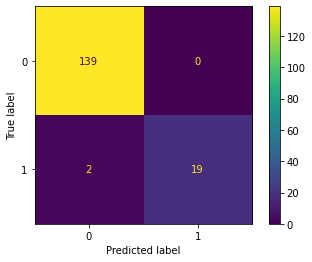

In [33]:
test_res = trainer.test(model)

# Inferencing

In [23]:
from pytorchvideo.data.encoded_video import EncodedVideo

In [53]:
# model_path = "../models/eff3d_bin.pt"
video_path = "../data/binary-data/train/VAR/2022-06-13 13-08-47.mp4"
video = EncodedVideo.from_path(video_path)

In [54]:
video_data = video.get_clip(0, 10)
print(video_data['video'].shape)
video_data = video_transform(video_data)

inputs = video_data["video"].cuda()
inputs = inputs.unsqueeze(0)
inputs.shape

torch.Size([3, 28, 960, 1280])


torch.Size([1, 3, 50, 256, 256])

In [55]:
preds = model(inputs)
preds = preds.detach().cpu().numpy()
preds
# preds = np.where(preds > 0, 1, 0)
# bin_idx_to_class[preds[0, 0]]

array([[-14.93018]], dtype=float32)

In [65]:
model_path = "../models/eff3d_bin.pt"
video_path = "../data/binary-data/train/VAR/2022-04-26 13-05-00.mp4"

In [78]:
def word_level_prediction(path_to_model, path_to_video):
    
    # model = VideoModel()
    # model.load_state_dict(torch.load(path_to_model))
    
    model = VideoModel.load_from_checkpoint(
    checkpoint_path="/home/toghrul/SLR/sign-lang/checkpoints/last-v13.ckpt",
    hparams_file="/home/toghrul/SLR/sign-lang/lightning_logs/version_59/hparams.yaml",
    map_location=None,
    )
    
    model = model.cuda()
    
    video = EncodedVideo.from_path(path_to_video)

    video_data = video.get_clip(0, 3)
    video_data = video_transform(video_data)

    inputs = video_data["video"].cuda()
    inputs = inputs.unsqueeze(0)
    
    preds = model(inputs).detach().cpu().numpy()
    # preds = np.where(preds > 0, 1, 0)
    
    return preds

In [79]:
word_level_prediction(model_path, video_path)

Using cache found in /home/toghrul/.cache/torch/hub/facebookresearch_pytorchvideo_main


array([[-15.133521]], dtype=float32)

# Validation

In [ ]:
# val_res = trainer.validate(model)